# Experimentación - ASTGCN


https://ojs.aaai.org/index.php/AAAI/article/view/3881

## 1. Obtención de datos



In [1]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload  # Python 3.4+


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [2]:
"/".join(path.split("/")[0:-1])

'/Users/maguado/Documents/UGR/Master/TFM/repo/GNNs_PowerGraph/TFM'

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [3]:
results_save_path = "./results"
name_model = "ASTGCN"

In [4]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:  row_132
Processing: 

## Funciones auxiliares - entrenamiento

In [5]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable


import torch
import torch.nn.functional as F
from utils.utils_graph import format_plot
from utils.utils_graph import plot_training_and_eval_losses, plot_predictions
from utils.general_nn import guardar_resultados

from utils.astgcn import ASTGCN

from utils.trainer import TrainerMSTGCN
from utils.mstgcn import MSTGCN


In [6]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, name, node_features, node_count, n_target, nb_block, k=1, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2):
        self.name  =name
        self.n_nodes = node_count
        self.n_target = n_target
        self.n_features = node_features
        self.nb_block = nb_block
        self.k = k
        self.nb_chev_filter = nb_chev_filter
        self.nb_time_filter = nb_time_filter
        self.time_strides = time_strides

    
        super(RecurrentGCN, self).__init__()
        self.recurrent = ASTGCN(in_channels=1, 
                                num_for_predict=n_target, 
                                len_input=node_features,
                                K=k, 
                                nb_block=nb_block, 
                                num_of_vertices=node_count,
                                nb_chev_filter=nb_chev_filter,
                                nb_time_filter=nb_time_filter, 
                                time_strides=time_strides)



    def forward(self, x, edge_index):
        h = self.recurrent(x, edge_index)
        h = F.relu(h)
        return h


In [7]:
import itertools

def entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem="", device = torch.device("cpu")):
    resultados_list = []

    n_nodes = dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]

    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None
    

    for nb_block, filter_, time_strides in tqdm(list(itertools.product(param_grid['nb_block'], param_grid['filter'], param_grid['time_strides']))):
        print(f"Entrenando modelo con nb_block={nb_block}, nb_chev_filter={filter_}, nb_time_filter={filter_}, time_strides={time_strides}")        
        model = RecurrentGCN(name="ASTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=nb_block, k=2, nb_chev_filter = filter_, nb_time_filter =filter_, time_strides = time_strides)
        
        trainer = TrainerMSTGCN(model, dataset, device, f"./results/{problem}", dataloader_params)

        losses, eval_losses, r2scores = trainer.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)
        r2score_tst, losses_tst, loss_nodes, _, _ = trainer.test()
    
        results_intermedio = {
            "nb_block": nb_block,
            "nb_chev_filter": filter_,
            "nb_time_filter": 3,
            "time_strides": 2,
            "loss_final": losses[-1],
            "r2_eval_final": np.mean(r2scores[-1]),
            "loss_eval_final": np.mean(eval_losses[-1]),
            "r2_test": np.mean(r2score_tst),
            "loss_test": np.mean(losses_tst),
            "loss_nodes": np.mean(loss_nodes, axis=0).tolist()
        }
        
        resultados_list.append(results_intermedio)

        if np.mean(losses_tst) < mejor_loss_test:
            mejor_loss_test = np.mean(losses_tst)
            mejor_trainer = trainer
            mejores_parametros = {
                "nb_block": nb_block,
                "nb_chev_filter": filter_,
                "nb_time_filter": 3,
                "time_strides": 2
            }
            mejores_resultados = results_intermedio

        print("Resultados intermedios: ", results_intermedio)

    resultados_gt = pd.DataFrame(resultados_list)

    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_gt

## Prueba - predicción por tipos

In [8]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}

device = torch.device("cpu")
num_early_stop = 0
num_epochs = 30
lr = 0.01

### Gen trip

In [9]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [10]:
n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
hidden_size =100

#### Sencilla 

In [11]:


device = torch.device("cpu")
model_gt = RecurrentGCN(name="ASTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)

trainer_gt = TrainerMSTGCN(model_gt, dataset_gt,device, f"./results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_gt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.4729 | Eval Loss: 0.3577 | Eval R2: -163.1363 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.3545 | Eval Loss: 0.3467 | Eval R2: -157.2948 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.3465 | Eval Loss: 0.3454 | Eval R2: -156.6844 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.3462 | Eval Loss: 0.3452 | Eval R2: -156.5390 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.3462 | Eval Loss: 0.3452 | Eval R2: -156.5309 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.3463 | Eval Loss: 0.3452 | Eval R2: -156.5262 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.3464 | Eval Loss: 0.3453 | Eval R2: -156.5392 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.3464 | Eval Loss: 0.3454 | Eval R2: -156.5552 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.3465 | Eval Loss: 0.3455 | Eval R2: -156.5724 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0

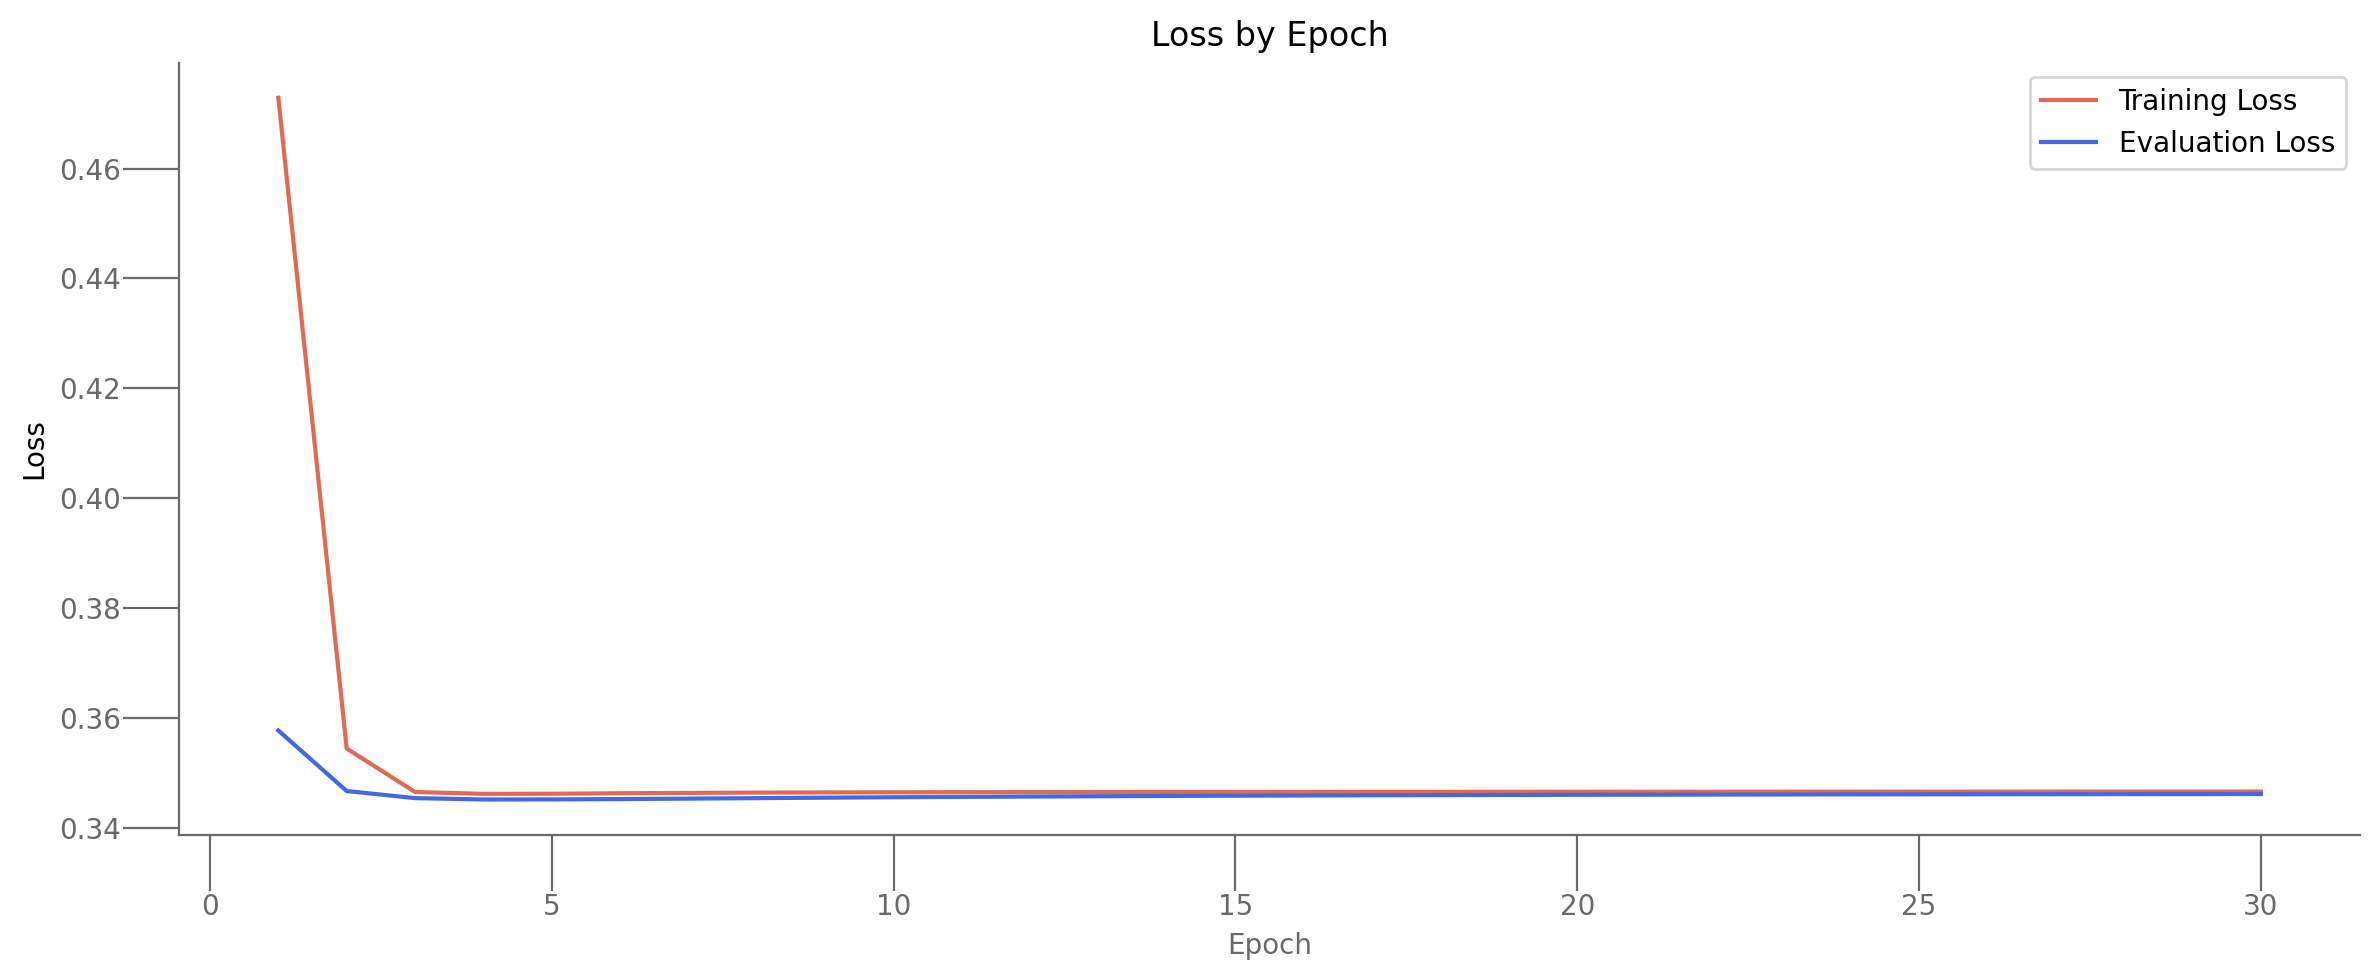


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.327337, test r2score -192.142508


In [12]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_gt, real_gt = trainer_gt.test()

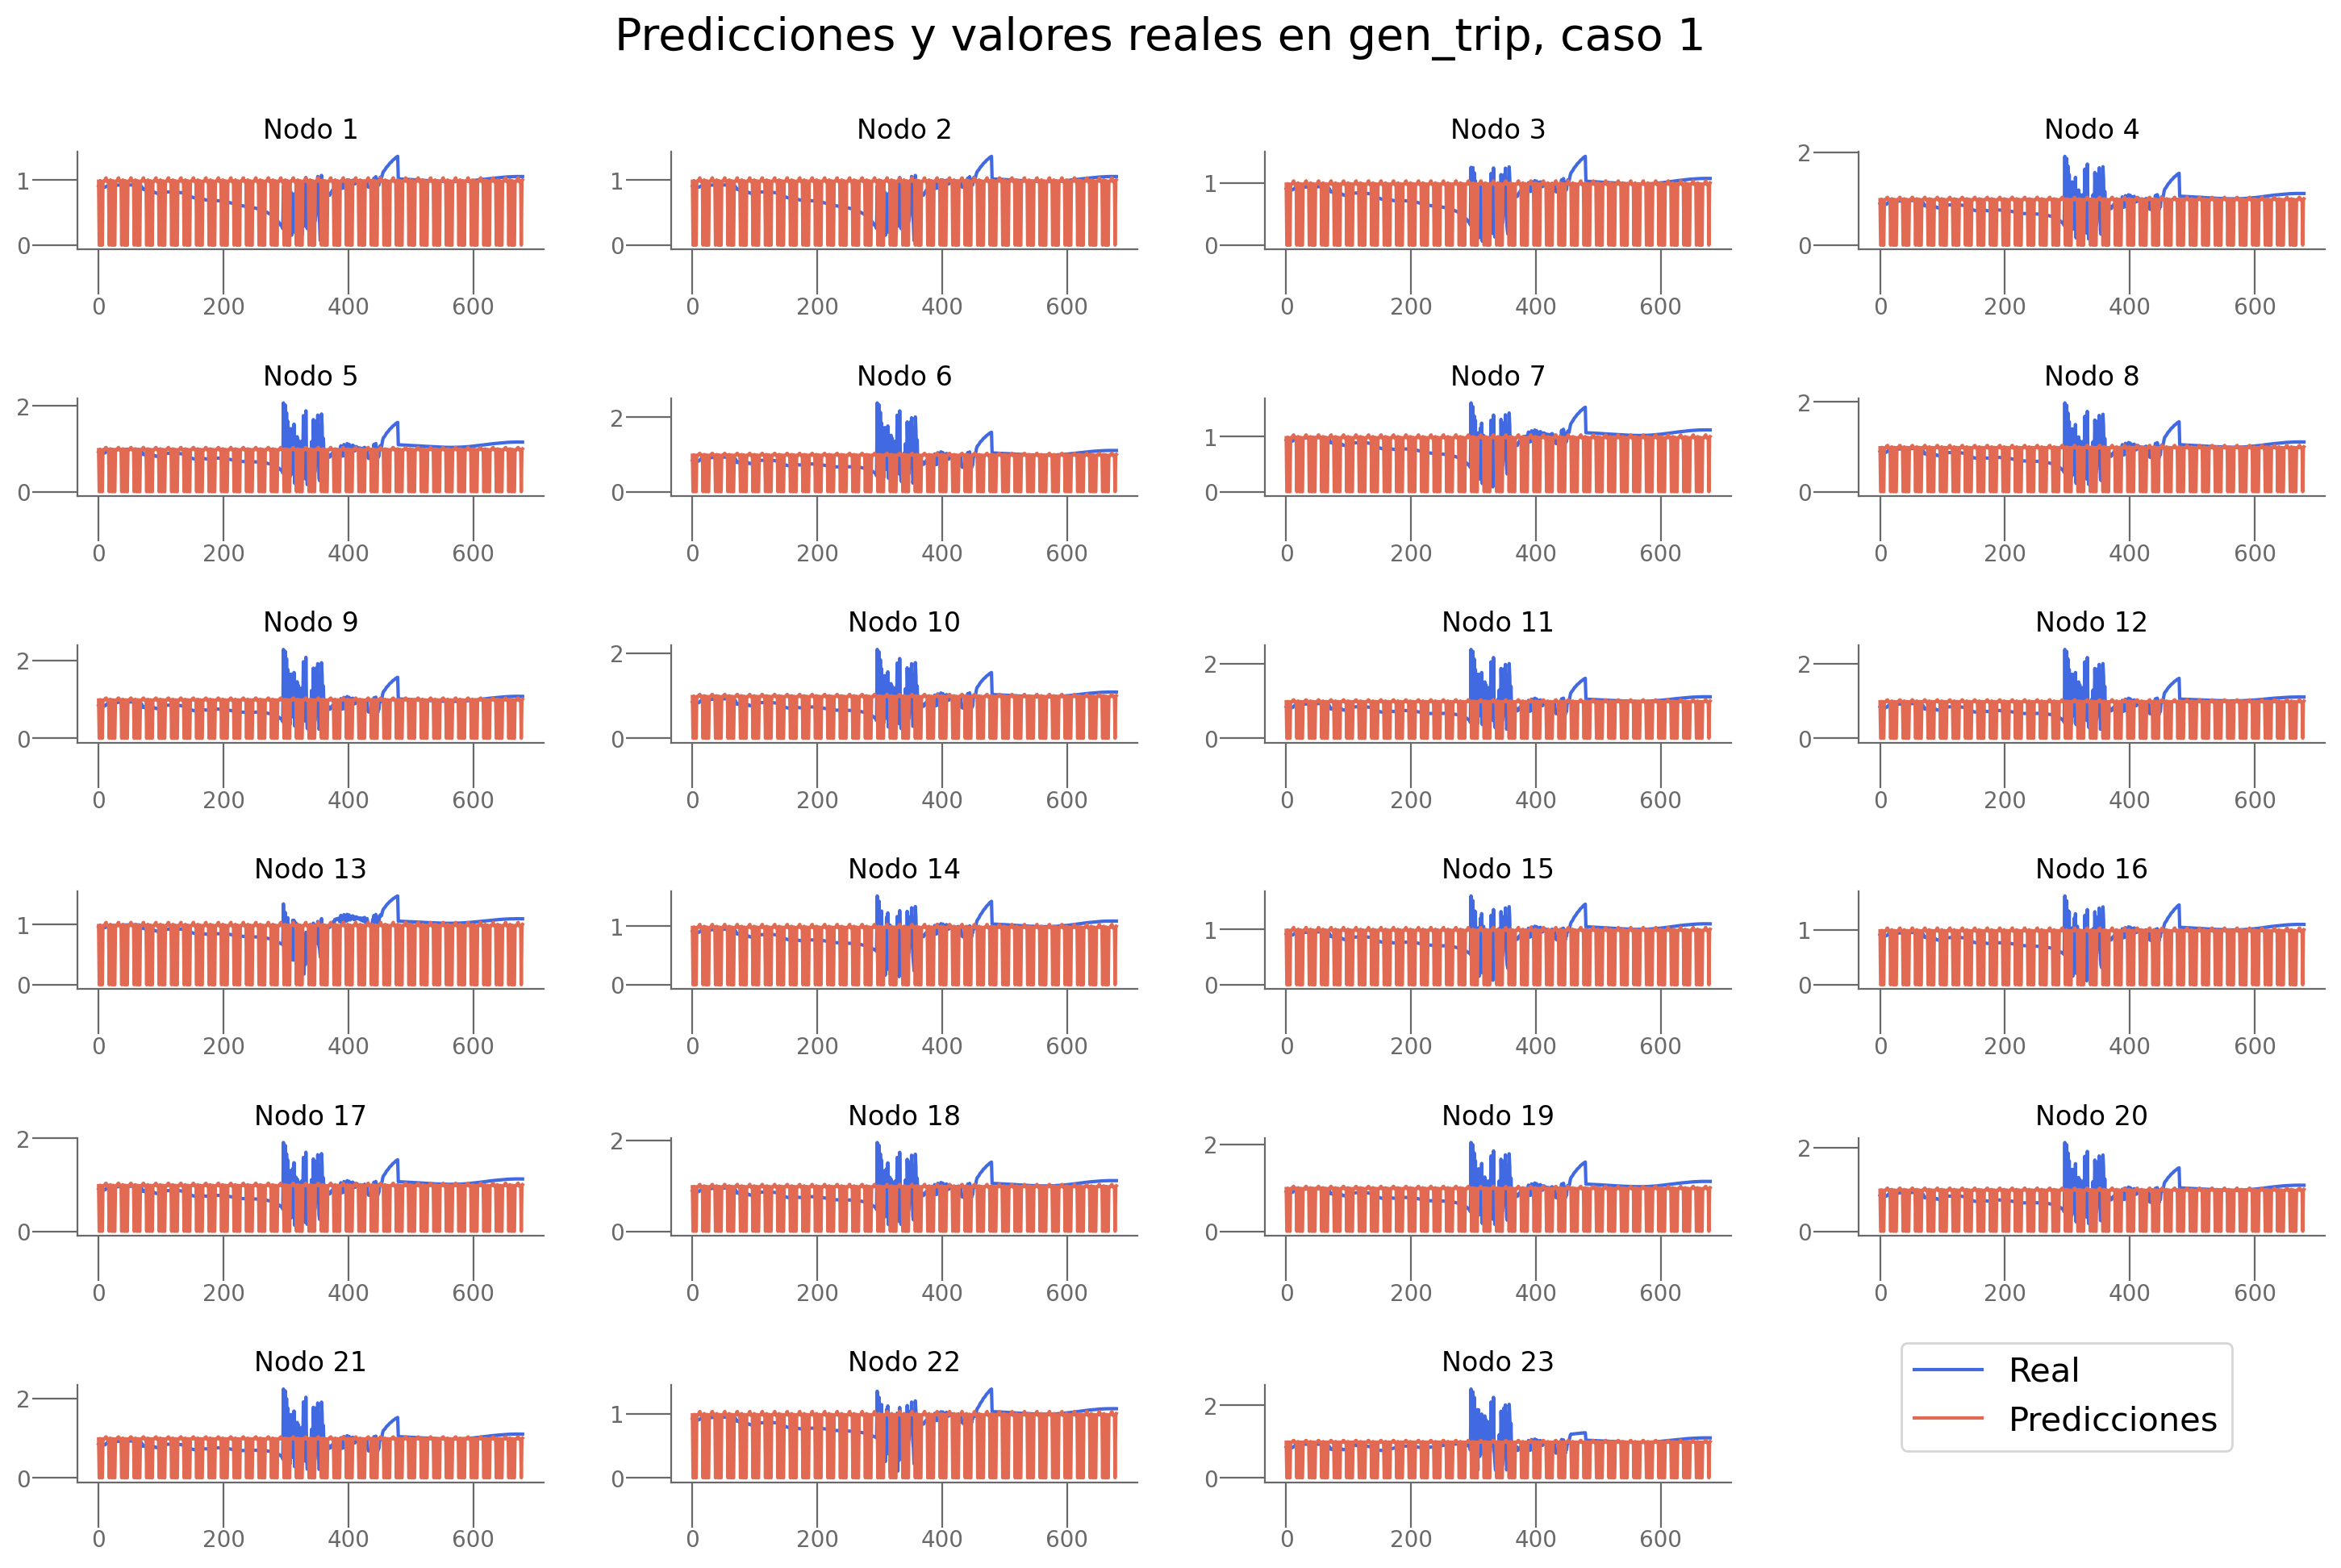

In [13]:
plot_predictions(predictions_gt, real_gt, n_target, 1, n_div_gt, problem_gt)

#### Ajuste de parámetros 

In [35]:

param_grid = {
    "nb_block": [1, 2, 3],
    "filter": [2,4,8],
    "time_strides": [1, 2, 4]
}

num_epochs = 100
num_early_stop = 10

trainer_gt,params_gt, resultados_final_gt, resultados_gt = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_gt, dataloader_params2, num_early_stop, num_epochs, problem=problem_gt)

  0%|          | 0/27 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.4321 | Eval Loss: 0.3054 | Eval R2: -131.4407 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.2647 | Eval Loss: 0.2306 | Eval R2: -94.5521 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.2082 | Eval Loss: 0.1755 | Eval R2: -69.2208 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.1420 | Eval Loss: 0.1045 | Eval R2: -33.4264 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.0959 | Eval Loss: 0.0855 | Eval R2: -23.4782 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.0875 | Eval Loss: 0.0809 | Eval R2: -22.1238 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.0842 | Eval Loss: 0.0785 | Eval R2: -21.2584 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.0822 | Eval Loss: 0.0765 | Eval R2: -20.7972 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.08

  4%|▎         | 1/27 [06:19<2:44:23, 379.36s/it]

preds:  (1, 23, 20)
test loss: 0.018173, test r2score -8.041373
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.023216402158141136, 'r2_eval_final': -6.5363593101501465, 'loss_eval_final': 0.022421741858124733, 'r2_test': -8.041373210086766, 'loss_test': 0.018173128366470337, 'loss_nodes': [[0.014876097440719604, 0.014530775137245655, 0.01558992825448513, 0.014047706499695778, 0.018326815217733383, 0.014743770472705364, 0.0158753152936697, 0.018111873418092728, 0.017594268545508385, 0.015516594983637333, 0.01616179756820202, 0.017751051113009453, 0.01975092478096485, 0.02032194659113884, 0.020377956330776215, 0.01893988624215126, 0.02396208792924881, 0.02176535502076149, 0.02046195976436138, 0.02475651539862156]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==

  7%|▋         | 2/27 [11:51<2:26:29, 351.58s/it]

preds:  (1, 23, 20)
test loss: 0.044105, test r2score -14.855204
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06206050142645836, 'r2_eval_final': -14.490979194641113, 'loss_eval_final': 0.056686632335186005, 'r2_test': -14.855203890146889, 'loss_test': 0.044105466455221176, 'loss_nodes': [[0.041279833763837814, 0.04092373698949814, 0.04324406385421753, 0.041257504373788834, 0.04384107515215874, 0.043711110949516296, 0.0460963100194931, 0.0422729067504406, 0.04131663218140602, 0.04242848977446556, 0.043245747685432434, 0.04415062069892883, 0.0438571497797966, 0.044952571392059326, 0.047507692128419876, 0.043092064559459686, 0.047799158841371536, 0.04835837334394455, 0.04640313610434532, 0.04637107998132706]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

=====

 11%|█         | 3/27 [17:02<2:13:15, 333.13s/it]

preds:  (1, 23, 20)
test loss: 0.065888, test r2score -21.383784
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.08827188611030579, 'r2_eval_final': -19.76938819885254, 'loss_eval_final': 0.08059532940387726, 'r2_test': -21.38378351899726, 'loss_test': 0.0658884197473526, 'loss_nodes': [[0.06462564319372177, 0.06482360512018204, 0.06676913052797318, 0.0644325539469719, 0.06564788520336151, 0.06398990005254745, 0.06568906456232071, 0.06451069563627243, 0.0658239871263504, 0.06520655006170273, 0.06490503251552582, 0.06704002618789673, 0.06604557484388351, 0.06619400531053543, 0.0673736184835434, 0.06576624512672424, 0.06770320236682892, 0.06775645911693573, 0.06551489233970642, 0.0679502785205841]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

===================

 15%|█▍        | 4/27 [23:25<2:15:12, 352.73s/it]

preds:  (1, 23, 20)
test loss: 0.063184, test r2score -37.231284
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06530307978391647, 'r2_eval_final': -30.385639190673828, 'loss_eval_final': 0.0676840990781784, 'r2_test': -37.23128444559395, 'loss_test': 0.06318444013595581, 'loss_nodes': [[0.002120547229424119, 0.006072360556572676, 0.005484574008733034, 0.0042953272350132465, 0.0074873678386211395, 0.004605814348906279, 0.006498128641396761, 0.005635974928736687, 0.00631168344989419, 0.005243516527116299, 1.105750560760498, 0.009035077877342701, 0.009412456303834915, 0.011059005744755268, 0.010119861923158169, 0.010162733495235443, 0.015740830451250076, 0.012112780474126339, 0.011323275975883007, 0.015217537991702557]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 9

 19%|█▊        | 5/27 [29:09<2:08:10, 349.57s/it]

preds:  (1, 23, 20)
test loss: 0.229325, test r2score -141.019250
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.2338154911994934, 'r2_eval_final': -114.46077728271484, 'loss_eval_final': 0.2371997833251953, 'r2_test': -141.01924967392716, 'loss_test': 0.22932545840740204, 'loss_nodes': [[1.104114055633545, 0.0047796317376196384, 0.005907553713768721, 0.004742042161524296, 0.008775681257247925, 0.005625148769468069, 0.005663245916366577, 0.007140944711863995, 0.0061476887203752995, 0.006727233994752169, 0.006192387081682682, 0.010271560400724411, 0.013446362689137459, 0.011373872868716717, 1.1133455038070679, 0.012266336008906364, 0.015066475607454777, 1.1133675575256348, 1.1126822233200073, 0.018873516470193863]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942



 22%|██▏       | 6/27 [34:29<1:58:47, 339.39s/it]

preds:  (1, 23, 20)
test loss: 0.009307, test r2score -2.973884
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.012150156311690807, 'r2_eval_final': -2.8836348056793213, 'loss_eval_final': 0.012064856477081776, 'r2_test': -2.973883969846387, 'loss_test': 0.00930743757635355, 'loss_nodes': [[0.0035410362761467695, 0.005480461288243532, 0.006767719052731991, 0.005122572649270296, 0.00857960432767868, 0.005999221932142973, 0.006514274049550295, 0.00674224691465497, 0.008104068227112293, 0.007211095653474331, 0.007689527701586485, 0.008818304166197777, 0.011290705762803555, 0.011512388475239277, 0.012695792131125927, 0.01149122416973114, 0.01572832092642784, 0.014313754625618458, 0.012499723583459854, 0.016046717762947083]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 

 26%|██▌       | 7/27 [41:33<2:02:25, 367.25s/it]

preds:  (1, 23, 20)
test loss: 0.283974, test r2score -177.173511
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.28787553310394287, 'r2_eval_final': -142.41795349121094, 'loss_eval_final': 0.2933364808559418, 'r2_test': -177.1735112811328, 'loss_test': 0.2839735448360443, 'loss_nodes': [[0.0023605674505233765, 0.004637998063117266, 1.1078596115112305, 0.004836148116737604, 0.009414619766175747, 0.005161828361451626, 0.007127431686967611, 0.005784627981483936, 1.107917070388794, 0.005379768554121256, 1.105750560760498, 0.00796956941485405, 1.1137882471084595, 0.012658379971981049, 0.01138270366936922, 1.110581636428833, 0.016226062551140785, 0.011589596047997475, 0.01267479918897152, 0.016369367018342018]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

=========

 30%|██▉       | 8/27 [48:00<1:58:17, 373.57s/it]

preds:  (1, 23, 20)
test loss: 0.062841, test r2score -37.517733
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06507665663957596, 'r2_eval_final': -30.33774757385254, 'loss_eval_final': 0.06689751148223877, 'r2_test': -37.51773337306495, 'loss_test': 0.06284051388502121, 'loss_nodes': [[0.0017114728689193726, 0.005208647344261408, 0.004895211197435856, 0.004525831434875727, 0.007593950722366571, 0.004631567280739546, 1.1046234369277954, 0.005493522621691227, 0.005407602060586214, 0.005415705498307943, 0.005887644365429878, 0.007982252165675163, 0.007874202914536, 0.011751875281333923, 0.010911674238741398, 0.00983533263206482, 0.014364426955580711, 0.011992366053164005, 0.011944010853767395, 0.014760367572307587]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942


 33%|███▎      | 9/27 [53:42<1:49:03, 363.50s/it]

preds:  (1, 23, 20)
test loss: 0.009024, test r2score -2.808666
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.010601689107716084, 'r2_eval_final': -2.650343894958496, 'loss_eval_final': 0.011972799897193909, 'r2_test': -2.8086661107338387, 'loss_test': 0.009024149738252163, 'loss_nodes': [[0.003362419782206416, 0.00599950086325407, 0.006634837482124567, 0.005901429336518049, 0.008209398947656155, 0.005703074857592583, 0.007138311397284269, 0.005704977549612522, 0.006402590312063694, 0.0065744235180318356, 0.007895266637206078, 0.009591217152774334, 0.00963772926479578, 0.012122596614062786, 0.01169406995177269, 0.011852055788040161, 0.015717580914497375, 0.013247057795524597, 0.011946500279009342, 0.015147961676120758]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset

 37%|███▋      | 10/27 [1:06:13<2:16:56, 483.34s/it]

preds:  (1, 23, 20)
test loss: 0.066551, test r2score -21.055857
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.08833858370780945, 'r2_eval_final': -19.937734603881836, 'loss_eval_final': 0.08148989081382751, 'r2_test': -21.055857049489713, 'loss_test': 0.06655061990022659, 'loss_nodes': [[0.06563497334718704, 0.06467816233634949, 0.068116694688797, 0.06570029258728027, 0.06556104868650436, 0.06375513225793839, 0.06729737669229507, 0.06553376466035843, 0.06564594805240631, 0.06513696163892746, 0.06524977833032608, 0.0677298754453659, 0.0676545724272728, 0.0663217082619667, 0.0677700787782669, 0.06539971381425858, 0.06941552460193634, 0.0679468959569931, 0.06772854179143906, 0.06873535364866257]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

===================

 41%|████      | 11/27 [1:16:46<2:21:04, 529.06s/it]

preds:  (1, 23, 20)
test loss: 0.117793, test r2score -56.302546
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.13925892114639282, 'r2_eval_final': -47.48078918457031, 'loss_eval_final': 0.13284173607826233, 'r2_test': -56.3025457725406, 'loss_test': 0.1177927628159523, 'loss_nodes': [[1.104114055633545, 0.06466145813465118, 0.06669046729803085, 0.06451651453971863, 0.0656609833240509, 0.06400374323129654, 0.06551828235387802, 0.06459600478410721, 0.06526929140090942, 0.06558229774236679, 0.06484325975179672, 0.06627551466226578, 0.06601548939943314, 0.06612251698970795, 0.06733537465333939, 0.06559818983078003, 0.06766883283853531, 0.0678962841629982, 0.0655800849199295, 0.06790728121995926]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== 

 44%|████▍     | 12/27 [1:26:37<2:16:56, 547.75s/it]

preds:  (1, 23, 20)
test loss: 0.379597, test r2score -224.236782
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.39807942509651184, 'r2_eval_final': -182.73883056640625, 'loss_eval_final': 0.39993515610694885, 'r2_test': -224.23678225838796, 'loss_test': 0.3795968294143677, 'loss_nodes': [[0.06431854516267776, 0.06463295966386795, 0.06672310829162598, 1.1079031229019165, 0.0656687542796135, 0.06392151117324829, 0.06544511765241623, 0.06458376348018646, 1.107917070388794, 0.0653686374425888, 0.06482107192277908, 1.1086198091506958, 0.06600870937108994, 0.06609516590833664, 1.1133455038070679, 0.06547217071056366, 1.1202422380447388, 0.06787244230508804, 0.06553468108177185, 1.117438554763794]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== T

 48%|████▊     | 13/27 [1:40:20<2:27:15, 631.14s/it]

preds:  (1, 23, 20)
test loss: 0.174158, test r2score -108.068267
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.1785261482000351, 'r2_eval_final': -86.9439468383789, 'loss_eval_final': 0.18163156509399414, 'r2_test': -108.06826696000202, 'loss_test': 0.1741577833890915, 'loss_nodes': [[0.003646905766800046, 0.005768068600445986, 0.005684214644134045, 1.1079031229019165, 1.1111345291137695, 0.004848920274525881, 0.006973097566515207, 0.006318396423012018, 0.006382632534950972, 0.006882599554955959, 0.006943204440176487, 0.009278875775635242, 0.010025051422417164, 0.01179223321378231, 0.01086643896996975, 0.011111204512417316, 0.015601902268826962, 1.1133675575256348, 0.012486979365348816, 0.01613890565931797]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

====

 52%|█████▏    | 14/27 [1:51:04<2:17:36, 635.08s/it]

preds:  (1, 23, 20)
test loss: 0.009678, test r2score -3.309834
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.011713960207998753, 'r2_eval_final': -3.146042585372925, 'loss_eval_final': 0.012930933386087418, 'r2_test': -3.3098339109455885, 'loss_test': 0.009677641093730927, 'loss_nodes': [[0.004174551460891962, 0.006236504763364792, 0.006727942265570164, 0.006520542316138744, 0.009296624921262264, 0.005583066958934069, 0.006549068260937929, 0.007970214821398258, 0.006890001241117716, 0.007811186835169792, 0.008305150084197521, 0.009885750710964203, 0.01174034271389246, 0.012788400053977966, 0.011769476346671581, 0.01305348053574562, 0.01589670591056347, 0.014315247535705566, 0.012266842648386955, 0.015771720558404922]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset:

 56%|█████▌    | 15/27 [2:00:45<2:03:45, 618.83s/it]

preds:  (1, 23, 20)
test loss: 0.064714, test r2score -37.205342
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06790314614772797, 'r2_eval_final': -30.62136459350586, 'loss_eval_final': 0.06922577321529388, 'r2_test': -37.20534182650922, 'loss_test': 0.06471395492553711, 'loss_nodes': [[0.004861009772866964, 0.005925701931118965, 0.007012191228568554, 0.007085718214511871, 0.0080563984811306, 0.005826187320053577, 0.007518025115132332, 0.007293028756976128, 0.00889342837035656, 0.007661939132958651, 0.007670915219932795, 0.01108354702591896, 0.010017544031143188, 0.013257836923003197, 0.012359392829239368, 0.011706406250596046, 0.016233308240771294, 0.01288894284516573, 1.1126822233200073, 0.016245512291789055]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

=

 59%|█████▉    | 16/27 [2:14:32<2:04:56, 681.50s/it]

preds:  (1, 23, 20)
test loss: 0.118641, test r2score -72.638953
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.12086308002471924, 'r2_eval_final': -58.639095306396484, 'loss_eval_final': 0.12370463460683823, 'r2_test': -72.63895327389541, 'loss_test': 0.11864050477743149, 'loss_nodes': [[1.104114055633545, 0.005621807184070349, 0.005177374929189682, 0.004752060864120722, 0.007590610068291426, 0.006509981118142605, 0.006500924471765757, 0.005214413162320852, 0.007511128671467304, 0.005882160738110542, 0.006810723338276148, 0.009287683293223381, 0.009041682817041874, 1.1144286394119263, 0.010418635793030262, 0.010885950177907944, 0.015088477171957493, 0.01201663352549076, 0.011710948310792446, 0.014245837926864624]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942


 63%|██████▎   | 17/27 [2:29:15<2:03:41, 742.18s/it]

preds:  (1, 23, 20)
test loss: 0.007547, test r2score -1.933839
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.009062101133167744, 'r2_eval_final': -1.8141757249832153, 'loss_eval_final': 0.010265002958476543, 'r2_test': -1.9338393391800293, 'loss_test': 0.007547078188508749, 'loss_nodes': [[0.0017025080742314458, 0.005309256259351969, 0.004439411219209433, 0.004234903492033482, 0.007717794738709927, 0.004596906714141369, 0.004618976265192032, 0.004499135073274374, 0.006283499766141176, 0.004976384807378054, 0.005072656087577343, 0.00813883263617754, 0.008132210932672024, 0.010852938517928123, 0.009797072038054466, 0.010030869394540787, 0.014025311917066574, 0.01154276728630066, 0.01144034881144762, 0.01352976355701685]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset

 67%|██████▋   | 18/27 [2:41:17<1:50:25, 736.12s/it]

preds:  (1, 23, 20)
test loss: 0.063770, test r2score -37.752358
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06658634543418884, 'r2_eval_final': -30.711015701293945, 'loss_eval_final': 0.06791116297245026, 'r2_test': -37.75235772262313, 'loss_test': 0.06377027928829193, 'loss_nodes': [[0.003408130258321762, 0.004909242503345013, 0.0059465812519192696, 0.0050714872777462006, 0.007675518281757832, 0.004988117143511772, 0.005938132759183645, 0.006573703605681658, 1.107917070388794, 0.007124281954020262, 0.006307905074208975, 0.008859088644385338, 0.009976876899600029, 0.010777824558317661, 0.012367966584861279, 0.011355140246450901, 0.014320133253932, 0.01359913032501936, 0.011824077926576138, 0.01646464318037033]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942


 70%|███████   | 19/27 [2:59:50<1:53:13, 849.23s/it]

preds:  (1, 23, 20)
test loss: 0.222378, test r2score -122.909538
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.24290022253990173, 'r2_eval_final': -101.50276947021484, 'loss_eval_final': 0.2390679121017456, 'r2_test': -122.90953799058741, 'loss_test': 0.2223782241344452, 'loss_nodes': [[1.104114055633545, 0.06555316597223282, 0.06715227663516998, 0.0648641437292099, 0.06522756069898605, 0.06406289339065552, 0.06564918160438538, 0.0640878826379776, 0.06547530740499496, 1.1053069829940796, 0.06530142575502396, 0.0671752467751503, 0.06630309671163559, 0.06683872640132904, 0.06780508905649185, 0.06587579101324081, 0.06781953573226929, 0.06814306229352951, 1.1126822233200073, 0.06812768429517746]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

====================

 74%|███████▍  | 20/27 [3:15:16<1:41:45, 872.27s/it]

preds:  (1, 23, 20)
test loss: 0.274294, test r2score -158.023005
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.2946888208389282, 'r2_eval_final': -129.29510498046875, 'loss_eval_final': 0.2930457890033722, 'r2_test': -158.02300480444225, 'loss_test': 0.27429381012916565, 'loss_nodes': [[1.104114055633545, 0.06469129025936127, 0.0666118636727333, 1.1079031229019165, 0.0658392459154129, 0.06376227736473083, 0.06570291519165039, 0.06445575505495071, 0.0665510967373848, 0.06514155864715576, 1.105750560760498, 1.1086198091506958, 0.06597115099430084, 0.06617504358291626, 0.0672140046954155, 0.06600257009267807, 0.06893114745616913, 0.06821973621845245, 0.06623117625713348, 0.0679885745048523]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRA

 78%|███████▊  | 21/27 [3:29:00<1:25:47, 857.84s/it]

preds:  (1, 23, 20)
test loss: 0.065781, test r2score -21.659402
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.08730633556842804, 'r2_eval_final': -19.798566818237305, 'loss_eval_final': 0.08037429302930832, 'r2_test': -21.659402139198626, 'loss_test': 0.0657811090350151, 'loss_nodes': [[0.06428132206201553, 0.06466379016637802, 0.06673478335142136, 0.06443969160318375, 0.06565457582473755, 0.06388068199157715, 0.0658021941781044, 0.06461088359355927, 0.06524049490690231, 0.06527891010046005, 0.0648387148976326, 0.06632547080516815, 0.06601884216070175, 0.06619590520858765, 0.06724124401807785, 0.06542780250310898, 0.06769950687885284, 0.0678519532084465, 0.06558959931135178, 0.06784576922655106]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

================

 81%|████████▏ | 22/27 [3:47:26<1:17:41, 932.26s/it]

preds:  (1, 23, 20)
test loss: 0.008733, test r2score -2.671774
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.011219033971428871, 'r2_eval_final': -2.532061815261841, 'loss_eval_final': 0.011821419931948185, 'r2_test': -2.671773622785409, 'loss_test': 0.008732864633202553, 'loss_nodes': [[0.002829525154083967, 0.005163575056940317, 0.0057181017473340034, 0.005179754924029112, 0.007337494287639856, 0.005287043750286102, 0.006071174517273903, 0.006535399705171585, 0.006772122345864773, 0.006259285379201174, 0.006478997878730297, 0.00928706955164671, 0.009687485173344612, 0.011449421755969524, 0.012453221715986729, 0.011302107013761997, 0.014977028593420982, 0.01345719676464796, 0.011263354681432247, 0.01714794524013996]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset:

 85%|████████▌ | 23/27 [4:03:02<1:02:13, 933.31s/it]

preds:  (1, 23, 20)
test loss: 0.064674, test r2score -38.417716
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06783943623304367, 'r2_eval_final': -31.316120147705078, 'loss_eval_final': 0.06923718750476837, 'r2_test': -38.41771584123241, 'loss_test': 0.06467363238334656, 'loss_nodes': [[0.004580644890666008, 0.005598081275820732, 0.006401379592716694, 0.00769082410261035, 0.008551831357181072, 1.107574224472046, 0.007346105296164751, 0.007152155973017216, 0.007422456983476877, 0.00884222611784935, 0.007688977289944887, 0.009916889481246471, 0.010009226389229298, 0.011973535642027855, 0.01273753959685564, 0.012663906440138817, 0.014815949834883213, 0.01397821307182312, 0.012236520648002625, 0.01629205048084259]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

=

 89%|████████▉ | 24/27 [4:17:27<45:38, 912.86s/it]  

preds:  (1, 23, 20)
test loss: 0.011715, test r2score -3.964492
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.014686603099107742, 'r2_eval_final': -3.724929094314575, 'loss_eval_final': 0.014313988387584686, 'r2_test': -3.9644922167117116, 'loss_test': 0.011714554391801357, 'loss_nodes': [[0.006210857070982456, 0.007290813140571117, 0.007952338084578514, 0.00806930661201477, 0.00942178163677454, 0.009160039946436882, 0.01111676823347807, 0.009883868508040905, 0.008851833641529083, 0.009341860190033913, 0.00954007264226675, 0.01260401587933302, 0.013394543901085854, 0.014714709483087063, 0.015852129086852074, 0.014184406958520412, 0.01768912933766842, 0.01620696485042572, 0.014404543675482273, 0.01840110309422016]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942


 93%|█████████▎| 25/27 [4:39:02<34:15, 1027.52s/it]

preds:  (1, 23, 20)
test loss: 0.118774, test r2score -72.169043
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.12197461724281311, 'r2_eval_final': -58.37848663330078, 'loss_eval_final': 0.12417814880609512, 'r2_test': -72.16904327726162, 'loss_test': 0.11877363920211792, 'loss_nodes': [[0.002594615099951625, 0.007015422452241182, 0.005402161739766598, 0.005751077085733414, 0.007544865366071463, 0.005556662566959858, 0.00598499970510602, 0.005730817094445229, 0.00749550573527813, 0.006586933974176645, 1.105750560760498, 0.008442358113825321, 0.008575244806706905, 1.1144286394119263, 0.013953568413853645, 0.009655438363552094, 0.013765479438006878, 0.013734946958720684, 0.010892592370510101, 0.01661098189651966]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==

 96%|█████████▋| 26/27 [4:56:46<17:18, 1038.47s/it]

preds:  (1, 23, 20)
test loss: 0.117757, test r2score -70.279183
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.12128999084234238, 'r2_eval_final': -57.2574348449707, 'loss_eval_final': 0.12335936725139618, 'r2_test': -70.27918299364158, 'loss_test': 0.11775658279657364, 'loss_nodes': [[0.002411690540611744, 0.00467948243021965, 0.0057653384283185005, 0.004174868110567331, 0.007276072166860104, 0.004929852671921253, 0.005477860104292631, 0.0053619579412043095, 0.005544757936149836, 0.005326627753674984, 0.0057034846395254135, 0.007595357019454241, 0.00832259003072977, 0.009860814549028873, 0.010087648406624794, 0.009385714307427406, 0.01362163107842207, 1.1133675575256348, 1.1126822233200073, 0.013555643148720264]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942


100%|██████████| 27/27 [5:12:17<00:00, 693.99s/it] 

preds:  (1, 23, 20)
test loss: 0.064503, test r2score -38.856991
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06757090240716934, 'r2_eval_final': -31.71665382385254, 'loss_eval_final': 0.0687304213643074, 'r2_test': -38.856991348598676, 'loss_test': 0.06450299173593521, 'loss_nodes': [[0.0038055097684264183, 1.108215570449829, 0.006585355382412672, 0.0065266103483736515, 0.008095023222267628, 0.006178805138915777, 0.007497031707316637, 0.007101719733327627, 0.007290371228009462, 0.00706695020198822, 0.007014179136604071, 0.010137236677110195, 0.010196879506111145, 0.011855167336761951, 0.012877995148301125, 0.011648342944681644, 0.01568145491182804, 0.013757907785475254, 0.012361805886030197, 0.016166510060429573]]}


In [36]:
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_gt.test()



==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.007547, test r2score -1.933836


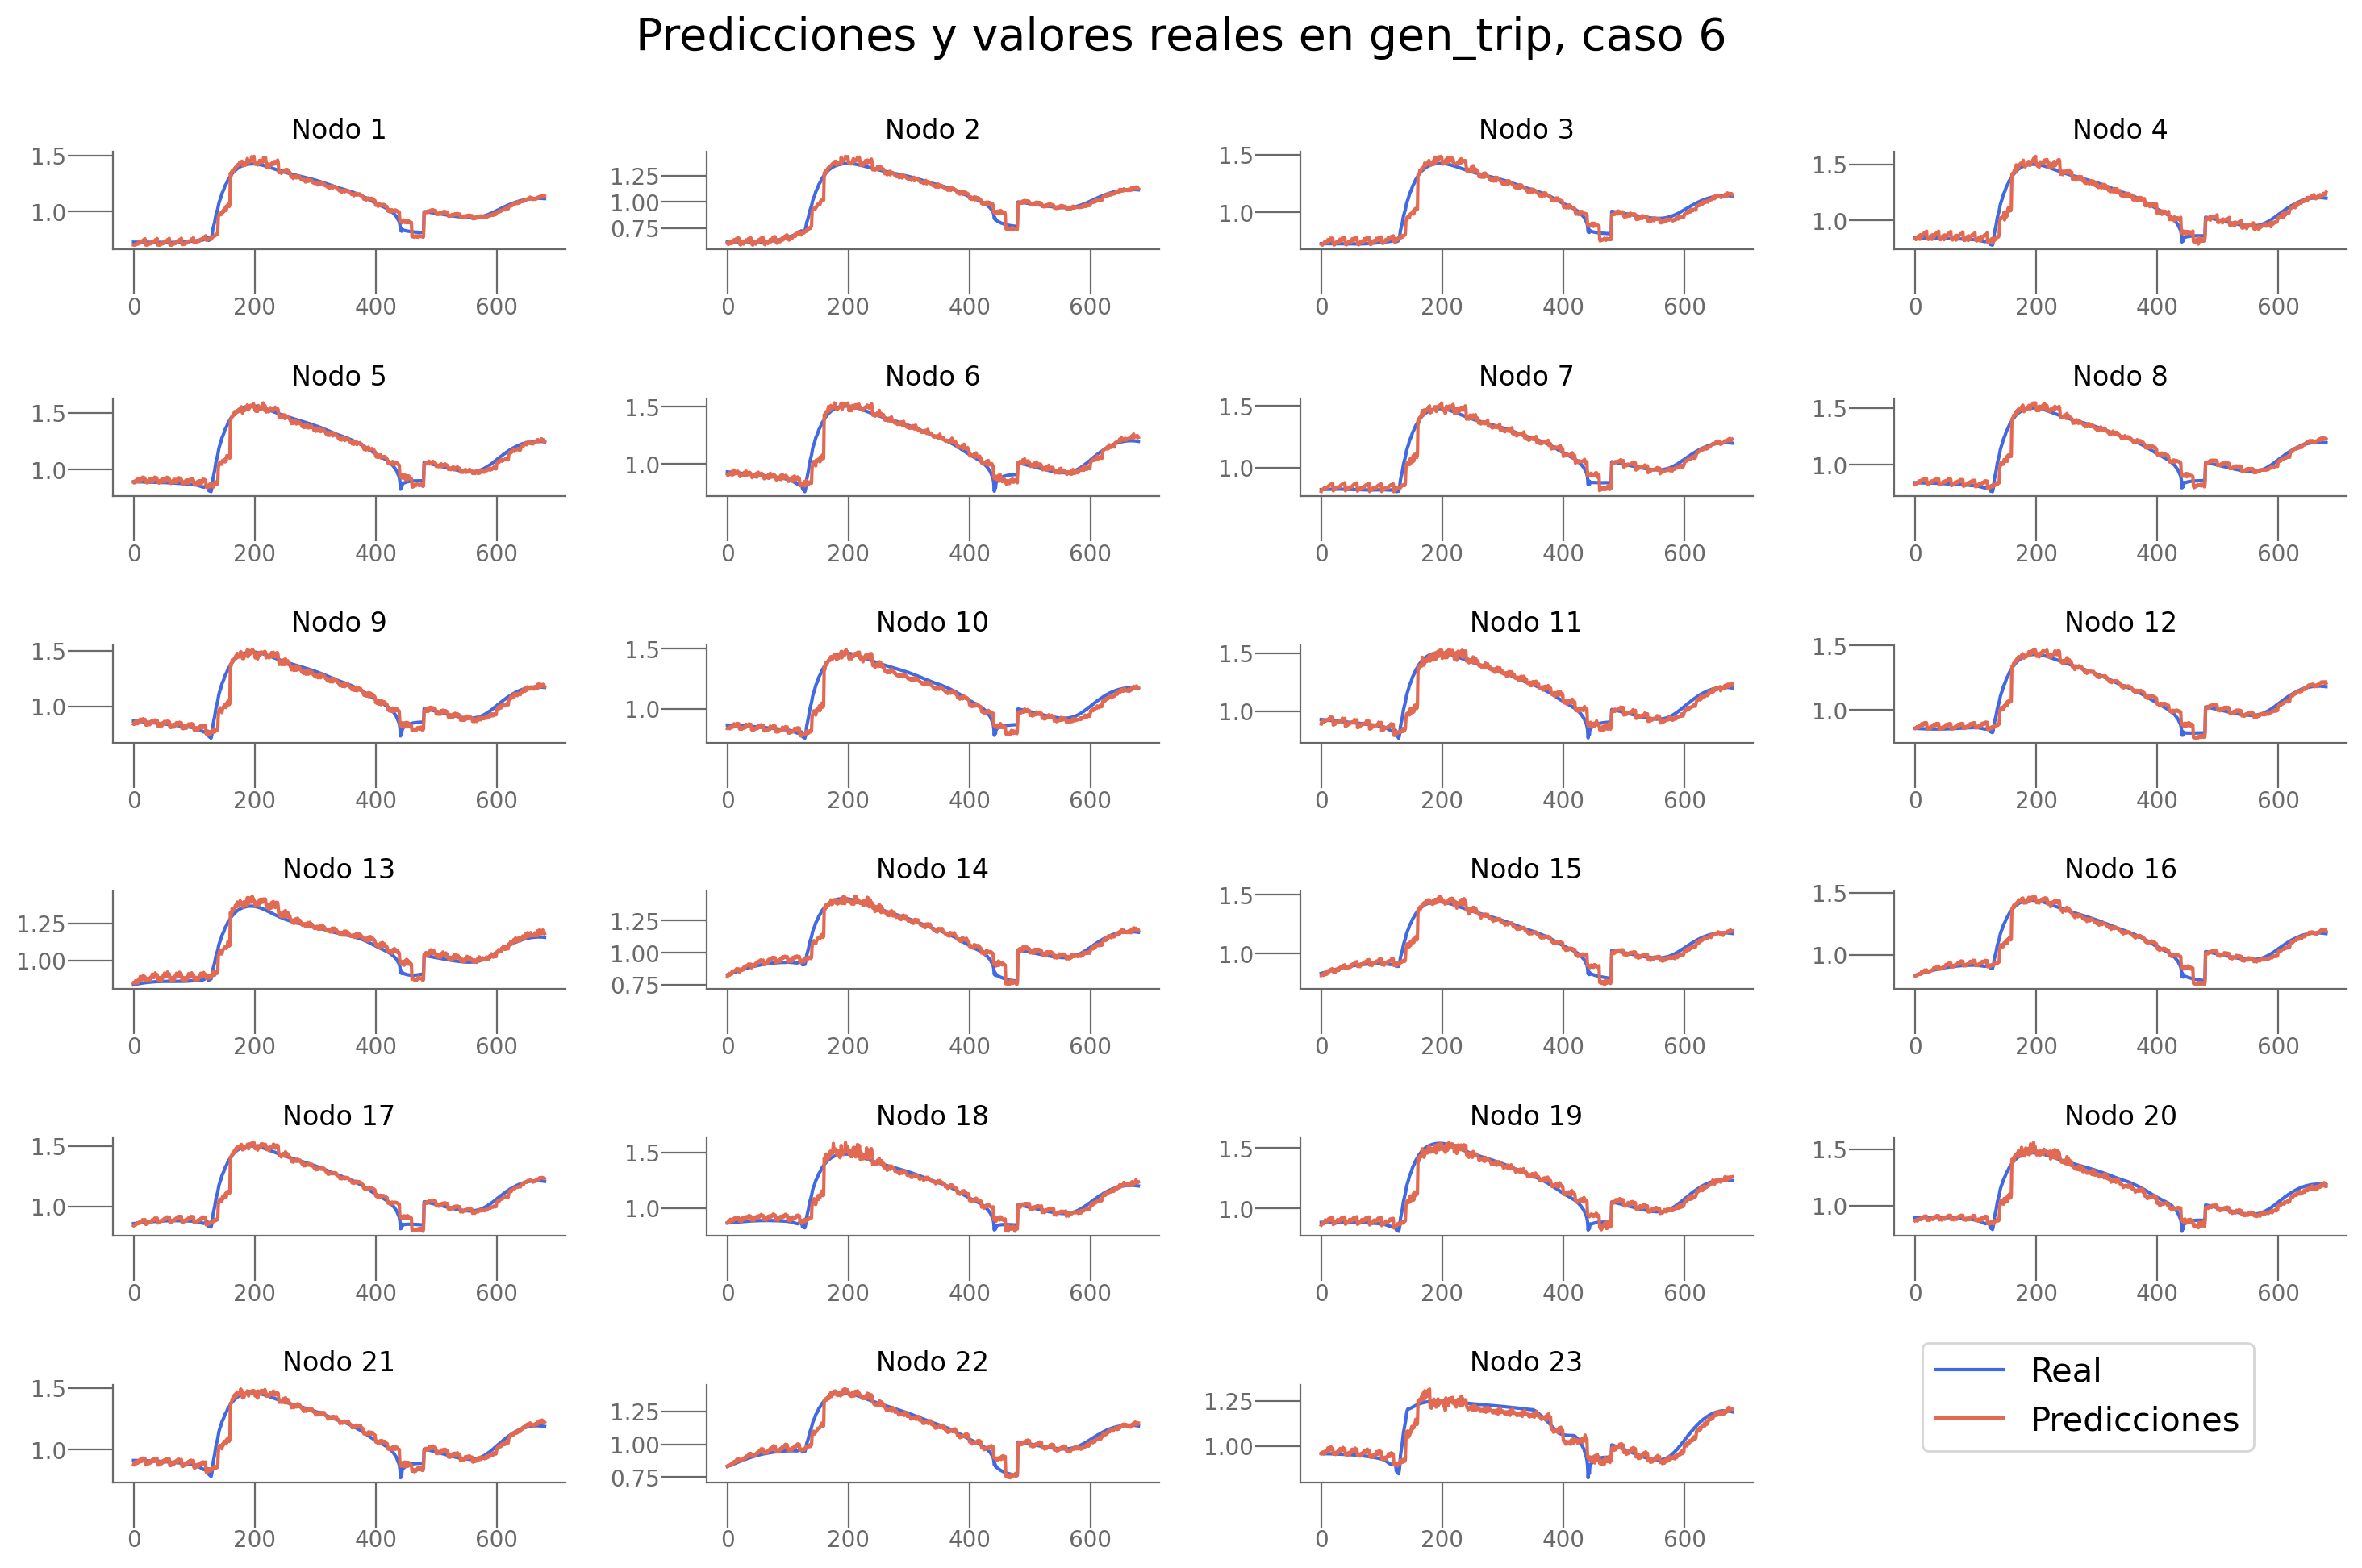

In [37]:
plot_predictions(predictions, real, n_target, 6, n_div_gt, problem_gt)

In [38]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)

In [39]:
trainer_gt.save_model(params=params_gt, path_save_experiment= path_save_experiment_gt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1     MPNN_LSTM                {'hidden_size': 16, 'dropout': 0.2}   
2  LSTM_NOBATCH                                                NaN   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.007638   0.204209   
1    ./results/gen_trip/ajustes/MPNNLSTM_results.csv  0.045889 -18.247558   
2                                                NaN  0.007437  -1.985579   
3  ./results/gen_trip/ajustes/DryGrEncoder_result...  0.006246  -1.204836   
4       ./results/gen_trip/ajustes/AGCRN_results.csv  0.0085

### Bus trip

In [10]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [11]:
n_div_bt = loader.div
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]


num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [12]:

device =  torch.device("cpu")
model_bt = RecurrentGCN(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)

trainer_bt = TrainerMSTGCN(model_bt, dataset_bt,device, f"./results/{problem_bt}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_bt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.3984 | Eval Loss: 0.2718 | Eval R2: -7.1887 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.2490 | Eval Loss: 0.2194 | Eval R2: -5.5917 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.2230 | Eval Loss: 0.2144 | Eval R2: -5.4394 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.2219 | Eval Loss: 0.1994 | Eval R2: -4.8970 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.2001 | Eval Loss: 0.1897 | Eval R2: -4.5734 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1978 | Eval Loss: 0.1898 | Eval R2: -4.5750 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1689 | Eval Loss: 0.1452 | Eval R2: -2.9278 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.1502 | Eval Loss: 0.1417 | Eval R2: -2.8185 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.1327 | Eval Loss: 0.1190 | Eval R2: -2.2451 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0.1099 | E

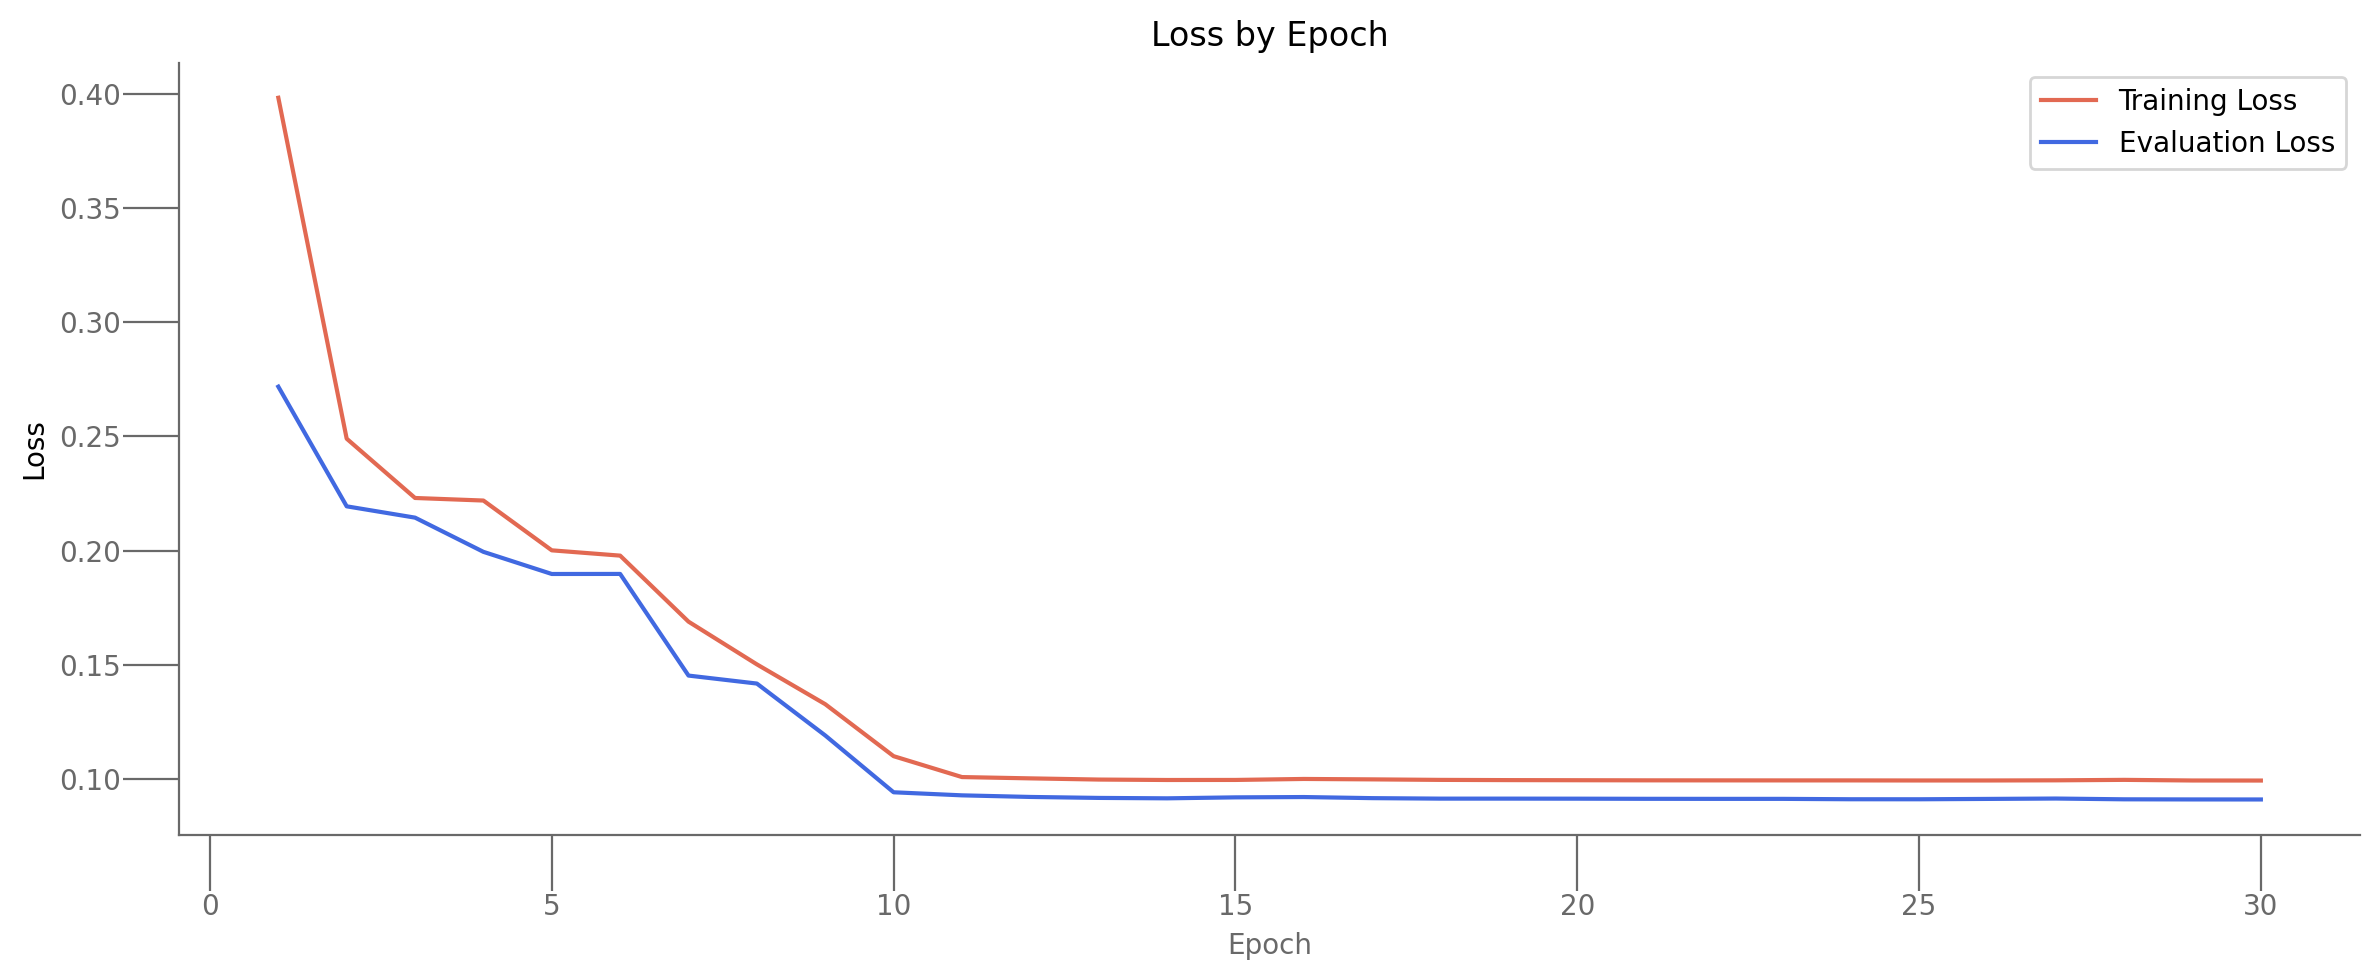


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.097667, test r2score -1.288585


In [13]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bt, real_bt = trainer_bt.test()

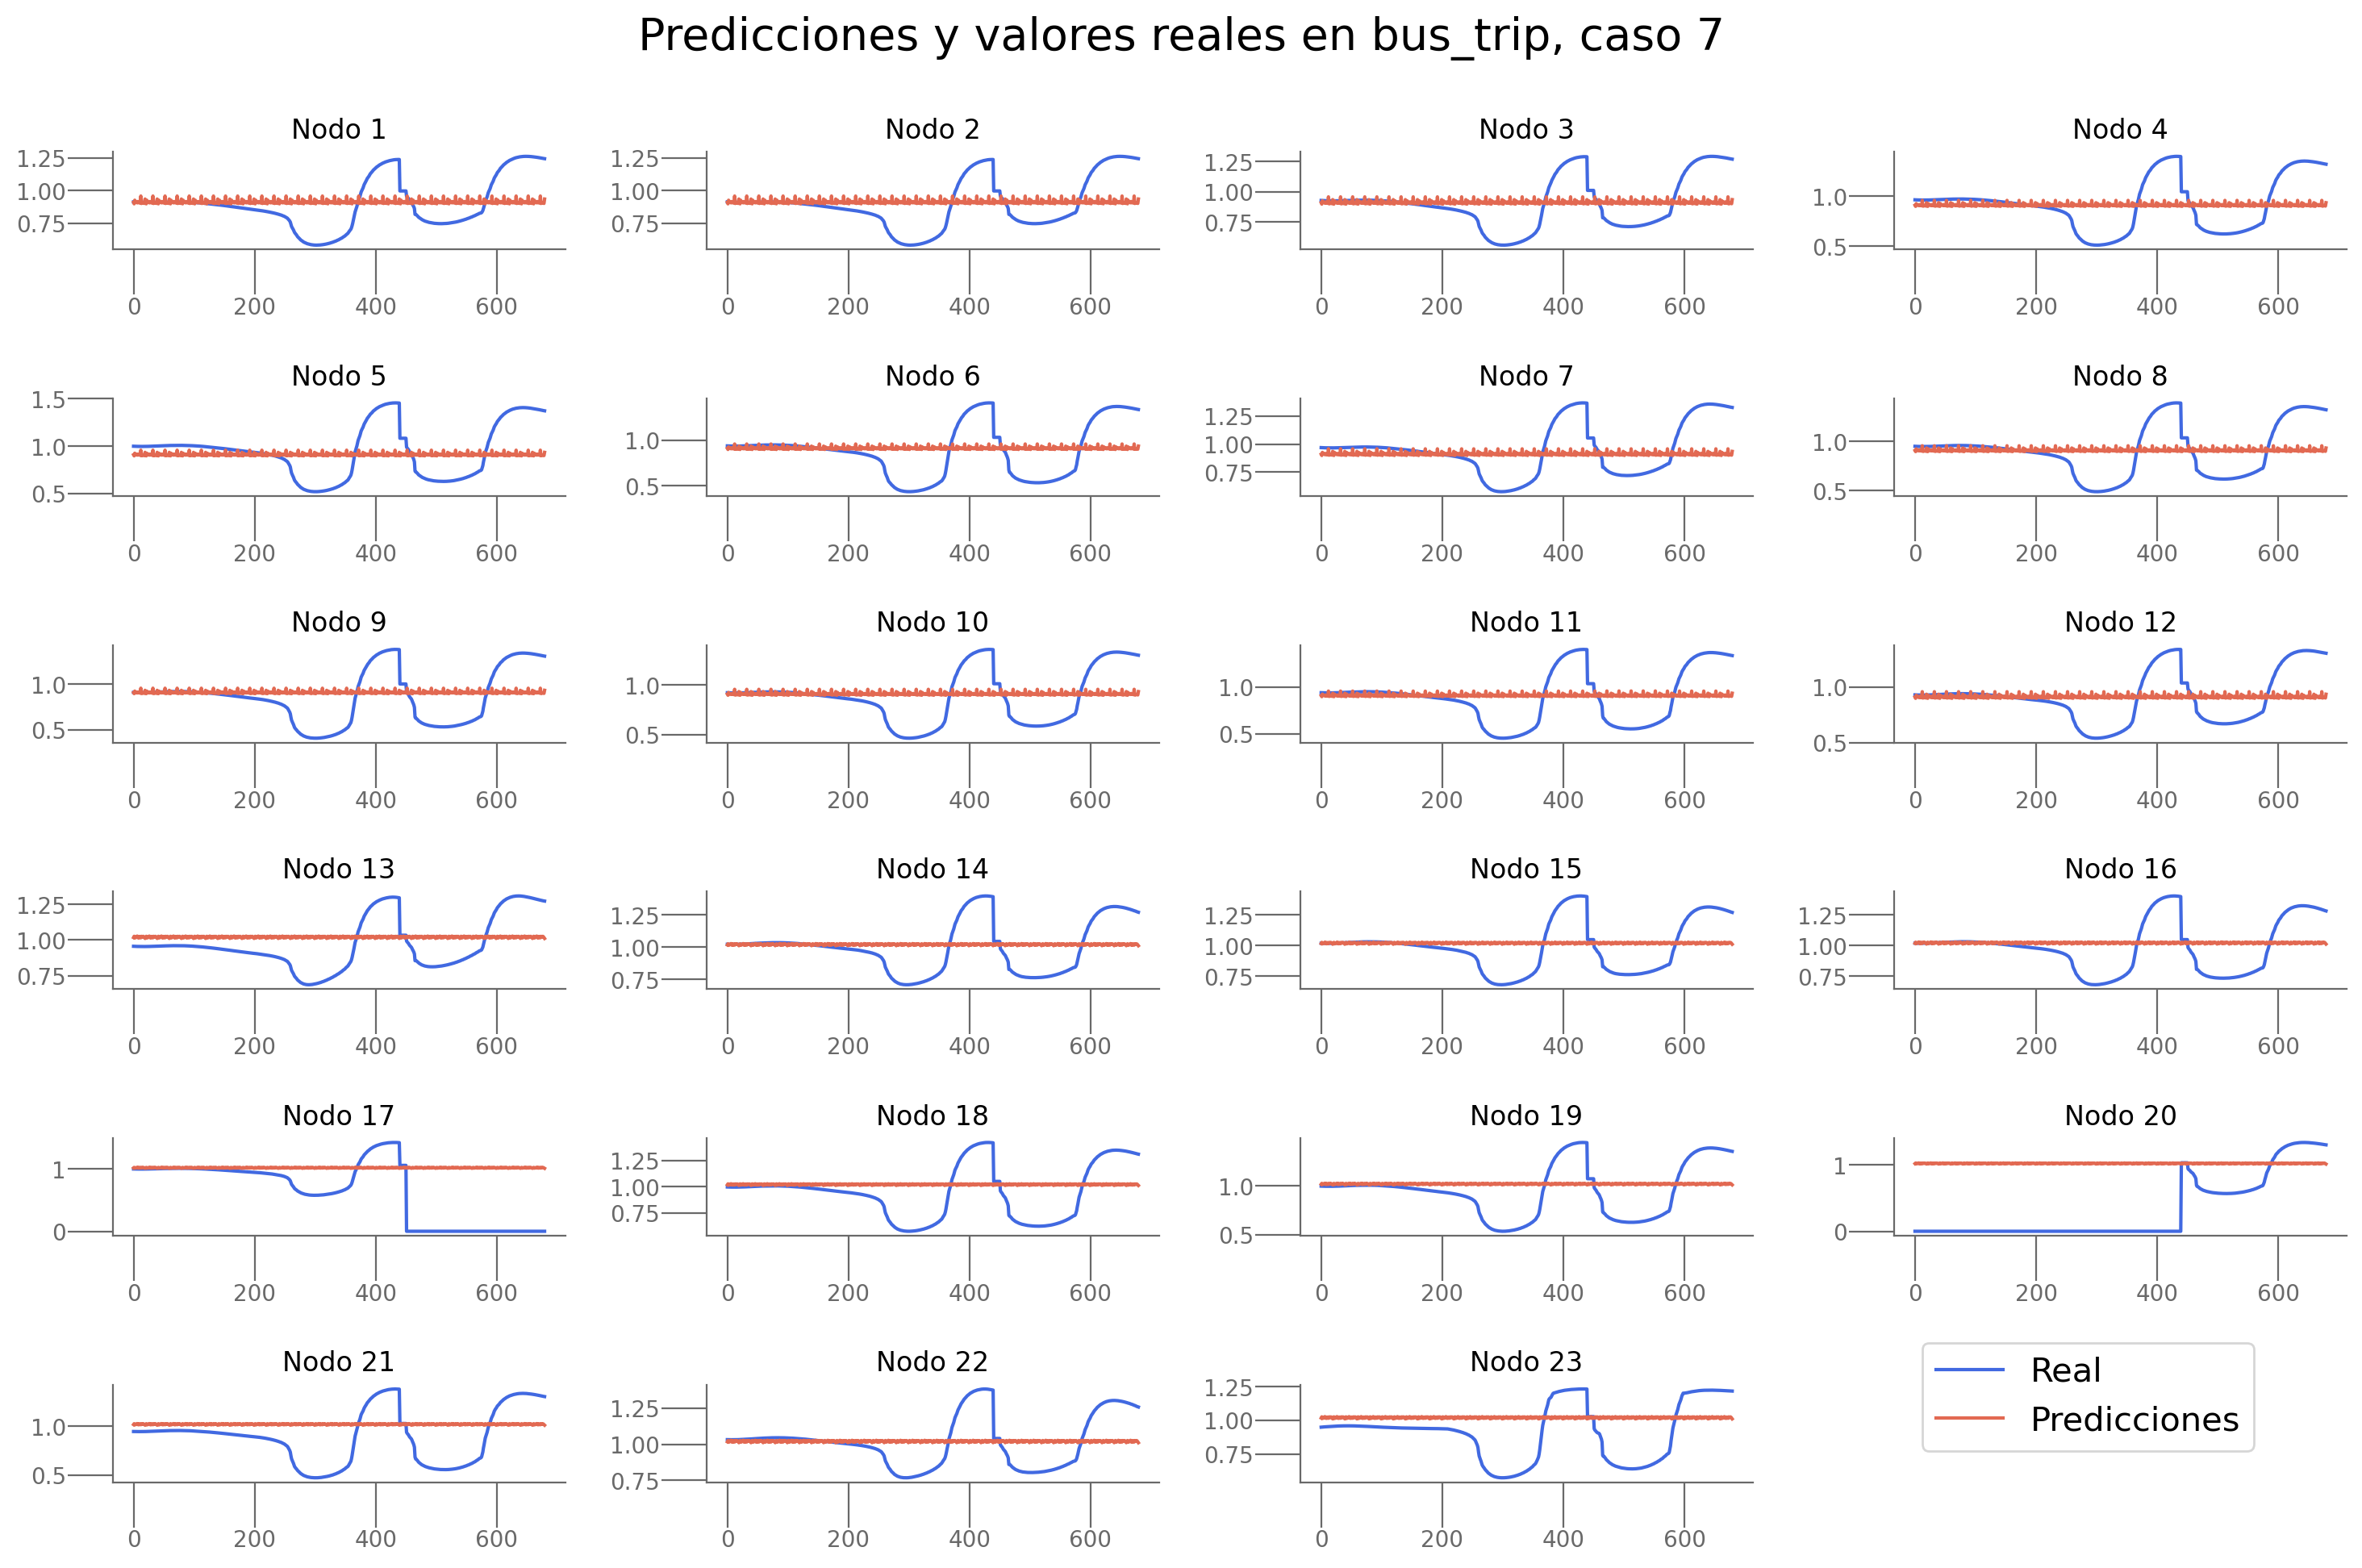

In [14]:
plot_predictions(predictions_bt, real_bt, n_target, 7, n_div_bt, problem_bt)

#### Ajuste de parámetros 

In [15]:

param_grid = {
    "nb_block": [1, 2, 3],
    "filter": [2,4,8],
    "time_strides": [1, 2, 4]
}

num_epochs = 100
num_early_stop = 10

trainer_bt,params_bt,resultados_final_bt, resultados_bt = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_bt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bt)

  0%|          | 0/27 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.5194 | Eval Loss: 0.3603 | Eval R2: -10.7100 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.3135 | Eval Loss: 0.2815 | Eval R2: -7.6142 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.2631 | Eval Loss: 0.2384 | Eval R2: -6.0764 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.2291 | Eval Loss: 0.2143 | Eval R2: -5.3517 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.2173 | Eval Loss: 0.2091 | Eval R2: -5.2528 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.2112 | Eval Loss: 0.2032 | Eval R2: -5.0698 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.2049 | Eval Loss: 0.1899 | Eval R2: -4.4916 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.1819 | Eval Loss: 0.1661 | Eval R2: -3.4568 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.1

  4%|▎         | 1/27 [03:03<1:19:20, 183.10s/it]

preds:  (1, 23, 20)
test loss: 0.083587, test r2score -1.065250
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.08587446063756943, 'r2_eval_final': -0.9306825995445251, 'loss_eval_final': 0.0797448679804802, 'r2_test': -1.0652504517164376, 'loss_test': 0.0835866779088974, 'loss_nodes': [[0.0844578966498375, 0.08231055736541748, 0.08118439465761185, 0.08359026163816452, 0.08471064269542694, 0.08407007157802582, 0.08191392570734024, 0.08173932135105133, 0.08233879506587982, 0.08414797484874725, 0.08200087398290634, 0.08395074307918549, 0.08425512164831161, 0.08372405916452408, 0.0834193155169487, 0.08387981355190277, 0.08568019419908524, 0.08514014631509781, 0.08619754016399384, 0.0830221101641655]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

=========

  7%|▋         | 2/27 [05:47<1:11:46, 172.25s/it]

preds:  (1, 23, 20)
test loss: 0.094949, test r2score -1.244543
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.09688711911439896, 'r2_eval_final': -1.004791259765625, 'loss_eval_final': 0.0911768451333046, 'r2_test': -1.2445425382173196, 'loss_test': 0.09494946151971817, 'loss_nodes': [[0.09345518052577972, 0.09398610889911652, 0.094599150121212, 0.09405717998743057, 0.09647807478904724, 0.0961548313498497, 0.0954272523522377, 0.09438323229551315, 0.09406717866659164, 0.09454914927482605, 0.09399187564849854, 0.09487713128328323, 0.0957239493727684, 0.09489581733942032, 0.094807930290699, 0.09469084441661835, 0.09549539536237717, 0.09641608595848083, 0.09569279104471207, 0.09523987770080566]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

=============

 11%|█         | 3/27 [08:31<1:07:22, 168.42s/it]

preds:  (1, 23, 20)
test loss: 0.095083, test r2score -1.230651
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.0971793681383133, 'r2_eval_final': -0.9829961657524109, 'loss_eval_final': 0.09114664793014526, 'r2_test': -1.230651362827158, 'loss_test': 0.09508313238620758, 'loss_nodes': [[0.0941876620054245, 0.09423122555017471, 0.0945798009634018, 0.09429564327001572, 0.09630462527275085, 0.09547877311706543, 0.09502894431352615, 0.09496331214904785, 0.0943039059638977, 0.09494730830192566, 0.0944184958934784, 0.09485050290822983, 0.09529221057891846, 0.09523613750934601, 0.09515441209077835, 0.09497169405221939, 0.09549546241760254, 0.09614084661006927, 0.09583625942468643, 0.09594506025314331]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==========

 15%|█▍        | 4/27 [11:33<1:06:37, 173.80s/it]

preds:  (1, 23, 20)
test loss: 0.058757, test r2score -0.894892
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.056963708251714706, 'r2_eval_final': -0.9483298063278198, 'loss_eval_final': 0.05835295096039772, 'r2_test': -0.8948918253947343, 'loss_test': 0.05875703692436218, 'loss_nodes': [[0.0037038535811007023, 0.004024996887892485, 0.003726628376170993, 0.0053907399997115135, 0.007855195552110672, 0.00545391533523798, 0.005350444465875626, 0.007542106322944164, 0.00677534518763423, 0.007985456846654415, 1.0007091760635376, 0.007574159186333418, 0.012241821736097336, 0.010890721343457699, 0.012505605816841125, 0.01461232639849186, 0.014200112782418728, 0.014460169710218906, 0.013305874541401863, 0.01683199405670166]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 4

 19%|█▊        | 5/27 [14:27<1:03:45, 173.89s/it]

preds:  (1, 23, 20)
test loss: 0.210446, test r2score -4.166198
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.21026736497879028, 'r2_eval_final': -6.001729965209961, 'loss_eval_final': 0.21453167498111725, 'r2_test': -4.166198303929596, 'loss_test': 0.2104456126689911, 'loss_nodes': [[0.9950371980667114, 0.006115637253969908, 0.006486313417553902, 0.007386890705674887, 0.017598018050193787, 0.010850457474589348, 0.008549349382519722, 0.009548456408083439, 0.008387506939470768, 0.01361186895519495, 0.010576421394944191, 0.014576628804206848, 0.028087185695767403, 0.015276609919965267, 1.000992774963379, 0.021678056567907333, 0.01567690819501877, 1.0011482238769531, 1.0014660358428955, 0.015861762687563896]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

 22%|██▏       | 6/27 [17:13<59:54, 171.19s/it]  

preds:  (1, 23, 20)
test loss: 0.160010, test r2score -4.008371
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.15897084772586823, 'r2_eval_final': -4.5700860023498535, 'loss_eval_final': 0.16226457059383392, 'r2_test': -4.00837123770611, 'loss_test': 0.16000980138778687, 'loss_nodes': [[0.007262396160513163, 0.007034727372229099, 0.007700507529079914, 0.007374876644462347, 0.009212884120643139, 0.009710883721709251, 0.009968043304979801, 0.008902756497263908, 0.9981412887573242, 0.010164907202124596, 1.0007091760635376, 0.010154963470995426, 1.0016831159591675, 0.012812893837690353, 0.015228496864438057, 0.014978035353124142, 0.013728626072406769, 0.018697932362556458, 0.018411191180348396, 0.018319372087717056]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQ

 26%|██▌       | 7/27 [20:47<1:01:45, 185.25s/it]

preds:  (1, 23, 20)
test loss: 0.309804, test r2score -7.881274
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.3091505765914917, 'r2_eval_final': -10.381593704223633, 'loss_eval_final': 0.31662362813949585, 'r2_test': -7.881274057222725, 'loss_test': 0.3098040223121643, 'loss_nodes': [[0.011356349103152752, 0.010146462358534336, 0.9965859055519104, 0.013258381746709347, 0.012151506729424, 0.010511741042137146, 0.007259305566549301, 0.012384973466396332, 0.9981412887573242, 0.009195680730044842, 1.0007091760635376, 0.015157832764089108, 1.0016831159591675, 0.015959763899445534, 1.000992774963379, 1.0022199153900146, 0.022590821608901024, 0.015942879021167755, 0.01974235661327839, 0.020090963691473007]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

====

 30%|██▉       | 8/27 [23:55<58:53, 185.98s/it]  

preds:  (1, 23, 20)
test loss: 0.207438, test r2score -4.723638
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.207083597779274, 'r2_eval_final': -6.3643479347229, 'loss_eval_final': 0.21247796714305878, 'r2_test': -4.723637827296536, 'loss_test': 0.20743802189826965, 'loss_nodes': [[0.004497334361076355, 0.006769849453121424, 0.00556284049525857, 0.004828896839171648, 0.005998262669891119, 0.00650501623749733, 0.9972070455551147, 0.006518703419715166, 0.007347214967012405, 0.007263642270117998, 1.0007091760635376, 0.009392587468028069, 0.0094364695250988, 1.0003013610839844, 0.010533859953284264, 1.0022199153900146, 0.01324151549488306, 0.013356970623135567, 0.020925866439938545, 0.01614382490515709]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

====

 33%|███▎      | 9/27 [26:45<54:16, 180.92s/it]

preds:  (1, 23, 20)
test loss: 0.011220, test r2score 0.747580
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.008170435205101967, 'r2_eval_final': 0.7947038412094116, 'loss_eval_final': 0.009145247749984264, 'r2_test': 0.7475804796525073, 'loss_test': 0.01121991965919733, 'loss_nodes': [[0.007950985804200172, 0.0064830482006073, 0.009144626557826996, 0.006910938769578934, 0.00681412685662508, 0.006000876426696777, 0.009352978318929672, 0.007698386441916227, 0.010198754258453846, 0.010296148248016834, 0.015203929506242275, 0.010924073867499828, 0.011606262065470219, 0.012655594386160374, 0.0123988576233387, 0.012396002188324928, 0.017211027443408966, 0.01723206602036953, 0.015793250873684883, 0.018126485869288445]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
A

 37%|███▋      | 10/27 [32:48<1:07:13, 237.29s/it]

preds:  (1, 23, 20)
test loss: 0.230602, test r2score -5.378908
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.23360542953014374, 'r2_eval_final': -6.655799865722656, 'loss_eval_final': 0.2314397394657135, 'r2_test': -5.378908356963275, 'loss_test': 0.2306017428636551, 'loss_nodes': [[0.09420529752969742, 0.9968317747116089, 0.09454021602869034, 0.09450459480285645, 0.09610961377620697, 0.995732307434082, 0.0950784981250763, 0.09497926384210587, 0.09426847845315933, 0.09489016979932785, 0.09437097609043121, 0.09492576122283936, 0.09530741721391678, 0.09521787613630295, 0.09510895609855652, 1.0022199153900146, 0.09568987041711807, 0.0960984081029892, 0.09597752243280411, 0.09597880393266678]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==============

 41%|████      | 11/27 [38:03<1:09:36, 261.01s/it]

preds:  (1, 23, 20)
test loss: 0.140198, test r2score -2.812794
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.14258123934268951, 'r2_eval_final': -3.248800039291382, 'loss_eval_final': 0.1377287209033966, 'r2_test': -2.81279387956817, 'loss_test': 0.14019803702831268, 'loss_nodes': [[0.9950371980667114, 0.0943141058087349, 0.09466291964054108, 0.09433276951313019, 0.09615273028612137, 0.09586118906736374, 0.09497394412755966, 0.09505908191204071, 0.09424041211605072, 0.09492455422878265, 0.09447711706161499, 0.09462780505418777, 0.09525005519390106, 0.09535617381334305, 0.09542375802993774, 0.09539762884378433, 0.09568609297275543, 0.09614278376102448, 0.0961427167057991, 0.09589781612157822]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

===========

 44%|████▍     | 12/27 [42:58<1:07:48, 271.23s/it]

preds:  (1, 23, 20)
test loss: 0.366695, test r2score -8.633490
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.37020137906074524, 'r2_eval_final': -10.246828079223633, 'loss_eval_final': 0.37297767400741577, 'r2_test': -8.633489506919293, 'loss_test': 0.3666950762271881, 'loss_nodes': [[0.09413685649633408, 0.09439683705568314, 0.09522301703691483, 0.995595395565033, 0.09618150442838669, 0.09552699327468872, 0.09487275779247284, 0.09525003284215927, 0.9981412887573242, 0.09564200043678284, 0.09457496553659439, 1.0007410049438477, 0.09538394212722778, 0.09559822082519531, 1.000992774963379, 0.09503645449876785, 1.0023812055587769, 0.09624552726745605, 0.09635599702596664, 1.0016250610351562]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==============

 48%|████▊     | 13/27 [49:07<1:10:11, 300.84s/it]

preds:  (1, 23, 20)
test loss: 0.160564, test r2score -3.712778
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.15984639525413513, 'r2_eval_final': -4.2206621170043945, 'loss_eval_final': 0.16248951852321625, 'r2_test': -3.712778173272046, 'loss_test': 0.1605638563632965, 'loss_nodes': [[0.00842057354748249, 0.009884392842650414, 0.0063555617816746235, 0.995595395565033, 0.9945205450057983, 0.0075312028639018536, 0.009642127901315689, 0.008899614214897156, 0.010078895837068558, 0.011458327062427998, 0.014855954796075821, 0.012466725893318653, 0.016782615333795547, 0.014890674501657486, 0.013933305628597736, 0.015072652138769627, 0.019660597667098045, 1.0011482238769531, 0.02169371023774147, 0.018386216834187508]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQu

 52%|█████▏    | 14/27 [54:33<1:06:52, 308.68s/it]

preds:  (1, 23, 20)
test loss: 0.160035, test r2score -3.381310
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.15923859179019928, 'r2_eval_final': -4.61883020401001, 'loss_eval_final': 0.16179907321929932, 'r2_test': -3.3813099212075644, 'loss_test': 0.16003462672233582, 'loss_nodes': [[0.00794140249490738, 0.008995642885565758, 0.008918044157326221, 0.006842377129942179, 0.008208627812564373, 0.009623545221984386, 0.00927042681723833, 0.9989206790924072, 0.011336497031152248, 0.011684203520417213, 0.0100938705727458, 0.011458165943622589, 1.0016831159591675, 0.013463175855576992, 0.013373367488384247, 1.0022199153900146, 0.01590275578200817, 0.01639452949166298, 0.01711404323577881, 0.017248673364520073]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss


 56%|█████▌    | 15/27 [59:32<1:01:07, 305.59s/it]

preds:  (1, 23, 20)
test loss: 0.111617, test r2score -2.030663
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.1095854714512825, 'r2_eval_final': -2.3332037925720215, 'loss_eval_final': 0.1127319484949112, 'r2_test': -2.0306627910256743, 'loss_test': 0.11161699146032333, 'loss_nodes': [[0.009188352152705193, 0.005317395087331533, 0.007012136746197939, 0.0107620470225811, 0.010707952082157135, 0.011357379145920277, 0.00807593297213316, 0.008980453945696354, 0.012308197095990181, 0.9991567730903625, 0.012430962175130844, 0.018426278606057167, 0.013748262077569962, 0.015141546726226807, 0.014913363382220268, 0.01494713593274355, 0.02016513980925083, 0.019341910257935524, 1.0014660358428955, 0.018893446773290634]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuis

 59%|█████▉    | 16/27 [1:06:39<1:02:44, 342.23s/it]

preds:  (1, 23, 20)
test loss: 0.210118, test r2score -4.811145
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.20822139084339142, 'r2_eval_final': -7.377199172973633, 'loss_eval_final': 0.21463723480701447, 'r2_test': -4.811145061083621, 'loss_test': 0.21011778712272644, 'loss_nodes': [[0.9950371980667114, 0.014002925716340542, 0.9965859055519104, 0.00730251707136631, 0.00696179224178195, 0.006648618262261152, 0.012901817448437214, 0.007749238051474094, 0.015936890617012978, 0.008402237668633461, 0.014131416566669941, 0.01139267347753048, 0.015886960551142693, 1.0003013610839844, 0.018623249605298042, 1.0022199153900146, 0.016368990764021873, 0.01628717966377735, 0.017321884632110596, 0.01829315908253193]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss


 63%|██████▎   | 17/27 [1:12:42<58:05, 348.57s/it]  

preds:  (1, 23, 20)
test loss: 0.007690, test r2score 0.820904
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.005874165799468756, 'r2_eval_final': 0.8419707417488098, 'loss_eval_final': 0.006998170167207718, 'r2_test': 0.8209036698328822, 'loss_test': 0.007689703721553087, 'loss_nodes': [[0.002957133809104562, 0.004182383418083191, 0.003564986167475581, 0.004364190623164177, 0.004377908073365688, 0.005382361356168985, 0.0059345196932554245, 0.0057929209433496, 0.006563508417457342, 0.006194216199219227, 0.006712037138640881, 0.008825874887406826, 0.008366815745830536, 0.010119711048901081, 0.009679519571363926, 0.011794555932283401, 0.011145569384098053, 0.011837727390229702, 0.012660556472837925, 0.01333760004490614]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 

 67%|██████▋   | 18/27 [1:18:03<51:00, 340.06s/it]

preds:  (1, 23, 20)
test loss: 0.108773, test r2score -2.597869
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.10787573456764221, 'r2_eval_final': -3.343933582305908, 'loss_eval_final': 0.11091069132089615, 'r2_test': -2.5978687207555424, 'loss_test': 0.10877339541912079, 'loss_nodes': [[0.9950371980667114, 0.006593430880457163, 0.00681007094681263, 0.005818738602101803, 0.008140298537909985, 0.007022859528660774, 0.006608719006180763, 0.007403776049613953, 0.9981412887573242, 0.008878416381776333, 0.007843938656151295, 0.011240478605031967, 0.009050745517015457, 0.011914714239537716, 0.01201634667813778, 0.015869509428739548, 0.011878279969096184, 0.015157447196543217, 0.014164148829877377, 0.01587836630642414]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQ

 70%|███████   | 19/27 [1:27:25<54:13, 406.74s/it]

preds:  (1, 23, 20)
test loss: 0.185372, test r2score -4.447003
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.18888555467128754, 'r2_eval_final': -4.98411226272583, 'loss_eval_final': 0.18460829555988312, 'r2_test': -4.447003174871013, 'loss_test': 0.18537244200706482, 'loss_nodes': [[0.9950371980667114, 0.09424614161252975, 0.09447301924228668, 0.09496895223855972, 0.09737078845500946, 0.09685011208057404, 0.09504915028810501, 0.09642605483531952, 0.09294863790273666, 0.9991567730903625, 0.09515208750963211, 0.0939612090587616, 0.09402149170637131, 0.09617890417575836, 0.09533300995826721, 0.09504348039627075, 0.09458552300930023, 0.09566350281238556, 0.09597320854663849, 0.09501016139984131]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==========

 74%|███████▍  | 20/27 [1:35:08<49:24, 423.56s/it]

preds:  (1, 23, 20)
test loss: 0.321181, test r2score -8.581351
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.3249431848526001, 'r2_eval_final': -10.077146530151367, 'loss_eval_final': 0.3247809410095215, 'r2_test': -8.581350868302572, 'loss_test': 0.3211805820465088, 'loss_nodes': [[0.9950371980667114, 0.09425431489944458, 0.09459399431943893, 0.995595395565033, 0.09639541059732437, 0.09555839747190475, 0.0950455591082573, 0.094927579164505, 0.09448014199733734, 0.09492692351341248, 1.0007091760635376, 1.0007410049438477, 1.0016831159591675, 0.09529221057891846, 0.09516651183366776, 0.09508221596479416, 0.09573057293891907, 0.09629011154174805, 0.09601229429244995, 0.09608941525220871]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

=================

 78%|███████▊  | 21/27 [1:42:12<42:23, 423.90s/it]

preds:  (1, 23, 20)
test loss: 0.140364, test r2score -2.821289
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.14247985184192657, 'r2_eval_final': -2.7366905212402344, 'loss_eval_final': 0.13820727169513702, 'r2_test': -2.8212893742817107, 'loss_test': 0.14036361873149872, 'loss_nodes': [[0.09408939629793167, 0.09512071311473846, 0.09463544189929962, 0.09480879455804825, 0.09635575115680695, 0.09551212936639786, 0.997199535369873, 0.09493210911750793, 0.09425389766693115, 0.09602195024490356, 0.09445015341043472, 0.0946781262755394, 0.09568910300731659, 0.09526335448026657, 0.09510588645935059, 0.09494773298501968, 0.09555649757385254, 0.09623328596353531, 0.09591592103242874, 0.09650261700153351]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

=======

 81%|████████▏ | 22/27 [1:51:30<38:40, 464.01s/it]

preds:  (1, 23, 20)
test loss: 0.060908, test r2score -0.326981
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.05965009704232216, 'r2_eval_final': -0.5297123789787292, 'loss_eval_final': 0.06057309731841087, 'r2_test': -0.3269808594509737, 'loss_test': 0.06090761721134186, 'loss_nodes': [[0.0067578768357634544, 0.007226740475744009, 0.009634876623749733, 0.0070153484120965, 0.008879930712282658, 0.00848896149545908, 0.009476004168391228, 0.009478979744017124, 0.008490252308547497, 0.01051353383809328, 0.010656269267201424, 0.011567401699721813, 0.01360657811164856, 0.013088075444102287, 0.015258241444826126, 0.017044156789779663, 0.01593920774757862, 0.016672790050506592, 0.016731850802898407, 1.0016250610351562]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
A

 85%|████████▌ | 23/27 [1:59:31<31:16, 469.14s/it]

preds:  (1, 23, 20)
test loss: 0.066165, test r2score -1.058392
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06417713314294815, 'r2_eval_final': -1.2086350917816162, 'loss_eval_final': 0.06662137061357498, 'r2_test': -1.0583920117994734, 'loss_test': 0.06616495549678802, 'loss_nodes': [[0.016548437997698784, 0.016265178099274635, 0.015468645840883255, 0.01321402471512556, 0.013206773437559605, 0.995732307434082, 0.01271302904933691, 0.011663478799164295, 0.015907220542430878, 0.012698506005108356, 0.01503483671694994, 0.016413934528827667, 0.017310146242380142, 0.017499880865216255, 0.017156219109892845, 0.016328785568475723, 0.0241836030036211, 0.025898216292262077, 0.024488238617777824, 0.025567609816789627]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQ

 89%|████████▉ | 24/27 [2:06:55<23:05, 461.72s/it]

preds:  (1, 23, 20)
test loss: 0.017475, test r2score 0.606400
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.01424233615398407, 'r2_eval_final': 0.65397709608078, 'loss_eval_final': 0.014850184321403503, 'r2_test': 0.6064004443840622, 'loss_test': 0.017475364729762077, 'loss_nodes': [[0.012747665867209435, 0.010093244723975658, 0.01215966697782278, 0.01331393327564001, 0.01389865018427372, 0.014856214635074139, 0.016914179548621178, 0.015209343284368515, 0.014130049385130405, 0.014956596307456493, 0.017111003398895264, 0.02077871561050415, 0.017870446667075157, 0.019069183617830276, 0.020374707877635956, 0.023631565272808075, 0.021905841305851936, 0.02532474882900715, 0.022060053423047066, 0.023101503029465675]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQ

 93%|█████████▎| 25/27 [2:17:58<17:23, 521.97s/it]

preds:  (1, 23, 20)
test loss: 0.112632, test r2score -2.066223
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.10952229052782059, 'r2_eval_final': -2.867553472518921, 'loss_eval_final': 0.11503937095403671, 'r2_test': -2.0662229148456706, 'loss_test': 0.11263178288936615, 'loss_nodes': [[0.007834183052182198, 0.01001461036503315, 0.009892578236758709, 0.011178676038980484, 0.010137155652046204, 0.012329978868365288, 0.011902828700840473, 0.01453228760510683, 0.013424786739051342, 0.012801161035895348, 1.0007091760635376, 0.016323136165738106, 0.014805071987211704, 1.0003013610839844, 0.01741540990769863, 0.01629447750747204, 0.018537068739533424, 0.016776077449321747, 0.02001812867820263, 0.01740744337439537]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuis

 96%|█████████▋| 26/27 [2:27:10<08:50, 531.00s/it]

preds:  (1, 23, 20)
test loss: 0.109413, test r2score -1.375507
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.10766277462244034, 'r2_eval_final': -1.8366050720214844, 'loss_eval_final': 0.11153092980384827, 'r2_test': -1.3755074978612465, 'loss_test': 0.10941319167613983, 'loss_nodes': [[0.005124269053339958, 0.009032386355102062, 0.006278704386204481, 0.00897199846804142, 0.007266611326485872, 0.008243809454143047, 0.00911314133554697, 0.00987156666815281, 0.010087108239531517, 0.009452158585190773, 0.009946606121957302, 0.0125327929854393, 0.01115864235907793, 0.012417972087860107, 0.01189441792666912, 0.01404094509780407, 0.015291661024093628, 1.0011482238769531, 1.0014660358428955, 0.01492516603320837]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuisss

100%|██████████| 27/27 [2:35:02<00:00, 344.54s/it]

preds:  (1, 23, 20)
test loss: 0.210408, test r2score -5.404077
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.20992140471935272, 'r2_eval_final': -7.355807781219482, 'loss_eval_final': 0.2143191397190094, 'r2_test': -5.404077325432622, 'loss_test': 0.21040797233581543, 'loss_nodes': [[0.006925579160451889, 0.9968317747116089, 0.9965815544128418, 0.007989263162016869, 0.009721245616674423, 0.009023929014801979, 0.9972070455551147, 0.013141817413270473, 0.011891311034560204, 0.012152433395385742, 0.011722124181687832, 0.012480448931455612, 0.015400097705423832, 0.014038138091564178, 1.000992774963379, 0.01679086871445179, 0.017491508275270462, 0.016809042543172836, 0.018254661932587624, 0.02271367609500885]]}


In [16]:
_, _, _, predictions_bt_ajuste, real_bt_ajuste = trainer_bt.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.007690, test r2score 0.820904


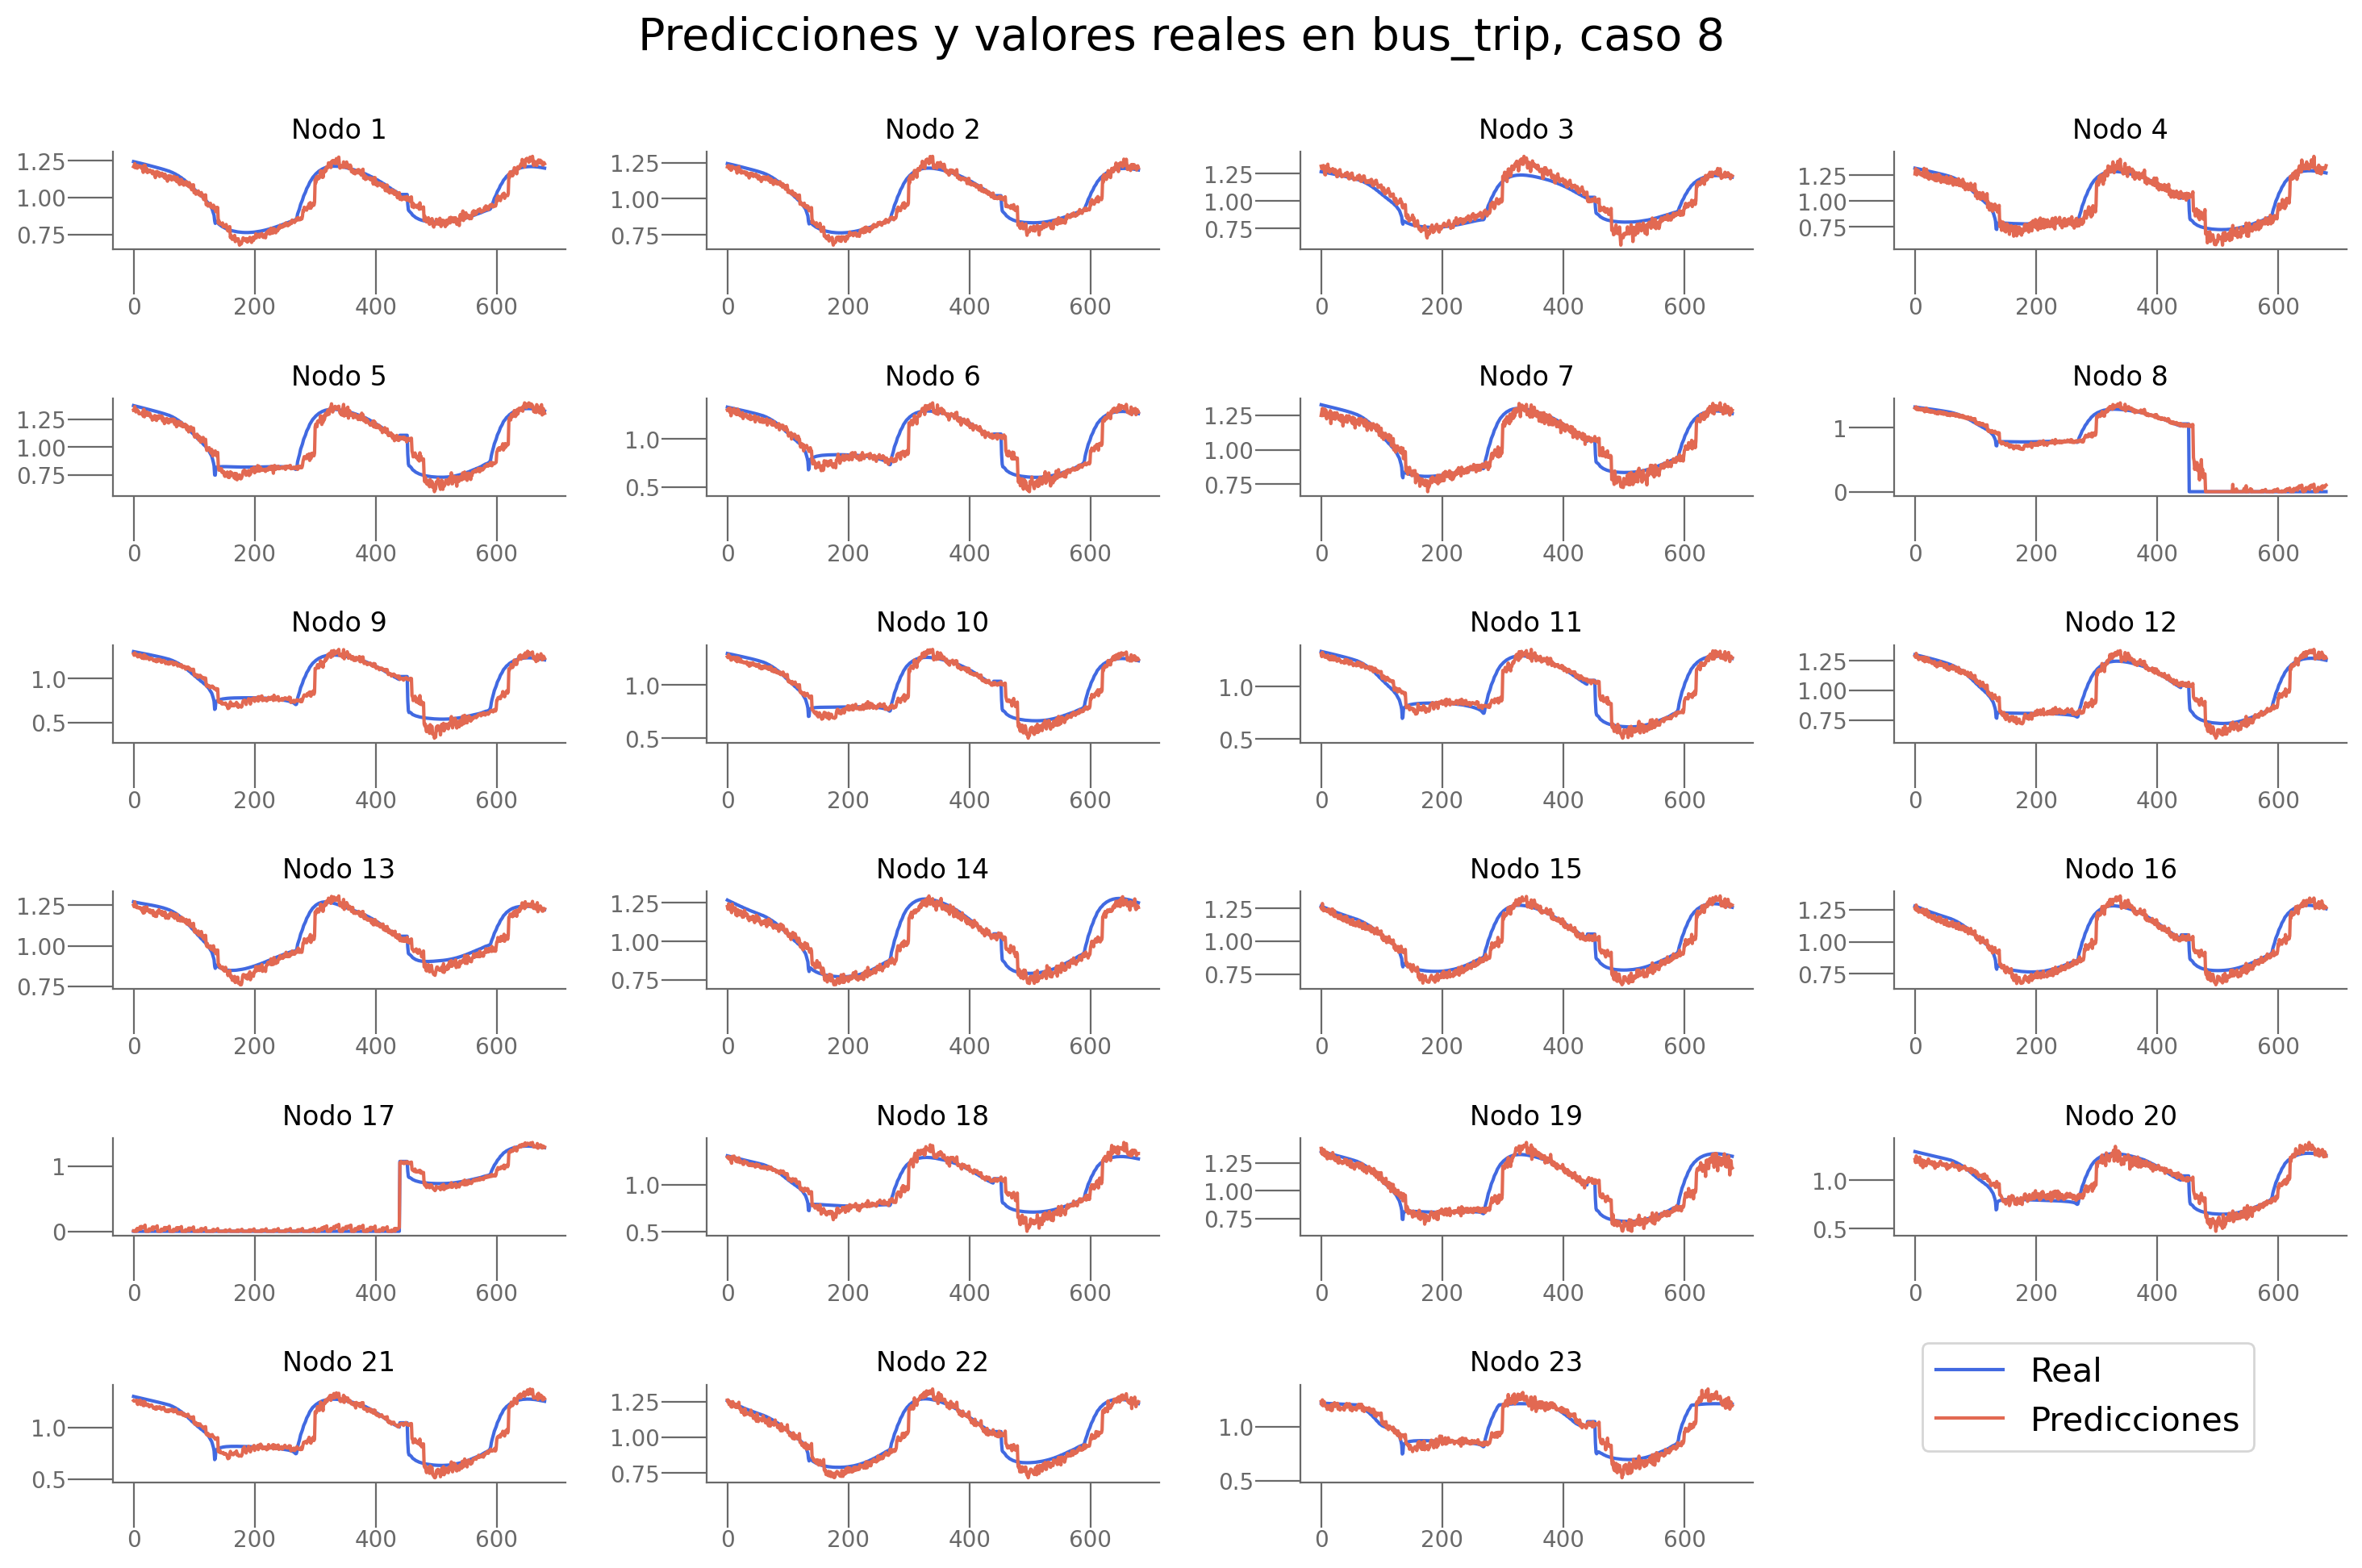

In [17]:
plot_predictions(predictions_bt_ajuste, real_bt_ajuste, n_target, 8, n_div_bt, problem_bt)

In [18]:
path_save_experiment_bt = results_save_path+f"/{problem_bt}"+ f"/ajustes/{name_model}_results.csv"
resultados_bt.to_csv(path_save_experiment_bt, index=False)

In [19]:
trainer_bt.save_model(path_save_experiment=path_save_experiment_bt, params=params_bt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                                          (32, 0.8)   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.005474  0.923150   
1                                                NaN  0.005606  0.865487   
2    ./results/bus_trip/ajustes/MPNNLSTM_results.csv  0.006753  0.845855   
3  ./results/bus_trip/ajustes/DryGrEncoder_result...  0.005348  0.827431   
4       ./results/bus_trip/ajustes/AGCRN_results.csv  0.010180  0

### Bus fault

In [20]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [21]:
n_div_bf = loader.div
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [22]:

device =  torch.device("cpu")
model_bf = RecurrentGCN(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)


trainer_bf = TrainerMSTGCN(model_bf, dataset_bf,device, f"./results/{problem_bf}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_bf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2159 | Eval Loss: 0.1899 | Eval R2: -34.7876 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.1825 | Eval Loss: 0.1888 | Eval R2: -35.0943 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.1822 | Eval Loss: 0.1889 | Eval R2: -34.9157 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.1822 | Eval Loss: 0.1889 | Eval R2: -34.8691 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.1822 | Eval Loss: 0.1888 | Eval R2: -34.8931 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1821 | Eval Loss: 0.1888 | Eval R2: -34.9587 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1821 | Eval Loss: 0.1887 | Eval R2: -35.0433 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.1821 | Eval Loss: 0.1886 | Eval R2: -35.1399 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.1820 | Eval Loss: 0.1885 | Eval R2: -35.2418 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0

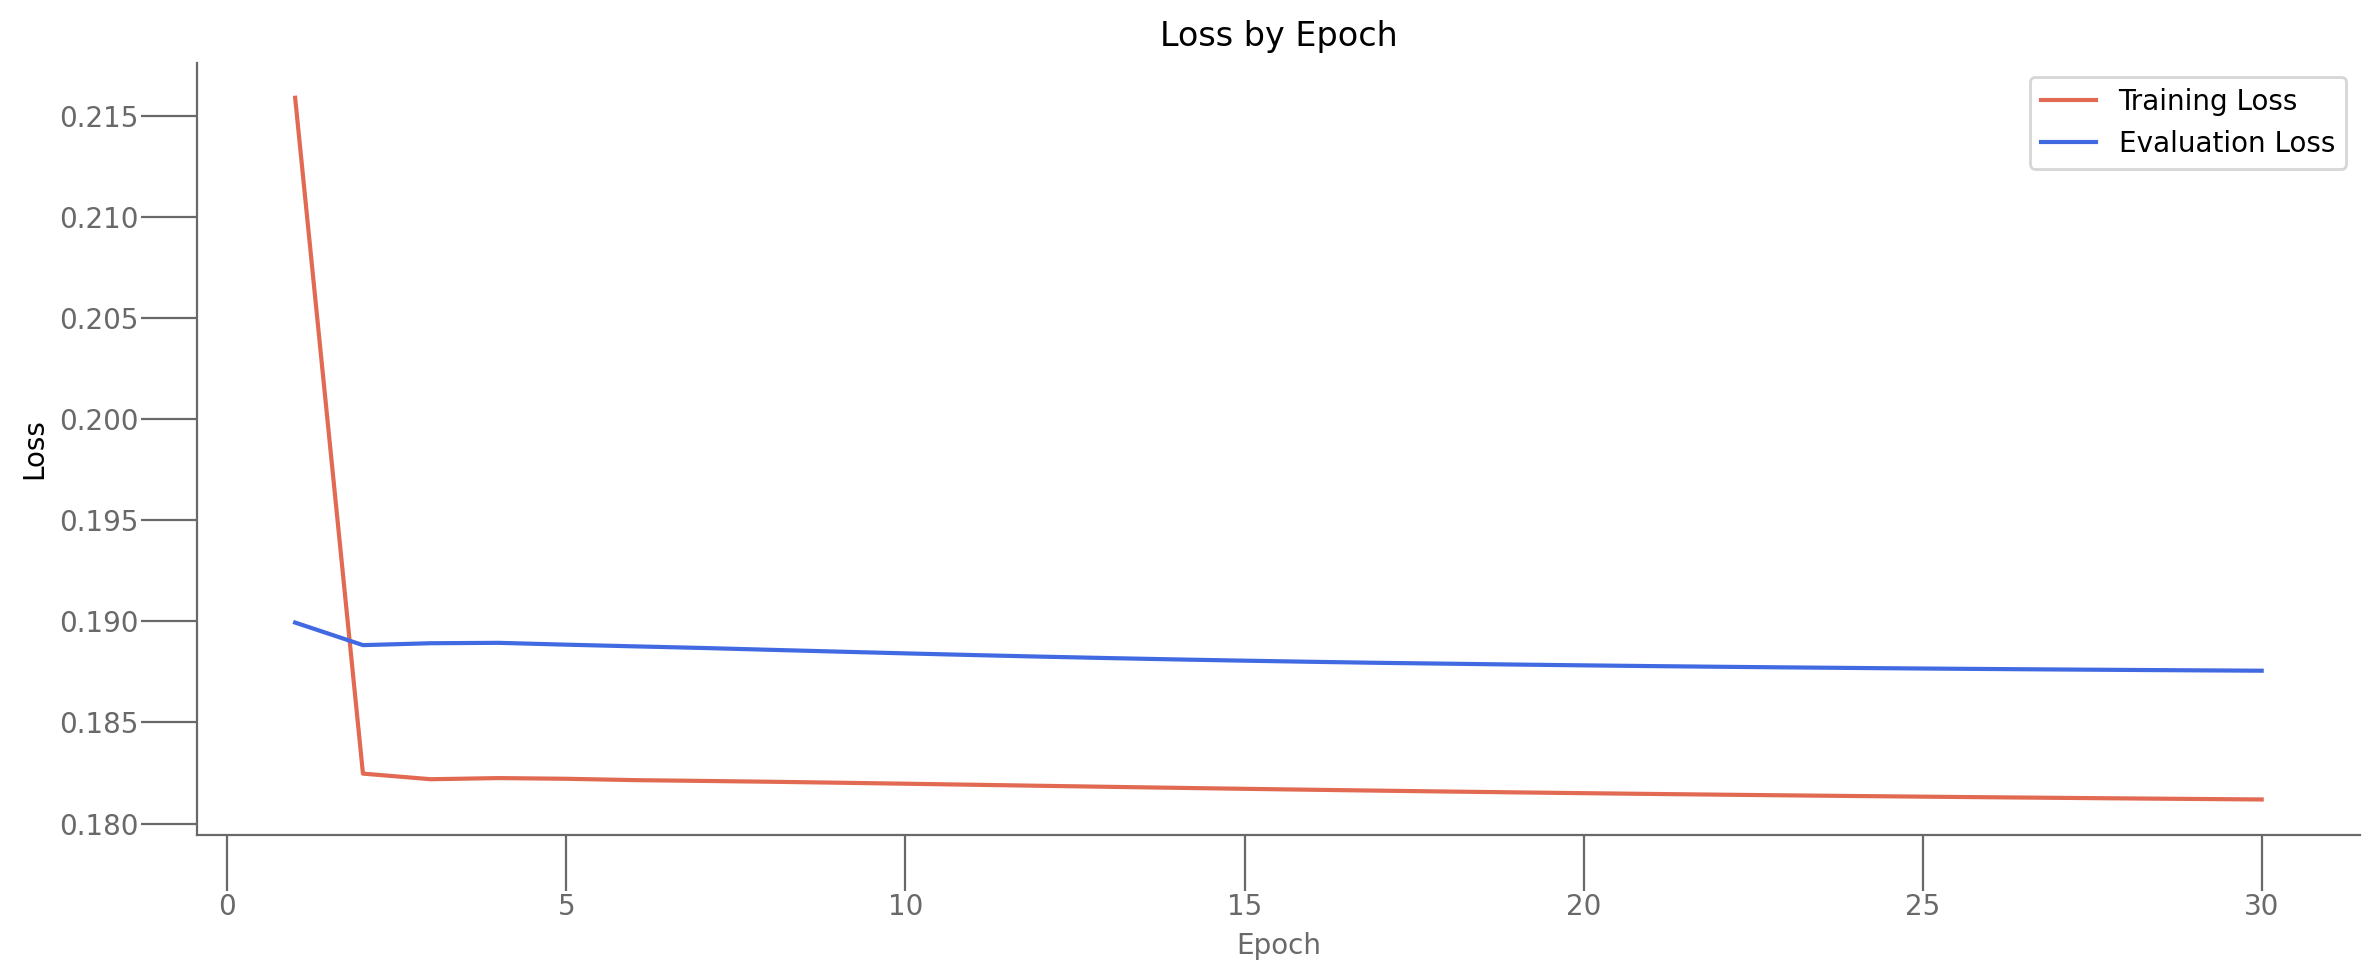


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.150332, test r2score -27.624034


In [23]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bf, real_bf = trainer_bf.test()

#### Ajuste de parámetros 

In [24]:

param_grid = {
    "nb_block": [1, 2, 3],
    "filter": [2,4,8],
    "time_strides": [1, 2, 4]
}

num_epochs = 100
num_early_stop = 10
trainer_bf,params_bf,resultados_final_bf, resultados_bf = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_bf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bf)

  0%|          | 0/27 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.5688 | Eval Loss: 0.3633 | Eval R2: -73.4508 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.3106 | Eval Loss: 0.3092 | Eval R2: -57.9418 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.2716 | Eval Loss: 0.2833 | Eval R2: -56.0511 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.2550 | Eval Loss: 0.2683 | Eval R2: -54.0105 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.2297 | Eval Loss: 0.2317 | Eval R2: -45.2955 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.2105 | Eval Loss: 0.2239 | Eval R2: -42.9914 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.2031 | Eval Loss: 0.2169 | Eval R2: -42.7776 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.1970 | Eval Loss: 0.2103 | Eval R2: -41.0081 | LR: 0.0010 | 
Epoch 9/100 | Train Lo

  4%|▎         | 1/27 [03:06<1:20:46, 186.40s/it]

preds:  (1, 23, 20)
test loss: 0.079731, test r2score -12.070237
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.08949052542448044, 'r2_eval_final': -14.919407844543457, 'loss_eval_final': 0.09884075075387955, 'r2_test': -12.070236955972536, 'loss_test': 0.07973094284534454, 'loss_nodes': [[0.06817754358053207, 0.0764334574341774, 0.06919804215431213, 0.07485903054475784, 0.08493389189243317, 0.07311553508043289, 0.07756789773702621, 0.08493190258741379, 0.07707865536212921, 0.07710601389408112, 0.08038140833377838, 0.08261947333812714, 0.08990273624658585, 0.08193643391132355, 0.07842957973480225, 0.0772843211889267, 0.0843459740281105, 0.08334165066480637, 0.08893939852714539, 0.08403592556715012]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

======

  7%|▋         | 2/27 [05:53<1:13:01, 175.25s/it]

preds:  (1, 23, 20)
test loss: 0.064334, test r2score -7.692555
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.08433756977319717, 'r2_eval_final': -11.043749809265137, 'loss_eval_final': 0.0965748280286789, 'r2_test': -7.692554951188705, 'loss_test': 0.06433435529470444, 'loss_nodes': [[0.05706627294421196, 0.05454476922750473, 0.05254705622792244, 0.0616411529481411, 0.0626722052693367, 0.05983603373169899, 0.06853039562702179, 0.06010042130947113, 0.06174749508500099, 0.05912313610315323, 0.0695183053612709, 0.06383301317691803, 0.06133095920085907, 0.06933572888374329, 0.06931324303150177, 0.06357898563146591, 0.07797158509492874, 0.0696444883942604, 0.07513128966093063, 0.06922062486410141]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==========

 11%|█         | 3/27 [08:28<1:06:19, 165.81s/it]

preds:  (1, 23, 20)
test loss: 0.124740, test r2score -24.049885
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.1518685668706894, 'r2_eval_final': -33.186790466308594, 'loss_eval_final': 0.156418576836586, 'r2_test': -24.04988460857158, 'loss_test': 0.12474003434181213, 'loss_nodes': [[0.12053792923688889, 0.12305460125207901, 0.11790498346090317, 0.11987446993589401, 0.11897928267717361, 0.12148010730743408, 0.12372422218322754, 0.11915946751832962, 0.12007993459701538, 0.13805736601352692, 0.12598569691181183, 0.14580637216567993, 0.13143117725849152, 0.12186641991138458, 0.12519502639770508, 0.12705716490745544, 0.1247653216123581, 0.12515626847743988, 0.1200549304485321, 0.12462956458330154]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

=========

 15%|█▍        | 4/27 [11:33<1:06:31, 173.56s/it]

preds:  (1, 23, 20)
test loss: 0.077845, test r2score -15.341630
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.07591865211725235, 'r2_eval_final': -18.5358829498291, 'loss_eval_final': 0.08506119251251221, 'r2_test': -15.341629699450003, 'loss_test': 0.07784461230039597, 'loss_nodes': [[0.007301539648324251, 0.008241632953286171, 0.00899454951286316, 0.012083337642252445, 0.013751594349741936, 0.5908123850822449, 0.01642354391515255, 0.01579168625175953, 0.020789913833141327, 0.01770852692425251, 0.593424379825592, 0.022794125601649284, 0.024165088310837746, 0.02423558570444584, 0.026300663128495216, 0.023022208362817764, 0.024686964228749275, 0.0417364127933979, 0.027438713237643242, 0.037189386785030365]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuisss

 19%|█▊        | 5/27 [14:24<1:03:11, 172.33s/it]

preds:  (1, 23, 20)
test loss: 0.135491, test r2score -28.418613
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.1317066103219986, 'r2_eval_final': -33.174072265625, 'loss_eval_final': 0.1362866759300232, 'r2_test': -28.418612804089282, 'loss_test': 0.13549138605594635, 'loss_nodes': [[0.5841706395149231, 0.01193842664361, 0.012155894190073013, 0.015061591751873493, 0.019170230254530907, 0.016877274960279465, 0.016827404499053955, 0.017783047631382942, 0.017982618883252144, 0.020550215616822243, 0.02135510928928852, 0.02483225055038929, 0.02920382097363472, 0.024894986301660538, 0.5967625379562378, 0.026171090081334114, 0.02442280948162079, 0.5998960137367249, 0.6009881496429443, 0.02878422476351261]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

=====

 22%|██▏       | 6/27 [17:03<58:48, 168.02s/it]  

preds:  (1, 23, 20)
test loss: 0.021027, test r2score -1.380072
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.026083284988999367, 'r2_eval_final': -3.399956464767456, 'loss_eval_final': 0.03820094093680382, 'r2_test': -1.3800716181524129, 'loss_test': 0.02102692425251007, 'loss_nodes': [[0.010862939059734344, 0.011574424803256989, 0.01289184857159853, 0.01651606895029545, 0.015455927699804306, 0.014936298131942749, 0.01926613226532936, 0.016186976805329323, 0.020998118445277214, 0.02427748776972294, 0.020245814695954323, 0.021257838234305382, 0.024101687595248222, 0.0260216873139143, 0.02733421139419079, 0.027257828041911125, 0.026481162756681442, 0.029174929484725, 0.028048310428857803, 0.027648800984025]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuisss

 26%|██▌       | 7/27 [20:29<1:00:06, 180.34s/it]

preds:  (1, 23, 20)
test loss: 0.190926, test r2score -42.993685
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.18295393884181976, 'r2_eval_final': -49.93133544921875, 'loss_eval_final': 0.18341359496116638, 'r2_test': -42.99368541368654, 'loss_test': 0.19092635810375214, 'loss_nodes': [[0.0050084819085896015, 0.008772469125688076, 0.5848095417022705, 0.010126142762601376, 0.012001613155007362, 0.011357316747307777, 0.590735673904419, 0.5905253291130066, 0.5965721011161804, 0.01739705540239811, 0.593424379825592, 0.025478200986981392, 0.5972772836685181, 0.024183955043554306, 0.022419270128011703, 0.026884688064455986, 0.0237684678286314, 0.027289927005767822, 0.023985641077160835, 0.026509661227464676]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

=

 30%|██▉       | 8/27 [23:37<57:52, 182.78s/it]  

preds:  (1, 23, 20)
test loss: 0.047552, test r2score -7.998387
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.046975910663604736, 'r2_eval_final': -10.441112518310547, 'loss_eval_final': 0.05662037059664726, 'r2_test': -7.998386676903004, 'loss_test': 0.047551918774843216, 'loss_nodes': [[0.005722156725823879, 0.009486774913966656, 0.012634467333555222, 0.00972924754023552, 0.009916950948536396, 0.010168501175940037, 0.590735673904419, 0.015869319438934326, 0.01702767424285412, 0.017537124454975128, 0.02041027322411537, 0.020786087960004807, 0.023914769291877747, 0.025482645258307457, 0.02561166323721409, 0.02269623801112175, 0.022758016362786293, 0.035058896988630295, 0.0258281622081995, 0.029663540422916412]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQu

 33%|███▎      | 9/27 [26:28<53:42, 179.02s/it]

preds:  (1, 23, 20)
test loss: 0.019683, test r2score -1.074818
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.021482495591044426, 'r2_eval_final': -2.6293892860412598, 'loss_eval_final': 0.033033207058906555, 'r2_test': -1.0748176581442117, 'loss_test': 0.0196826308965683, 'loss_nodes': [[0.009491866454482079, 0.010906391777098179, 0.010901790112257004, 0.013408568687736988, 0.012140871025621891, 0.014058537781238556, 0.01764948107302189, 0.017610453069210052, 0.01907617412507534, 0.018050573766231537, 0.020825648680329323, 0.024181874468922615, 0.023663165047764778, 0.02533605322241783, 0.02603529952466488, 0.024657515808939934, 0.023751184344291687, 0.02710113488137722, 0.026793459430336952, 0.028012601658701897]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 43

 37%|███▋      | 10/27 [32:40<1:07:36, 238.59s/it]

preds:  (1, 23, 20)
test loss: 0.128088, test r2score -22.497672
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.16566798090934753, 'r2_eval_final': -30.892866134643555, 'loss_eval_final': 0.16932371258735657, 'r2_test': -22.497672172529345, 'loss_test': 0.12808756530284882, 'loss_nodes': [[0.12334366887807846, 0.1255250722169876, 0.12683990597724915, 0.12706471979618073, 0.12724103033542633, 0.12583297491073608, 0.12789422273635864, 0.12788067758083344, 0.1278982162475586, 0.12814779579639435, 0.12819905579090118, 0.12963035702705383, 0.1297227442264557, 0.1299312263727188, 0.13029323518276215, 0.1277414858341217, 0.12998400628566742, 0.13009944558143616, 0.12828423082828522, 0.130197212100029]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==========

 41%|████      | 11/27 [37:51<1:09:32, 260.79s/it]

preds:  (1, 23, 20)
test loss: 0.151524, test r2score -28.636996
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.1848747730255127, 'r2_eval_final': -37.79400634765625, 'loss_eval_final': 0.18707045912742615, 'r2_test': -28.63699568998313, 'loss_test': 0.1515241265296936, 'loss_nodes': [[0.5841706395149231, 0.1258494108915329, 0.12728776037693024, 0.1274496614933014, 0.12741105258464813, 0.12637615203857422, 0.12822729349136353, 0.12851528823375702, 0.12821519374847412, 0.12862147390842438, 0.12857261300086975, 0.12983675301074982, 0.13007836043834686, 0.1302390694618225, 0.13096268475055695, 0.1283903568983078, 0.13039357960224152, 0.13050180673599243, 0.1287124902009964, 0.13067103922367096]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

=============

 44%|████▍     | 12/27 [42:38<1:07:11, 268.75s/it]

preds:  (1, 23, 20)
test loss: 0.268173, test r2score -57.652438
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.28498682379722595, 'r2_eval_final': -68.70355224609375, 'loss_eval_final': 0.28472909331321716, 'r2_test': -57.6524381021738, 'loss_test': 0.26817262172698975, 'loss_nodes': [[0.12373626977205276, 0.12584790587425232, 0.12715302407741547, 0.5873928070068359, 0.12738178670406342, 0.126113161444664, 0.12825696170330048, 0.1284678727388382, 0.5965721011161804, 0.12856632471084595, 0.12863969802856445, 0.5954892635345459, 0.13008277118206024, 0.13013574481010437, 0.5967625379562378, 0.12799866497516632, 0.5963250398635864, 0.1304919719696045, 0.12846383452415466, 0.5995745062828064]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

================

 48%|████▊     | 13/27 [48:48<1:09:54, 299.61s/it]

preds:  (1, 23, 20)
test loss: 0.137222, test r2score -29.171968
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.13169482350349426, 'r2_eval_final': -33.99936294555664, 'loss_eval_final': 0.13743194937705994, 'r2_test': -29.171967596550783, 'loss_test': 0.1372222751379013, 'loss_nodes': [[0.008910796605050564, 0.012840510345995426, 0.016535822302103043, 0.5873928070068359, 0.5891177654266357, 0.01467045396566391, 0.017681285738945007, 0.02303638495504856, 0.02151384949684143, 0.024914871901273727, 0.024840444326400757, 0.021513985469937325, 0.030086182057857513, 0.02653057873249054, 0.0322742722928524, 0.029412318021059036, 0.028881829231977463, 0.5998960137367249, 0.6009881496429443, 0.033407606184482574]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss


 52%|█████▏    | 14/27 [54:19<1:06:55, 308.90s/it]

preds:  (1, 23, 20)
test loss: 0.020116, test r2score -1.300160
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.02415456250309944, 'r2_eval_final': -3.2370681762695312, 'loss_eval_final': 0.03595248982310295, 'r2_test': -1.3001604292292652, 'loss_test': 0.020115774124860764, 'loss_nodes': [[0.01127298828214407, 0.014119839295744896, 0.014736960642039776, 0.011991537176072598, 0.014941370114684105, 0.013176401145756245, 0.017533844336867332, 0.019256148487329483, 0.017636733129620552, 0.020111210644245148, 0.01951293647289276, 0.022638149559497833, 0.02375621162354946, 0.024610208347439766, 0.025269249454140663, 0.024066893383860588, 0.025040464475750923, 0.026856279000639915, 0.02793380618095398, 0.027854228392243385]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 4

 56%|█████▌    | 15/27 [59:12<1:00:51, 304.32s/it]

preds:  (1, 23, 20)
test loss: 0.049549, test r2score -7.929985
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.0521635077893734, 'r2_eval_final': -10.357759475708008, 'loss_eval_final': 0.06122048944234848, 'r2_test': -7.929985286043108, 'loss_test': 0.049548566341400146, 'loss_nodes': [[0.01220245286822319, 0.01002245582640171, 0.013449234887957573, 0.0141531303524971, 0.013776995241641998, 0.016891345381736755, 0.017569556832313538, 0.017023872584104538, 0.018782848492264748, 0.020605621859431267, 0.021425461396574974, 0.02434569224715233, 0.026359956711530685, 0.026749007403850555, 0.02926628664135933, 0.02357262186706066, 0.027551328763365746, 0.029106421396136284, 0.6009881496429443, 0.02712872438132763]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuis

 59%|█████▉    | 16/27 [1:06:16<1:02:23, 340.35s/it]

preds:  (1, 23, 20)
test loss: 0.279246, test r2score -64.630716
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.2656148374080658, 'r2_eval_final': -74.82405853271484, 'loss_eval_final': 0.2633011043071747, 'r2_test': -64.63071627891748, 'loss_test': 0.27924564480781555, 'loss_nodes': [[0.5841706395149231, 0.014676534570753574, 0.5848095417022705, 0.5873928070068359, 0.5891177654266357, 0.5908123850822449, 0.019699618220329285, 0.5905253291130066, 0.01975039765238762, 0.5954317450523376, 0.02415529079735279, 0.5954892635345459, 0.02498660609126091, 0.5969739556312561, 0.02870757132768631, 0.02590237930417061, 0.028891712427139282, 0.02747722901403904, 0.026434844359755516, 0.029507609084248543]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

===========

 63%|██████▎   | 17/27 [1:12:15<57:37, 345.74s/it]  

preds:  (1, 23, 20)
test loss: 0.018443, test r2score -0.903325
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.017896736040711403, 'r2_eval_final': -2.1713263988494873, 'loss_eval_final': 0.027409130707383156, 'r2_test': -0.9033249828724355, 'loss_test': 0.018442733213305473, 'loss_nodes': [[0.00526238651946187, 0.007019253447651863, 0.007889317348599434, 0.009105672128498554, 0.01000209990888834, 0.011231031268835068, 0.015311001800000668, 0.016910474747419357, 0.017969127744436264, 0.019244743511080742, 0.019742757081985474, 0.02162637934088707, 0.02425648644566536, 0.02510354295372963, 0.025376085191965103, 0.024529803544282913, 0.0269587691873312, 0.027424447238445282, 0.025878282263875008, 0.028012938797473907]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 43

 67%|██████▋   | 18/27 [1:17:31<50:33, 337.03s/it]

preds:  (1, 23, 20)
test loss: 0.078504, test r2score -15.346849
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.07769690454006195, 'r2_eval_final': -18.921262741088867, 'loss_eval_final': 0.08543723821640015, 'r2_test': -15.346848529701585, 'loss_test': 0.07850395143032074, 'loss_nodes': [[0.5841706395149231, 0.013276130892336369, 0.013592345640063286, 0.014210360124707222, 0.015345180407166481, 0.015617568045854568, 0.018584417179226875, 0.018675338476896286, 0.5965721011161804, 0.02075897343456745, 0.02175825648009777, 0.024462783709168434, 0.025471968576312065, 0.024630242958664894, 0.02588641084730625, 0.025487331673502922, 0.026377970352768898, 0.029333719983696938, 0.027536993846297264, 0.028330447152256966]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430


 70%|███████   | 19/27 [1:26:42<53:28, 401.05s/it]

preds:  (1, 23, 20)
test loss: 0.197927, test r2score -40.352337
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.22348414361476898, 'r2_eval_final': -50.2000732421875, 'loss_eval_final': 0.2235979586839676, 'r2_test': -40.352336764832785, 'loss_test': 0.19792743027210236, 'loss_nodes': [[0.5841706395149231, 0.12505584955215454, 0.12658916413784027, 0.12667597830295563, 0.1269373595714569, 0.12600693106651306, 0.12727901339530945, 0.12903393805027008, 0.1271509975194931, 0.5954317450523376, 0.12840594351291656, 0.12919652462005615, 0.1294611692428589, 0.12958545982837677, 0.13030697405338287, 0.12733663618564606, 0.12955966591835022, 0.1296781748533249, 0.6009881496429443, 0.1296977996826172]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==============

 74%|███████▍  | 20/27 [1:34:21<48:50, 418.59s/it]

preds:  (1, 23, 20)
test loss: 0.244135, test r2score -52.072187
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.26493382453918457, 'r2_eval_final': -63.245948791503906, 'loss_eval_final': 0.2616318464279175, 'r2_test': -52.072187417787134, 'loss_test': 0.24413475394248962, 'loss_nodes': [[0.5841706395149231, 0.12548500299453735, 0.12713545560836792, 0.5873928070068359, 0.12707671523094177, 0.125807985663414, 0.12795713543891907, 0.1282944679260254, 0.12795235216617584, 0.128140389919281, 0.593424379825592, 0.5954892635345459, 0.5972772836685181, 0.12995634973049164, 0.13042473793029785, 0.12773624062538147, 0.13011519610881805, 0.1302046775817871, 0.12832193076610565, 0.1303321123123169]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

=================

 78%|███████▊  | 21/27 [1:41:28<42:06, 421.05s/it]

preds:  (1, 23, 20)
test loss: 0.127501, test r2score -22.986885
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.1619875431060791, 'r2_eval_final': -31.354537963867188, 'loss_eval_final': 0.16644662618637085, 'r2_test': -22.98688511392357, 'loss_test': 0.12750107049942017, 'loss_nodes': [[0.12246015667915344, 0.12603521347045898, 0.12527617812156677, 0.126241996884346, 0.12633976340293884, 0.12772296369075775, 0.12642276287078857, 0.1266220659017563, 0.12612146139144897, 0.1322055459022522, 0.12690547108650208, 0.12818336486816406, 0.12970951199531555, 0.12874148786067963, 0.1292048543691635, 0.12639062106609344, 0.12843073904514313, 0.12932558357715607, 0.12724047899246216, 0.13044123351573944]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==========

 81%|████████▏ | 22/27 [1:50:41<38:23, 460.61s/it]

preds:  (1, 23, 20)
test loss: 0.019870, test r2score -1.131823
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.023188794031739235, 'r2_eval_final': -2.80598783493042, 'loss_eval_final': 0.03393228352069855, 'r2_test': -1.131822806965032, 'loss_test': 0.019869539886713028, 'loss_nodes': [[0.009326095692813396, 0.010533665306866169, 0.011449096724390984, 0.011648721061646938, 0.013909978792071342, 0.013342391699552536, 0.017064347863197327, 0.018949054181575775, 0.019421331584453583, 0.019128426909446716, 0.020386451855301857, 0.022591356188058853, 0.025838280096650124, 0.025521419942378998, 0.026869289577007294, 0.023345479741692543, 0.02654149942100048, 0.02812594547867775, 0.02563740871846676, 0.02776060812175274]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

 85%|████████▌ | 23/27 [1:58:35<30:58, 464.62s/it]

preds:  (1, 23, 20)
test loss: 0.052482, test r2score -8.800884
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.054552897810935974, 'r2_eval_final': -11.652064323425293, 'loss_eval_final': 0.06443295627832413, 'r2_test': -8.800884226580253, 'loss_test': 0.052481621503829956, 'loss_nodes': [[0.015679799020290375, 0.017766635864973068, 0.01589992456138134, 0.016226889565587044, 0.016745442524552345, 0.5908123850822449, 0.021662138402462006, 0.019505955278873444, 0.022845987230539322, 0.024189980700612068, 0.023604752495884895, 0.02607341855764389, 0.027305960655212402, 0.028933975845575333, 0.026344535872340202, 0.029756847769021988, 0.030019670724868774, 0.03177323192358017, 0.031734831631183624, 0.032750148326158524]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 43

 89%|████████▉ | 24/27 [2:06:04<23:00, 460.10s/it]

preds:  (1, 23, 20)
test loss: 0.021946, test r2score -1.550171
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.02720627188682556, 'r2_eval_final': -3.7201321125030518, 'loss_eval_final': 0.040830567479133606, 'r2_test': -1.5501708196657078, 'loss_test': 0.021946053951978683, 'loss_nodes': [[0.011777274310588837, 0.013086256571114063, 0.013439351692795753, 0.014908039011061192, 0.014455770142376423, 0.014356671832501888, 0.02073366940021515, 0.019056959077715874, 0.023825785145163536, 0.02066340111196041, 0.027422141283750534, 0.02328445576131344, 0.025066470727324486, 0.027193572372198105, 0.025815796107053757, 0.026155874133110046, 0.027506571263074875, 0.0301765538752079, 0.031522709876298904, 0.02847376838326454]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 43

 93%|█████████▎| 25/27 [2:16:58<17:16, 518.35s/it]

preds:  (1, 23, 20)
test loss: 0.076071, test r2score -14.776002
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.07530590891838074, 'r2_eval_final': -18.01036262512207, 'loss_eval_final': 0.08330826461315155, 'r2_test': -14.776002434805976, 'loss_test': 0.0760708898305893, 'loss_nodes': [[0.0068827224895358086, 0.00875900313258171, 0.009549523703753948, 0.5873928070068359, 0.011558571830391884, 0.011934497393667698, 0.01655520871281624, 0.015525490045547485, 0.01843489333987236, 0.01880587637424469, 0.01924687623977661, 0.02278539352118969, 0.023516187444329262, 0.024912651628255844, 0.023912018164992332, 0.023056691512465477, 0.02417316846549511, 0.027772357687354088, 0.02706948295235634, 0.5995745062828064]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuiss

 96%|█████████▋| 26/27 [2:25:59<08:44, 524.90s/it]

preds:  (1, 23, 20)
test loss: 0.078031, test r2score -14.660790
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.07624799758195877, 'r2_eval_final': -17.424287796020508, 'loss_eval_final': 0.08333796262741089, 'r2_test': -14.660789707424788, 'loss_test': 0.07803112268447876, 'loss_nodes': [[0.007334781810641289, 0.01213030330836773, 0.012728052213788033, 0.01359699759632349, 0.01394436601549387, 0.012674123980104923, 0.016514532268047333, 0.020607715472579002, 0.01776987873017788, 0.022758038714528084, 0.01978224143385887, 0.02316810004413128, 0.028014183044433594, 0.025574520230293274, 0.03077930398285389, 0.023655381053686142, 0.025053897872567177, 0.5998960137367249, 0.6009881496429443, 0.03365173563361168]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuis

100%|██████████| 27/27 [2:33:50<00:00, 341.86s/it]

preds:  (1, 23, 20)
test loss: 0.081412, test r2score -16.009960
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.08062610030174255, 'r2_eval_final': -19.800968170166016, 'loss_eval_final': 0.09051607549190521, 'r2_test': -16.00996025980441, 'loss_test': 0.08141230791807175, 'loss_nodes': [[0.015403478406369686, 0.5844451785087585, 0.01577838696539402, 0.018215034157037735, 0.017481718212366104, 0.019279105588793755, 0.590735673904419, 0.0213538259267807, 0.022600119933485985, 0.023918764665722847, 0.026673803105950356, 0.028526071459054947, 0.02912985160946846, 0.031069975346326828, 0.030986713245511055, 0.02835969068109989, 0.029670508578419685, 0.03195795789361, 0.030868828296661377, 0.031791288405656815]]}


In [25]:
_, _, _, predictions_bf_ajuste, real_bf_ajuste = trainer_bf.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.018443, test r2score -0.903329


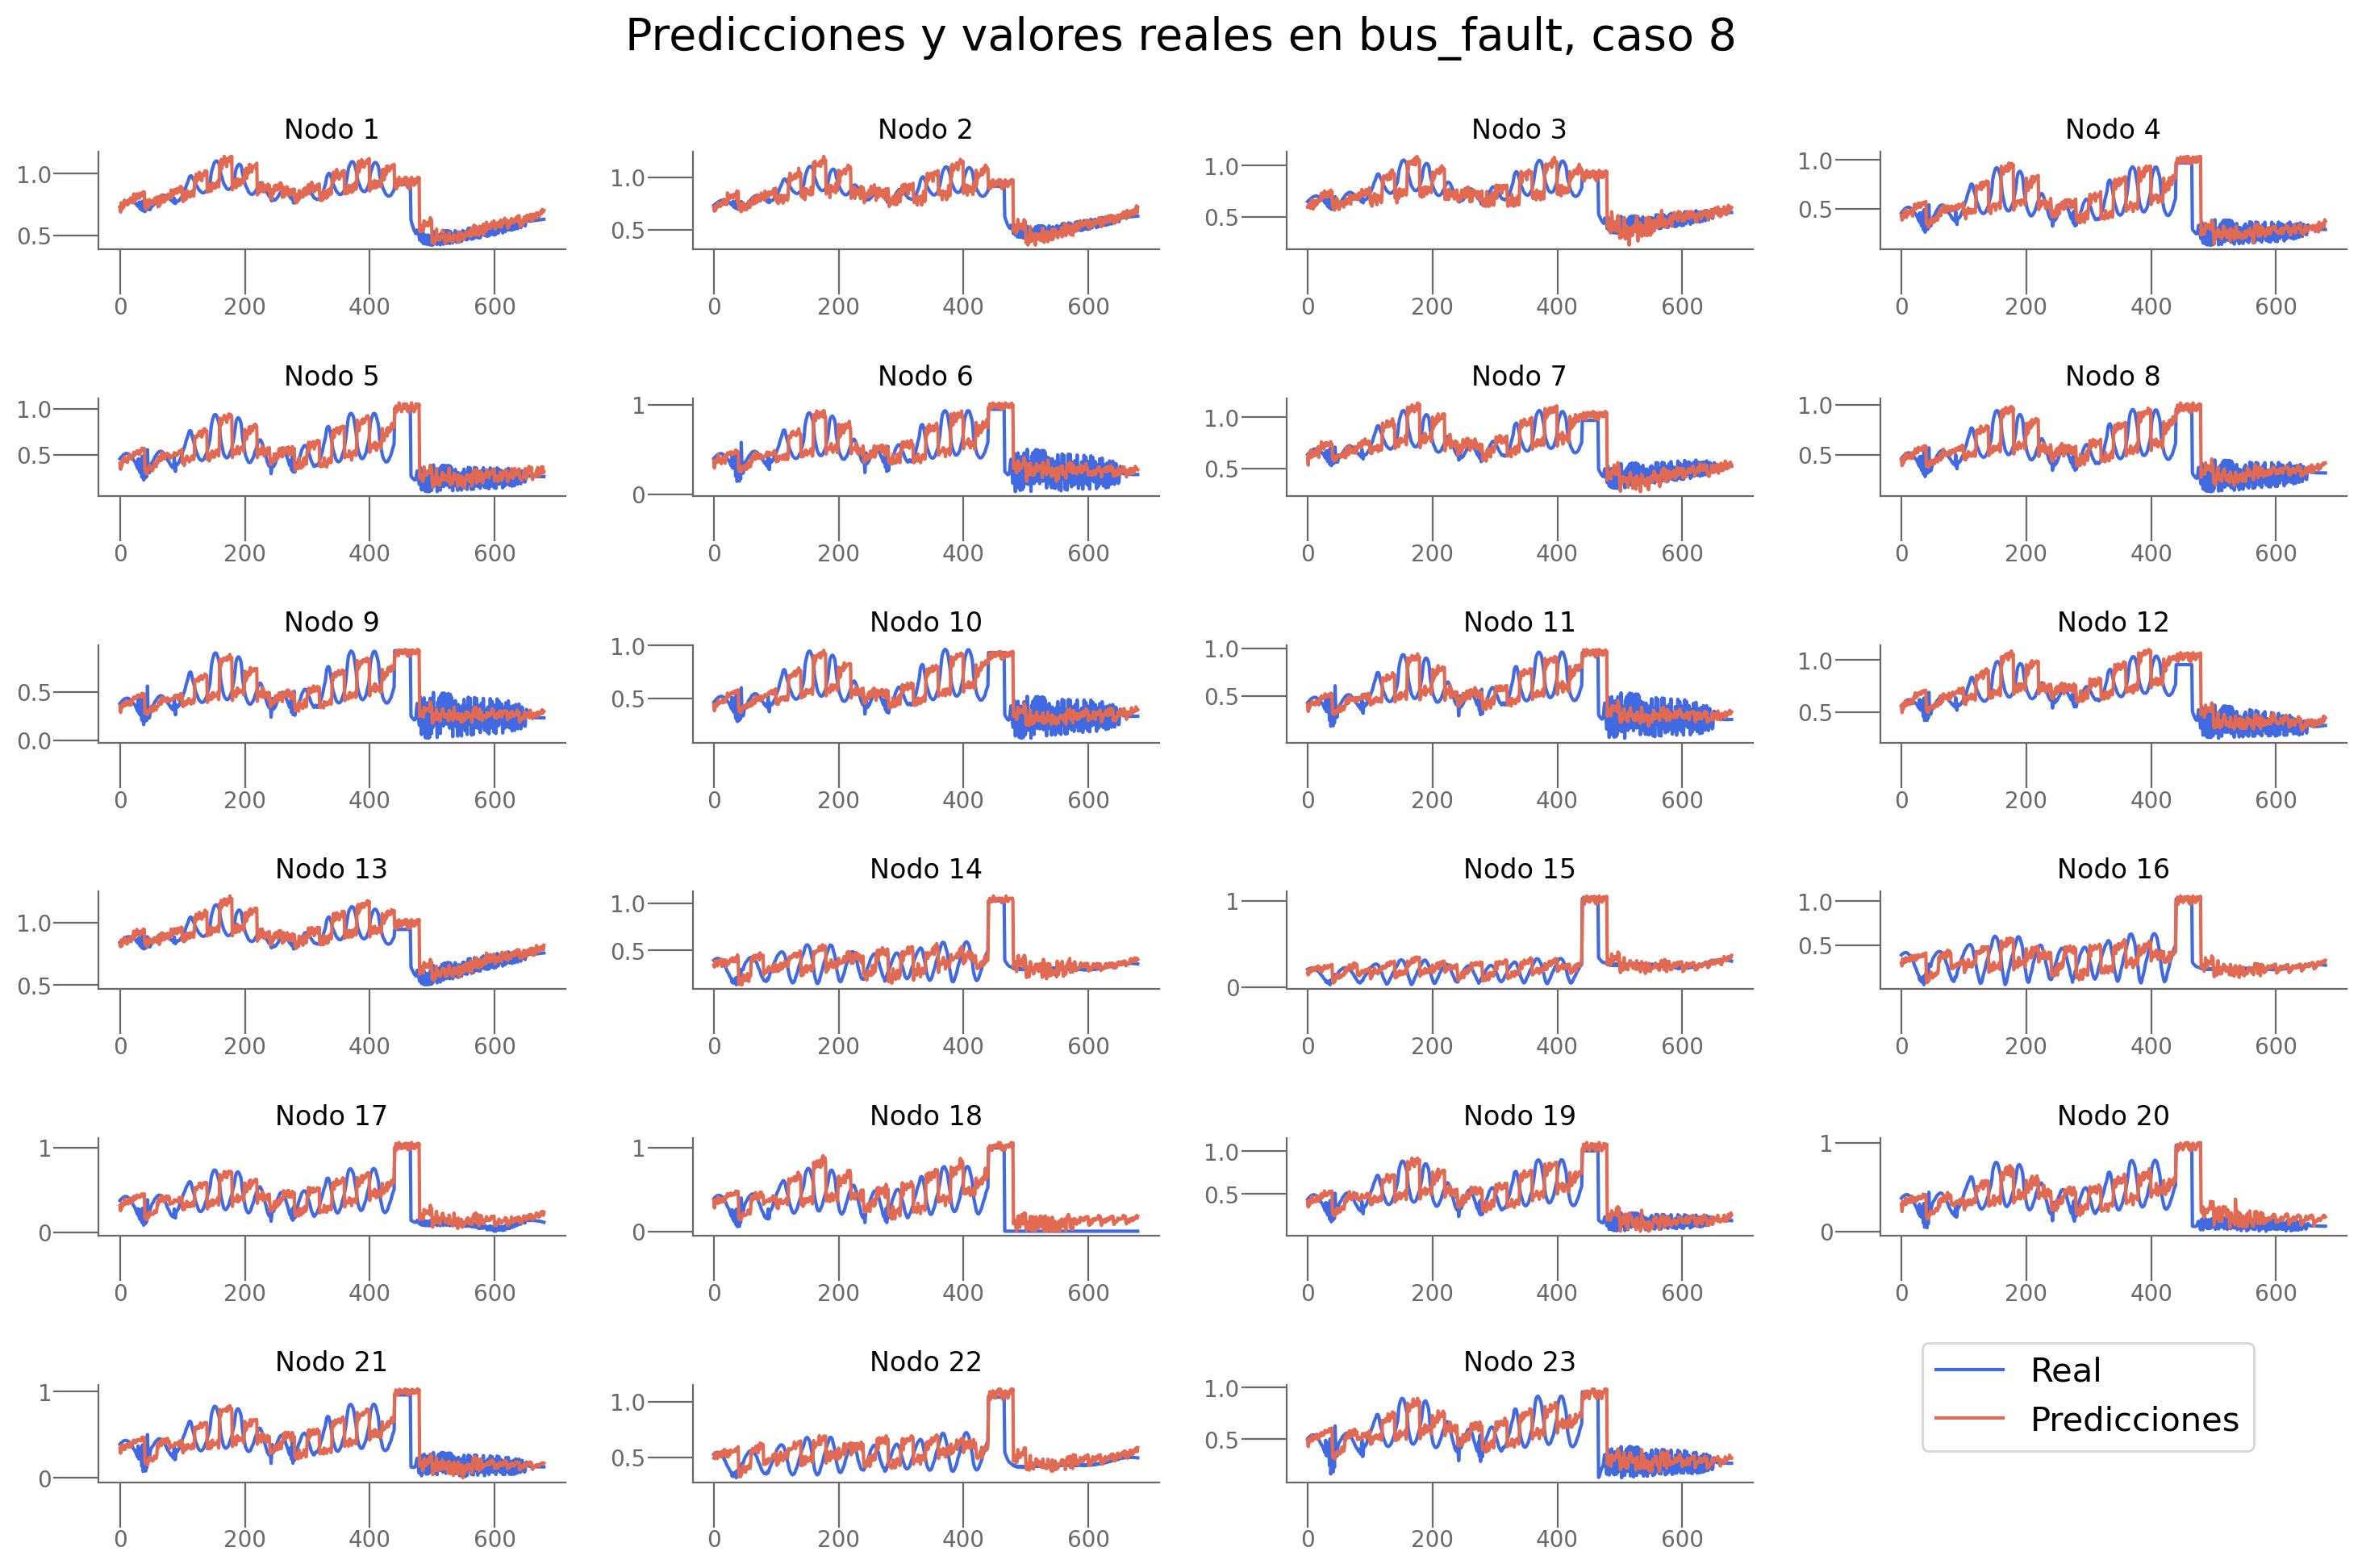

In [26]:
plot_predictions(predictions_bf_ajuste, real_bf_ajuste, n_target, 8, n_div_bf, problem_bf)

In [27]:
path_save_experiment_bf = results_save_path+f"/{problem_bf}"+ f"/ajustes/{name_model}_results.csv"
resultados_bf.to_csv(path_save_experiment_bf, index=False)

In [28]:
trainer_bf.save_model(path_save_experiment=path_save_experiment_bf, params=params_bf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
3   DyGrEncoder             {'aggr': 'mean', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.017298  0.603716   
1                                                NaN  0.017459 -1.122112   
2   ./results/bus_fault/ajustes/MPNNLSTM_results.csv  0.016746 -0.682421   
3  ./results/bus_fault/ajustes/DryGrEncoder_resul...  0.016410 -0.664772   
4      ./results/bus_fault/ajustes/AGCRN_results.csv  0.020923  0

### Branch Fault

In [29]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [30]:
n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [31]:

device =  torch.device("cpu")
model_brf = RecurrentGCN(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)


trainer_brf = TrainerMSTGCN(model_brf, dataset_brf,device, f"./results/{problem_brf}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_brf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1875 | Eval Loss: 0.2232 | Eval R2: -25.0679 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.1601 | Eval Loss: 0.2219 | Eval R2: -24.9007 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.1598 | Eval Loss: 0.2219 | Eval R2: -24.9417 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.1598 | Eval Loss: 0.2220 | Eval R2: -24.9639 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.1598 | Eval Loss: 0.2220 | Eval R2: -24.9752 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1599 | Eval Loss: 0.2222 | Eval R2: -24.9865 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1598 | Eval Loss: 0.2221 | Eval R2: -24.9924 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.1598 | Eval Loss: 0.2221 | Eval R2: -24.9885 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.1597 | Eval Loss: 0.2220 | Eval R2: -24.9850 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0

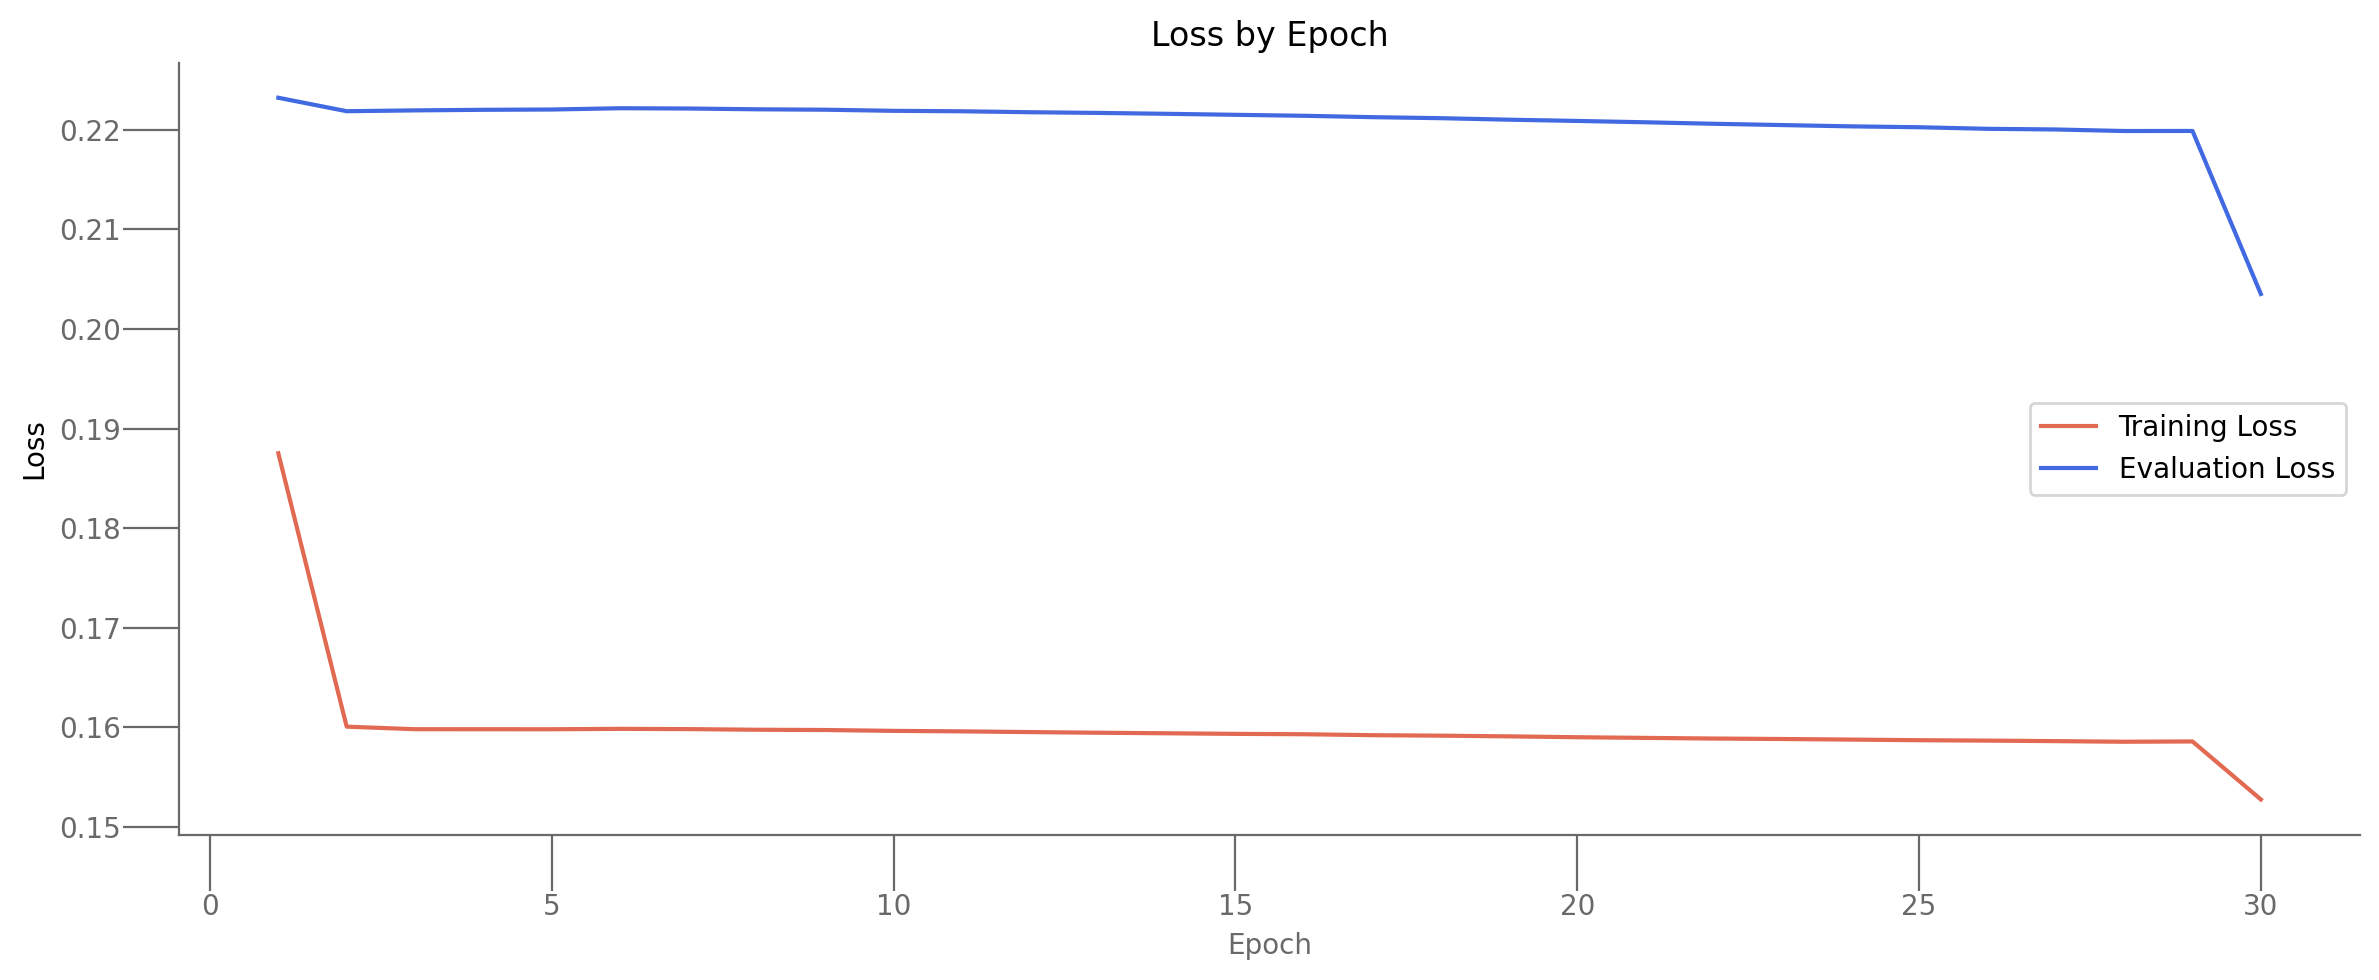


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.110374, test r2score -15.082346


In [32]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brf, real_brf = trainer_brf.test()

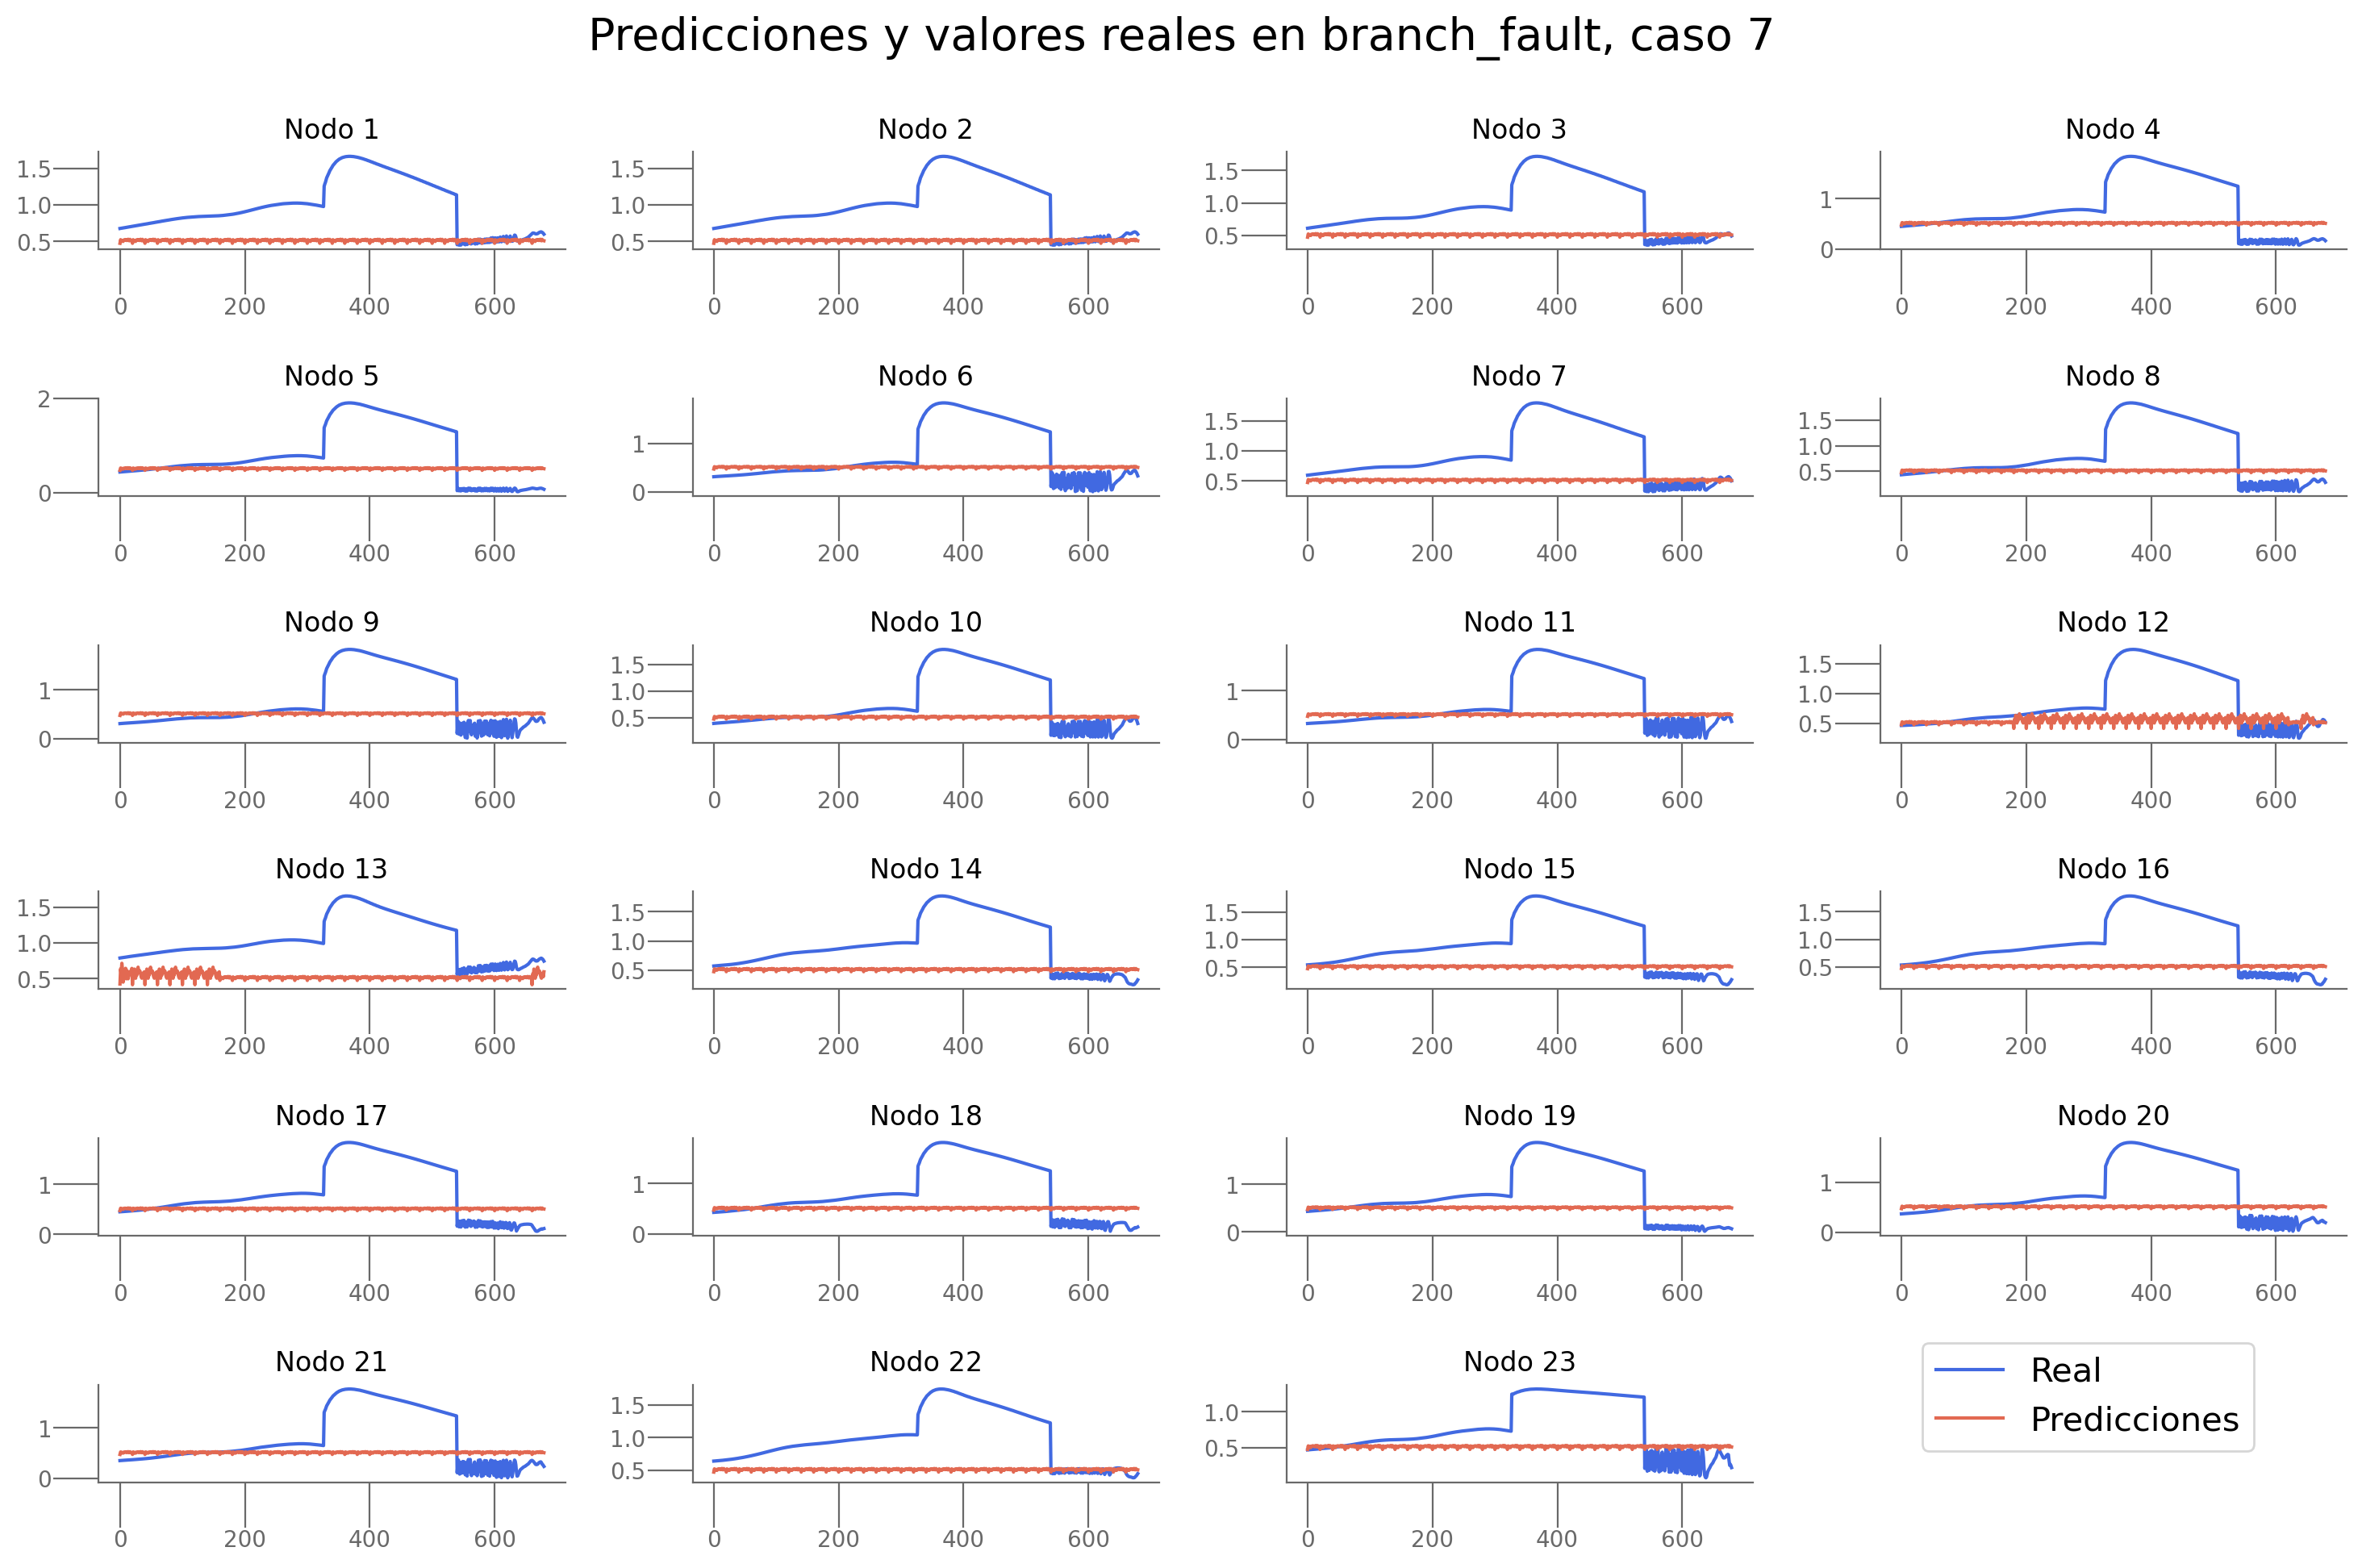

In [33]:
plot_predictions(predictions_brf, real_brf, n_target, 7, n_div_brf, problem_brf)

#### Ajuste de parámetros 

In [34]:

param_grid = {
    "nb_block": [1, 2, 3],
    "filter": [2,4,8],
    "time_strides": [1, 2, 4]
}

num_epochs = 100
num_early_stop = 10

trainer_brf,params_brf,resultados_final_brf, resultados_brf = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_brf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brf)

  0%|          | 0/27 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.5806 | Eval Loss: 0.3968 | Eval R2: -39.7123 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.3211 | Eval Loss: 0.3668 | Eval R2: -37.3361 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.2906 | Eval Loss: 0.3360 | Eval R2: -34.5995 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.2675 | Eval Loss: 0.3197 | Eval R2: -32.8906 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.2484 | Eval Loss: 0.2954 | Eval R2: -29.9348 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.2323 | Eval Loss: 0.2715 | Eval R2: -27.8368 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.2144 | Eval Loss: 0.2535 | Eval R2: -26.0501 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.2017 | Eval Loss: 0.2426 | Eval R2: -25.8266 | LR: 0.0010 | 
Epoch 9/100 | Train Lo

  4%|▎         | 1/27 [03:20<1:26:59, 200.74s/it]

preds:  (1, 23, 20)
test loss: 0.094786, test r2score -11.260575
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.11219579726457596, 'r2_eval_final': -14.821245193481445, 'loss_eval_final': 0.14104734361171722, 'r2_test': -11.260574617324767, 'loss_test': 0.09478616714477539, 'loss_nodes': [[0.06588371843099594, 0.07212129980325699, 0.07613712549209595, 0.07692424952983856, 0.07848973572254181, 0.07634634524583817, 0.07453755289316177, 0.08637393265962601, 0.08144553005695343, 0.36062195897102356, 0.07969736307859421, 0.07993870228528976, 0.08885754644870758, 0.08538726717233658, 0.08083245903253555, 0.07951833307743073, 0.08353741466999054, 0.09265577048063278, 0.09197299927473068, 0.08444411307573318]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

===

  7%|▋         | 2/27 [06:18<1:18:04, 187.37s/it]

preds:  (1, 23, 20)
test loss: 0.077036, test r2score -9.965171
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.09150342643260956, 'r2_eval_final': -12.30057144165039, 'loss_eval_final': 0.11295536905527115, 'r2_test': -9.965171117846872, 'loss_test': 0.07703593373298645, 'loss_nodes': [[0.08141929656267166, 0.06709388643503189, 0.06842510402202606, 0.07924044877290726, 0.07594702392816544, 0.07208188623189926, 0.07385597378015518, 0.07513225823640823, 0.07932810485363007, 0.07068730145692825, 0.07698747515678406, 0.07361072301864624, 0.07657162100076675, 0.08215981721878052, 0.07438407838344574, 0.07295653969049454, 0.08532105386257172, 0.08286736905574799, 0.097932830452919, 0.07471579313278198]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

========

 11%|█         | 3/27 [09:04<1:11:01, 177.54s/it]

preds:  (1, 23, 20)
test loss: 0.102136, test r2score -13.895681
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.1318545937538147, 'r2_eval_final': -19.616830825805664, 'loss_eval_final': 0.17503231763839722, 'r2_test': -13.895680702506338, 'loss_test': 0.10213646292686462, 'loss_nodes': [[0.09468235075473785, 0.09441325813531876, 0.09638655930757523, 0.10489414632320404, 0.09676095098257065, 0.09650217741727829, 0.09466724842786789, 0.10004662722349167, 0.1097821593284607, 0.1067870706319809, 0.10137328505516052, 0.10727198421955109, 0.11520011723041534, 0.10613562911748886, 0.09878533333539963, 0.10264037549495697, 0.10232352465391159, 0.10595613718032837, 0.10851527005434036, 0.09960529953241348]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

======

 15%|█▍        | 4/27 [12:23<1:11:14, 185.83s/it]

preds:  (1, 23, 20)
test loss: 0.057910, test r2score -6.999636
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06782948225736618, 'r2_eval_final': -9.633879661560059, 'loss_eval_final': 0.08578187972307205, 'r2_test': -6.999636119432382, 'loss_test': 0.05791035667061806, 'loss_nodes': [[0.008041925728321075, 0.012044820003211498, 0.013064894825220108, 0.019836442545056343, 0.017235292121767998, 0.016843825578689575, 0.020811183378100395, 0.02506854012608528, 0.028813166543841362, 0.024249857291579247, 0.3577996790409088, 0.02848946675658226, 0.029655488207936287, 0.03144507855176926, 0.3614124655723572, 0.028810348361730576, 0.03140430152416229, 0.03351329639554024, 0.035445425659418106, 0.03422192484140396]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuiss

 19%|█▊        | 5/27 [15:23<1:07:24, 183.83s/it]

preds:  (1, 23, 20)
test loss: 0.092562, test r2score -10.961384
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.11072754859924316, 'r2_eval_final': -15.294072151184082, 'loss_eval_final': 0.139733225107193, 'r2_test': -10.961383765120079, 'loss_test': 0.09256153553724289, 'loss_nodes': [[0.3448883593082428, 0.012012683786451817, 0.015914596617221832, 0.019916461780667305, 0.02371164597570896, 0.02252667397260666, 0.02165561355650425, 0.0276957917958498, 0.027875125408172607, 0.02379850670695305, 0.02681898884475231, 0.029341913759708405, 0.03529328107833862, 0.031783077865839005, 0.3614124655723572, 0.030813168734312057, 0.031075280159711838, 0.38064590096473694, 0.35197150707244873, 0.032079871743917465]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss


 22%|██▏       | 6/27 [18:15<1:02:53, 179.69s/it]

preds:  (1, 23, 20)
test loss: 0.046571, test r2score -4.706875
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.05214639753103256, 'r2_eval_final': -7.293871879577637, 'loss_eval_final': 0.06581886857748032, 'r2_test': -4.706875333286937, 'loss_test': 0.0465710274875164, 'loss_nodes': [[0.013231448829174042, 0.01602557860314846, 0.022176135331392288, 0.03584009036421776, 0.02353222854435444, 0.023129120469093323, 0.024299494922161102, 0.027896007522940636, 0.03370507061481476, 0.03032412938773632, 0.029597457498311996, 0.027983659878373146, 0.37819039821624756, 0.03526731953024864, 0.033457547426223755, 0.03383021801710129, 0.0344218872487545, 0.03887030482292175, 0.036030448973178864, 0.033611930906772614]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

 26%|██▌       | 7/27 [21:58<1:04:41, 194.08s/it]

preds:  (1, 23, 20)
test loss: 0.176983, test r2score -24.205920
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.21227174997329712, 'r2_eval_final': -30.909448623657227, 'loss_eval_final': 0.26709577441215515, 'r2_test': -24.205920478411713, 'loss_test': 0.17698316276073456, 'loss_nodes': [[0.006103042978793383, 0.016324514523148537, 0.37169891595840454, 0.02162952534854412, 0.017204267904162407, 0.019258322194218636, 0.3553822636604309, 0.37252137064933777, 0.3485524654388428, 0.026815442368388176, 0.3577996790409088, 0.36224445700645447, 0.37819039821624756, 0.031303174793720245, 0.03177117928862572, 0.3574807345867157, 0.034123171120882034, 0.037133507430553436, 0.03276706114411354, 0.36135977506637573]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss


 30%|██▉       | 8/27 [25:21<1:02:18, 196.78s/it]

preds:  (1, 23, 20)
test loss: 0.056449, test r2score -6.041369
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06538479775190353, 'r2_eval_final': -9.106205940246582, 'loss_eval_final': 0.08366526663303375, 'r2_test': -6.041369058620733, 'loss_test': 0.05644931644201279, 'loss_nodes': [[0.006649110000580549, 0.01330090407282114, 0.015276431106030941, 0.015663573518395424, 0.015188691206276417, 0.01680081896483898, 0.3553822636604309, 0.022664474323391914, 0.02529757283627987, 0.023231852799654007, 0.023485984653234482, 0.025703314691781998, 0.031008046120405197, 0.03367752954363823, 0.030122792348265648, 0.028058094903826714, 0.030589459463953972, 0.03376121446490288, 0.35197150707244873, 0.031152602285146713]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQui

 33%|███▎      | 9/27 [28:22<57:33, 191.89s/it]  

preds:  (1, 23, 20)
test loss: 0.025803, test r2score -2.076773
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.026801081374287605, 'r2_eval_final': -3.755685329437256, 'loss_eval_final': 0.03486603870987892, 'r2_test': -2.0767726903282004, 'loss_test': 0.02580324560403824, 'loss_nodes': [[0.012109666131436825, 0.014118868857622147, 0.017415475100278854, 0.01986556313931942, 0.01738789863884449, 0.019913122057914734, 0.022544454783201218, 0.025964906439185143, 0.029692525044083595, 0.025477316230535507, 0.026369867846369743, 0.027202442288398743, 0.030118945986032486, 0.03425322473049164, 0.030977167189121246, 0.030454644933342934, 0.031097594648599625, 0.033560387790203094, 0.0357583649456501, 0.031782496720552444]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

 37%|███▋      | 10/27 [34:54<1:11:50, 253.57s/it]

preds:  (1, 23, 20)
test loss: 0.123919, test r2score -16.923733
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.1632022261619568, 'r2_eval_final': -23.984342575073242, 'loss_eval_final': 0.2188270092010498, 'r2_test': -16.923733336895452, 'loss_test': 0.12391877174377441, 'loss_nodes': [[0.10404980927705765, 0.35275205969810486, 0.10770265012979507, 0.11593522876501083, 0.10884305834770203, 0.1059153750538826, 0.1073557436466217, 0.11049472540616989, 0.11787629127502441, 0.10939375311136246, 0.11054930090904236, 0.11201202124357224, 0.11325621604919434, 0.11972328275442123, 0.11127424985170364, 0.11103108525276184, 0.11323222517967224, 0.11415337771177292, 0.11965877562761307, 0.11316598951816559]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

=======

 41%|████      | 11/27 [40:35<1:14:45, 280.36s/it]

preds:  (1, 23, 20)
test loss: 0.124033, test r2score -16.656169
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.16292425990104675, 'r2_eval_final': -23.7362003326416, 'loss_eval_final': 0.21800853312015533, 'r2_test': -16.65616874912274, 'loss_test': 0.12403271347284317, 'loss_nodes': [[0.3448883593082428, 0.10645409673452377, 0.10789606720209122, 0.11646146327257156, 0.1089179664850235, 0.10653307288885117, 0.10770251601934433, 0.11085119843482971, 0.11855953186750412, 0.10965674370527267, 0.11105576902627945, 0.11223715543746948, 0.11336945742368698, 0.12021850794553757, 0.1119844913482666, 0.11178378015756607, 0.1137220710515976, 0.11437387764453888, 0.12040051072835922, 0.1135876476764679]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

===========

 44%|████▍     | 12/27 [45:39<1:11:56, 287.74s/it]

preds:  (1, 23, 20)
test loss: 0.184689, test r2score -25.000833
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.23687238991260529, 'r2_eval_final': -34.16159439086914, 'loss_eval_final': 0.3066233694553375, 'r2_test': -25.000832735091606, 'loss_test': 0.184689000248909, 'loss_nodes': [[0.10454516112804413, 0.10650766640901566, 0.10781197249889374, 0.346164345741272, 0.10894851386547089, 0.10633541643619537, 0.10780610144138336, 0.11076940596103668, 0.3485524654388428, 0.10975079238414764, 0.11117871850728989, 0.36224445700645447, 0.11346356570720673, 0.12021637707948685, 0.3614124655723572, 0.11142272502183914, 0.36069801449775696, 0.11438636481761932, 0.12020624428987503, 0.36135977506637573]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

===========

 48%|████▊     | 13/27 [52:15<1:14:47, 320.53s/it]

preds:  (1, 23, 20)
test loss: 0.091697, test r2score -11.598171
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.10979323834180832, 'r2_eval_final': -15.107401847839355, 'loss_eval_final': 0.13808341324329376, 'r2_test': -11.59817064210188, 'loss_test': 0.09169677644968033, 'loss_nodes': [[0.008327952586114407, 0.012723025865852833, 0.020322445780038834, 0.346164345741272, 0.35527095198631287, 0.018854288384318352, 0.022106628865003586, 0.024420732632279396, 0.028703929856419563, 0.024125294759869576, 0.024826951324939728, 0.026743851602077484, 0.031839270144701004, 0.03333009406924248, 0.030337683856487274, 0.029778020456433296, 0.03183406591415405, 0.38064590096473694, 0.35197150707244873, 0.03160848468542099]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQu

 52%|█████▏    | 14/27 [58:02<1:11:10, 328.51s/it]

preds:  (1, 23, 20)
test loss: 0.027154, test r2score -2.418559
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.028750628232955933, 'r2_eval_final': -4.180805683135986, 'loss_eval_final': 0.038068488240242004, 'r2_test': -2.418559062347915, 'loss_test': 0.027154138311743736, 'loss_nodes': [[0.014905629679560661, 0.01767822913825512, 0.02417721413075924, 0.019613245502114296, 0.019975529983639717, 0.021452395245432854, 0.02142883464694023, 0.032683439552783966, 0.028371307998895645, 0.026338767260313034, 0.026486646384000778, 0.027037380263209343, 0.03364183008670807, 0.03172140568494797, 0.03365400433540344, 0.02972770668566227, 0.029825681820511818, 0.03524032607674599, 0.03651037812232971, 0.03261283412575722]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQu

 56%|█████▌    | 15/27 [1:03:16<1:04:49, 324.15s/it]

preds:  (1, 23, 20)
test loss: 0.043696, test r2score -4.210712
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.05037945881485939, 'r2_eval_final': -7.028039455413818, 'loss_eval_final': 0.06560595333576202, 'r2_test': -4.210711523371088, 'loss_test': 0.04369566589593887, 'loss_nodes': [[0.01322328019887209, 0.014869860373437405, 0.021512044593691826, 0.024595364928245544, 0.02036791481077671, 0.024029873311519623, 0.022544147446751595, 0.028219018131494522, 0.030824381858110428, 0.026793818920850754, 0.02642863430082798, 0.03088400512933731, 0.03638249635696411, 0.03858518972992897, 0.03218303993344307, 0.029168106615543365, 0.033309683203697205, 0.03666068613529205, 0.35197150707244873, 0.03136041387915611]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuiss

 59%|█████▉    | 16/27 [1:10:55<1:06:49, 364.51s/it]

preds:  (1, 23, 20)
test loss: 0.191479, test r2score -28.037310
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.2347535640001297, 'r2_eval_final': -34.096954345703125, 'loss_eval_final': 0.29268285632133484, 'r2_test': -28.037310075760313, 'loss_test': 0.19147923588752747, 'loss_nodes': [[0.3448883593082428, 0.014114059507846832, 0.018679600208997726, 0.346164345741272, 0.35527095198631287, 0.34918391704559326, 0.024685539305210114, 0.37252137064933777, 0.3485524654388428, 0.36062195897102356, 0.027092063799500465, 0.36224445700645447, 0.035165101289749146, 0.3552517294883728, 0.02880748175084591, 0.03354230523109436, 0.03287652134895325, 0.035867031663656235, 0.35197150707244873, 0.03208451718091965]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

===

 63%|██████▎   | 17/27 [1:17:20<1:01:49, 370.93s/it]

preds:  (1, 23, 20)
test loss: 0.023474, test r2score -1.998902
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.02234897017478943, 'r2_eval_final': -3.3847804069519043, 'loss_eval_final': 0.03051074407994747, 'r2_test': -1.9989023575043072, 'loss_test': 0.0234737116843462, 'loss_nodes': [[0.006336193531751633, 0.009275758638978004, 0.014086402952671051, 0.016586123034358025, 0.014704342000186443, 0.01634795032441616, 0.01937269978225231, 0.023356866091489792, 0.024957606568932533, 0.024518009275197983, 0.023809269070625305, 0.02581217885017395, 0.030191468074917793, 0.033282846212387085, 0.02860821969807148, 0.027500279247760773, 0.030604645609855652, 0.03513900563120842, 0.034556735306978226, 0.03042762726545334]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
A

 67%|██████▋   | 18/27 [1:23:07<54:31, 363.54s/it]  

preds:  (1, 23, 20)
test loss: 0.058488, test r2score -7.747146
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06897927075624466, 'r2_eval_final': -10.115121841430664, 'loss_eval_final': 0.08703488856554031, 'r2_test': -7.74714623827972, 'loss_test': 0.05848759040236473, 'loss_nodes': [[0.3448883593082428, 0.01539329532533884, 0.018587103113532066, 0.022475194185972214, 0.019140377640724182, 0.019850218668580055, 0.02221512421965599, 0.029265206307172775, 0.3485524654388428, 0.024600209668278694, 0.024135712534189224, 0.025866035372018814, 0.030544761568307877, 0.03444290906190872, 0.029356511309742928, 0.029497932642698288, 0.02973388507962227, 0.03551684319972992, 0.0350303128361702, 0.030659548938274384]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuisss

 70%|███████   | 19/27 [1:32:55<57:27, 430.98s/it]

preds:  (1, 23, 20)
test loss: 0.144325, test r2score -20.256022
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.18984650075435638, 'r2_eval_final': -28.15833282470703, 'loss_eval_final': 0.2517838180065155, 'r2_test': -20.25602193098455, 'loss_test': 0.14432507753372192, 'loss_nodes': [[0.3448883593082428, 0.10175427794456482, 0.10365726798772812, 0.11085105687379837, 0.10530916601419449, 0.10192279517650604, 0.1026061400771141, 0.10682690143585205, 0.11443957686424255, 0.36062195897102356, 0.10688938200473785, 0.10808219015598297, 0.11104050278663635, 0.11540047079324722, 0.10655684024095535, 0.10616279393434525, 0.10863875597715378, 0.11016729474067688, 0.35197150707244873, 0.1087142825126648]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

=========

 74%|███████▍  | 20/27 [1:41:04<52:19, 448.52s/it]

preds:  (1, 23, 20)
test loss: 0.173329, test r2score -25.002552
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.22156792879104614, 'r2_eval_final': -32.85303497314453, 'loss_eval_final': 0.2879573404788971, 'r2_test': -25.00255185518101, 'loss_test': 0.17332853376865387, 'loss_nodes': [[0.3448883593082428, 0.10612797737121582, 0.1078241690993309, 0.346164345741272, 0.10870175063610077, 0.1059260219335556, 0.10743356496095657, 0.11069300770759583, 0.1180848628282547, 0.10936705023050308, 0.3577996790409088, 0.36224445700645447, 0.37819039821624756, 0.11980535089969635, 0.1114237830042839, 0.11108112335205078, 0.11345743387937546, 0.11422928422689438, 0.11975910514593124, 0.11336975544691086]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

==============

 78%|███████▊  | 21/27 [1:48:35<44:55, 449.19s/it]

preds:  (1, 23, 20)
test loss: 0.109379, test r2score -14.148221
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.1435934156179428, 'r2_eval_final': -20.821887969970703, 'loss_eval_final': 0.19309678673744202, 'r2_test': -14.148221281906755, 'loss_test': 0.10937932878732681, 'loss_nodes': [[0.1005789190530777, 0.10413672029972076, 0.10327404737472534, 0.11217930167913437, 0.1047111451625824, 0.11323728412389755, 0.10361034423112869, 0.10682941973209381, 0.11384576559066772, 0.11502695828676224, 0.10755027085542679, 0.10890315473079681, 0.11191461235284805, 0.1160464957356453, 0.10798326134681702, 0.10808012634515762, 0.10999449342489243, 0.11145888268947601, 0.11737731099128723, 0.11084765195846558]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

=======

 81%|████████▏ | 22/27 [1:58:27<41:00, 492.05s/it]

preds:  (1, 23, 20)
test loss: 0.024786, test r2score -2.000459
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.025281036272644997, 'r2_eval_final': -3.516998529434204, 'loss_eval_final': 0.03329531475901604, 'r2_test': -2.000459483241974, 'loss_test': 0.024785783141851425, 'loss_nodes': [[0.008151656948029995, 0.01112473476678133, 0.014653279446065426, 0.019551435485482216, 0.018045570701360703, 0.016716547310352325, 0.02052411064505577, 0.025824399664998055, 0.028412476181983948, 0.02406628057360649, 0.023817187175154686, 0.02617235854268074, 0.03385896235704422, 0.03195921331644058, 0.03208484873175621, 0.02874676138162613, 0.031072750687599182, 0.03434911370277405, 0.03493205085396767, 0.03165202587842941]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuis

 85%|████████▌ | 23/27 [2:06:53<33:04, 496.18s/it]

preds:  (1, 23, 20)
test loss: 0.044082, test r2score -4.848762
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.05065407603979111, 'r2_eval_final': -7.392400741577148, 'loss_eval_final': 0.06560629606246948, 'r2_test': -4.848761779095536, 'loss_test': 0.04408169910311699, 'loss_nodes': [[0.015039877034723759, 0.018257826566696167, 0.019890252500772476, 0.02196955494582653, 0.020065924152731895, 0.34918391704559326, 0.024132682010531425, 0.029926206916570663, 0.03148401156067848, 0.025988245382905006, 0.026914438232779503, 0.02863265760242939, 0.03285537287592888, 0.03439196199178696, 0.029979882761836052, 0.031166255474090576, 0.03272930905222893, 0.036410458385944366, 0.039048463106155396, 0.03356669843196869]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQui

 89%|████████▉ | 24/27 [2:14:42<24:24, 488.18s/it]

preds:  (1, 23, 20)
test loss: 0.028798, test r2score -2.335542
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.03184989094734192, 'r2_eval_final': -4.218647480010986, 'loss_eval_final': 0.04057829827070236, 'r2_test': -2.335542369093725, 'loss_test': 0.028797850012779236, 'loss_nodes': [[0.01259695552289486, 0.015556818805634975, 0.021161070093512535, 0.028051020577549934, 0.020568938925862312, 0.020974239334464073, 0.025397496297955513, 0.02757950872182846, 0.0395352765917778, 0.02644938789308071, 0.03422769159078598, 0.028611069545149803, 0.03288043662905693, 0.035781025886535645, 0.03261673077940941, 0.029404425993561745, 0.03256012499332428, 0.036169569939374924, 0.0421961285173893, 0.033639051020145416]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuiss

 93%|█████████▎| 25/27 [2:26:25<18:25, 552.54s/it]

preds:  (1, 23, 20)
test loss: 0.090952, test r2score -12.071968
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.10848019272089005, 'r2_eval_final': -15.481670379638672, 'loss_eval_final': 0.13687793910503387, 'r2_test': -12.071968115056182, 'loss_test': 0.09095209091901779, 'loss_nodes': [[0.010258189402520657, 0.01313141081482172, 0.015642650425434113, 0.346164345741272, 0.019377348944544792, 0.020896054804325104, 0.0214493740350008, 0.02478739246726036, 0.02747374400496483, 0.025013301521539688, 0.3577996790409088, 0.027580976486206055, 0.03273513540625572, 0.3552517294883728, 0.030880045145750046, 0.027833696454763412, 0.031599994748830795, 0.03491795063018799, 0.034889206290245056, 0.36135977506637573]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

 96%|█████████▋| 26/27 [2:36:07<09:21, 561.26s/it]

preds:  (1, 23, 20)
test loss: 0.057205, test r2score -5.462169
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.06560569256544113, 'r2_eval_final': -8.837018966674805, 'loss_eval_final': 0.08470522612333298, 'r2_test': -5.462169103269359, 'loss_test': 0.05720498412847519, 'loss_nodes': [[0.006903383880853653, 0.012269497849047184, 0.017722228541970253, 0.017090948298573494, 0.015296596102416515, 0.016834992915391922, 0.020792236551642418, 0.024559689685702324, 0.0260417852550745, 0.024374058470129967, 0.023326648399233818, 0.02528754062950611, 0.031282179057598114, 0.032566361129283905, 0.029758041724562645, 0.026389341801404953, 0.03056269884109497, 0.38064590096473694, 0.35197150707244873, 0.030424220487475395]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQ

100%|██████████| 27/27 [2:44:25<00:00, 365.40s/it]

preds:  (1, 23, 20)
test loss: 0.059802, test r2score -7.661729
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.0687842071056366, 'r2_eval_final': -9.819475173950195, 'loss_eval_final': 0.08694986999034882, 'r2_test': -7.6617294012686115, 'loss_test': 0.05980249494314194, 'loss_nodes': [[0.010249120183289051, 0.35275205969810486, 0.018650267273187637, 0.022752033546566963, 0.019079282879829407, 0.019660709425807, 0.3553822636604309, 0.029176069423556328, 0.029106443747878075, 0.0259578637778759, 0.026036301627755165, 0.027462104335427284, 0.03144146129488945, 0.03581957146525383, 0.030508657917380333, 0.02917471155524254, 0.031221842393279076, 0.034802719950675964, 0.03571856766939163, 0.031097576022148132]]}


In [35]:
_, _, _, predictions_brf_ajuste, real_brf_ajuste = trainer_brf.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.023474, test r2score -1.998921


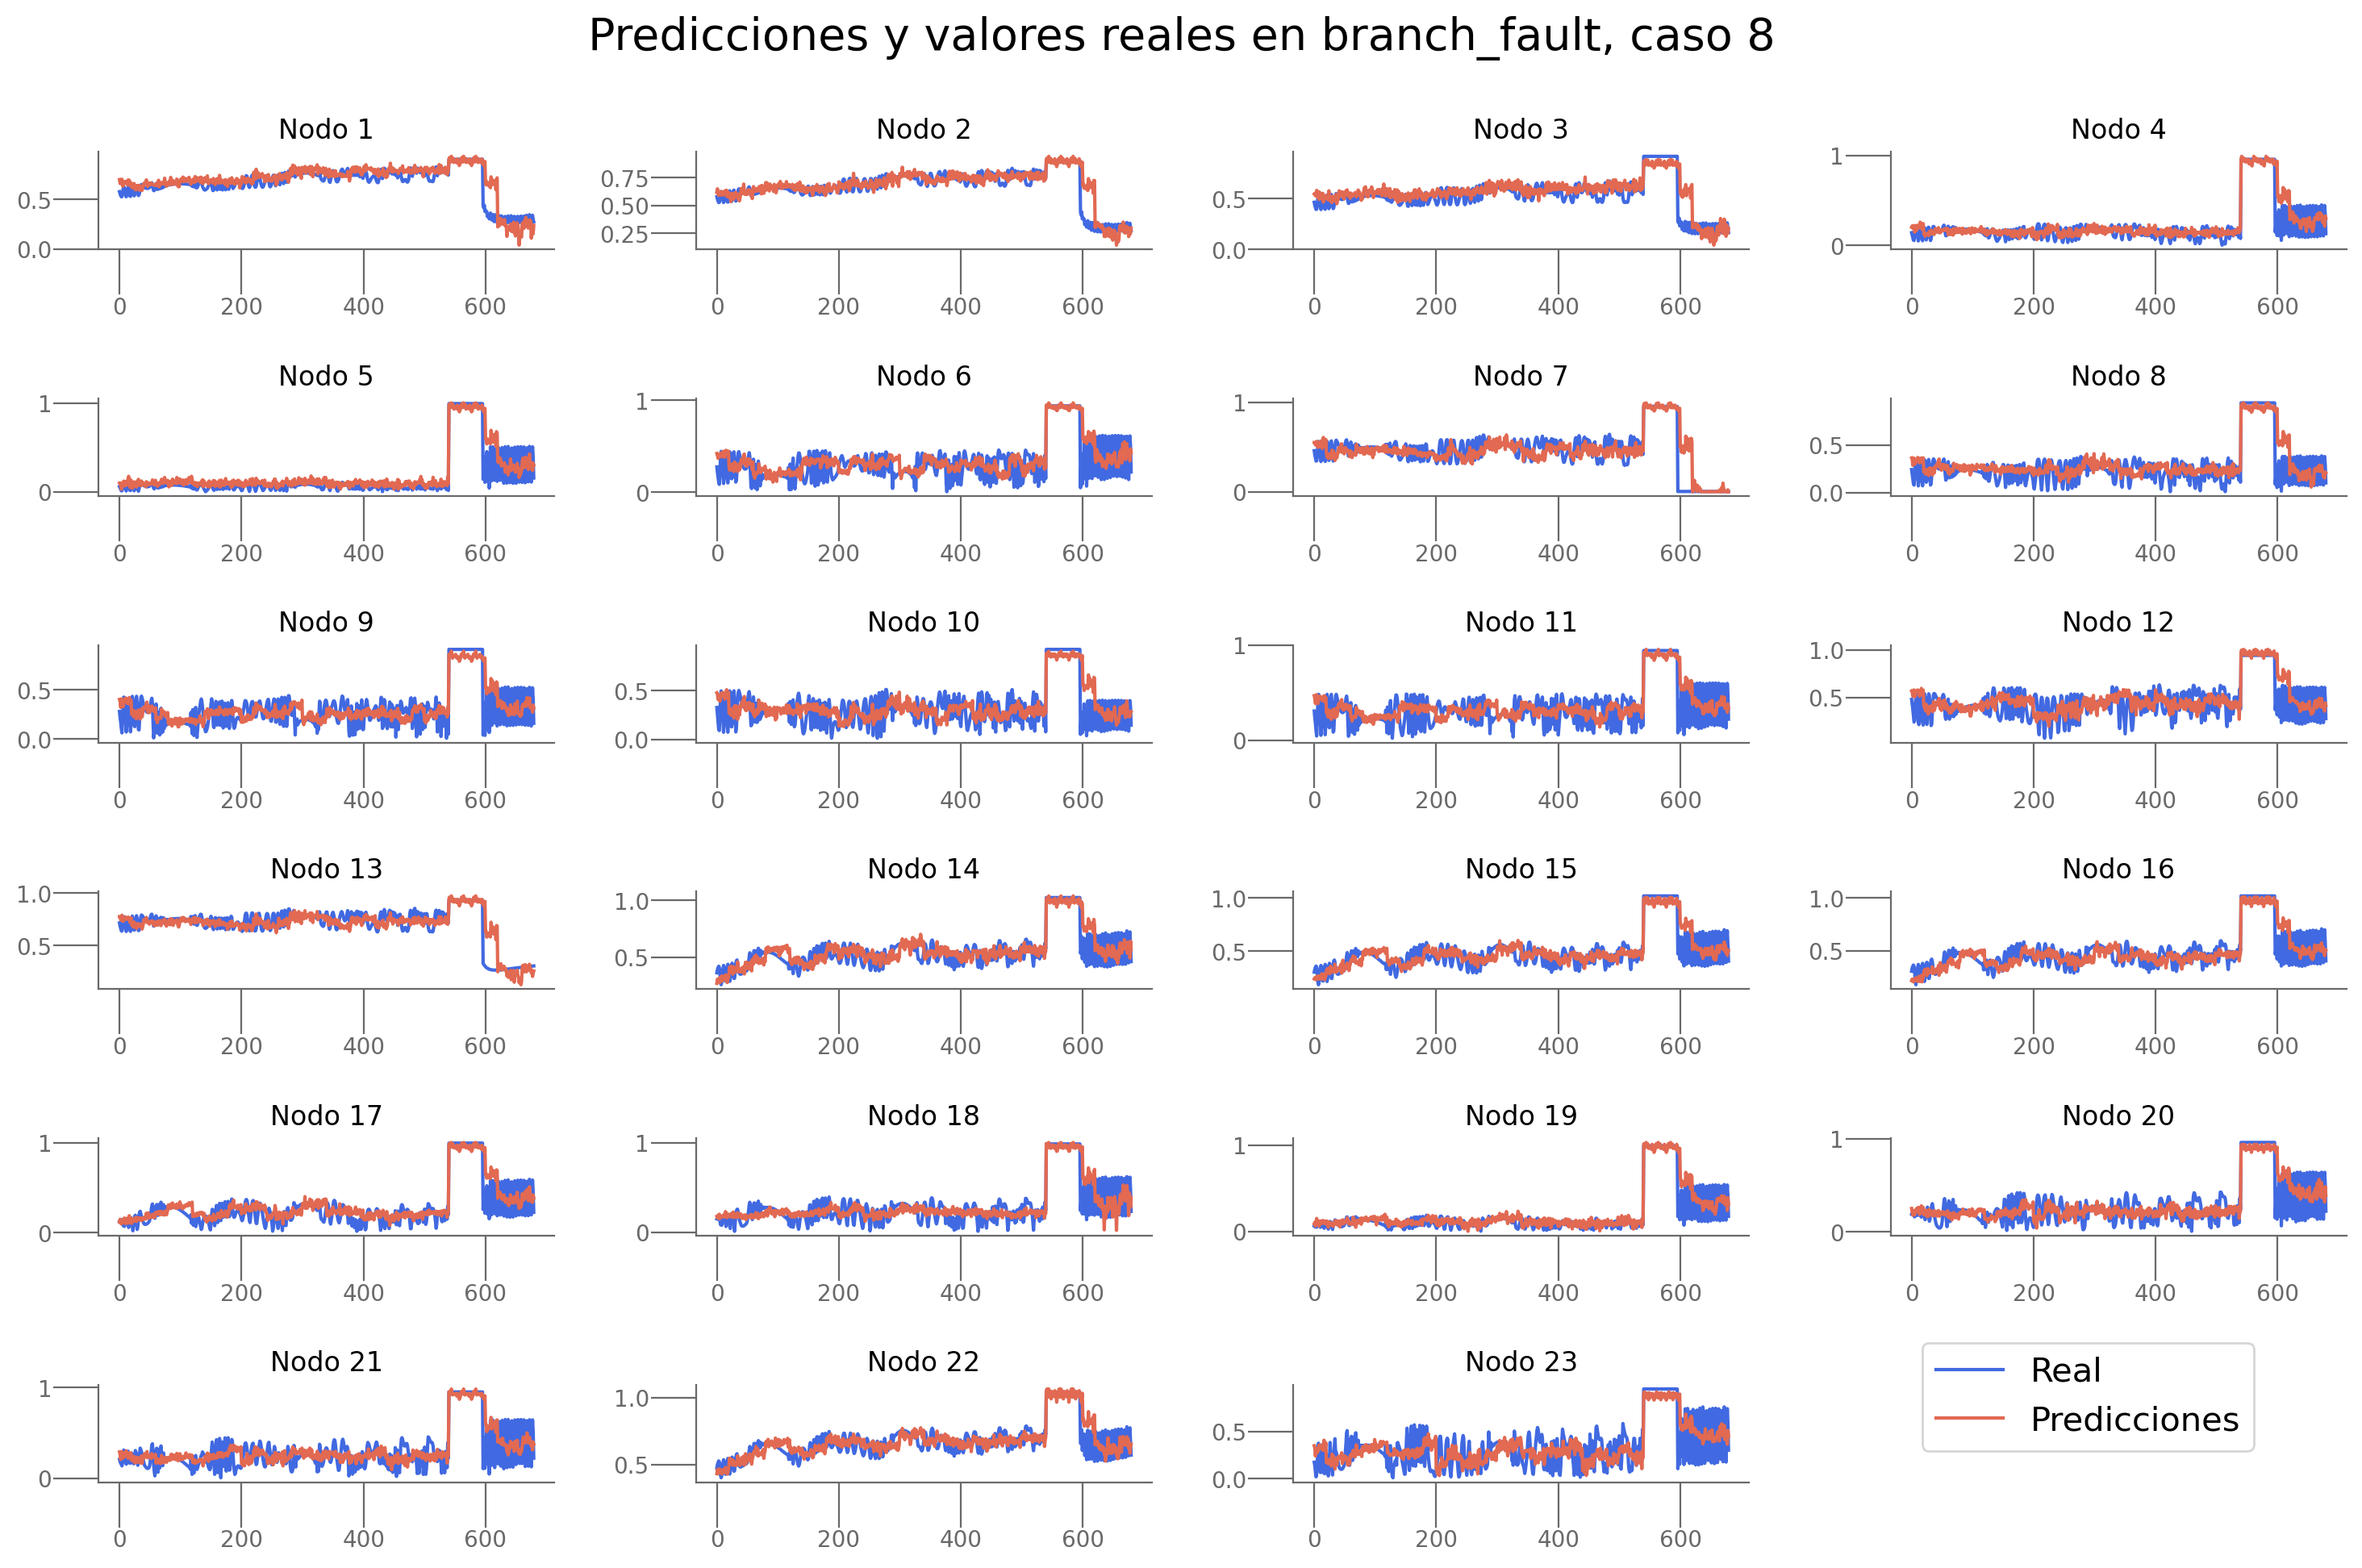

In [36]:
plot_predictions(predictions_brf_ajuste, real_brf_ajuste, n_target, 8, n_div_brf, problem_brf)

In [37]:
path_save_experiment_brf = results_save_path+f"/{problem_brf}"+ f"/ajustes/{name_model}_results.csv"
resultados_brf.to_csv(path_save_experiment_brf, index=False)

In [38]:
trainer_brf.save_model(path_save_experiment=path_save_experiment_brf, params=params_brf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
3     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.023216  0.608045   
1                                                NaN  0.021628 -1.528487   
2  ./results/branch_fault/ajustes/DryGrEncoder_re...  0.020580 -1.669938   
3  ./results/branch_fault/ajustes/MPNNLSTM_result...  0.021592 -1.565135   
4   ./results/branch_fault/ajustes/AGCRN_results.csv  0.024755  0

### Branch trip

In [39]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [40]:
n_div_brt = loader.div
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [41]:

device =  torch.device("cpu")
model_brt = RecurrentGCN(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)


trainer_brt = TrainerMSTGCN(model_brt, dataset_brt,device, f"./results/{problem_brt}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_brt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQuissss

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1916 | Eval Loss: 0.0999 | Eval R2: -68.3384 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.0910 | Eval Loss: 0.0937 | Eval R2: -63.6335 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.0903 | Eval Loss: 0.0938 | Eval R2: -63.9079 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.0902 | Eval Loss: 0.0939 | Eval R2: -64.1165 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.2450 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3195 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3603 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3798 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3857 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0

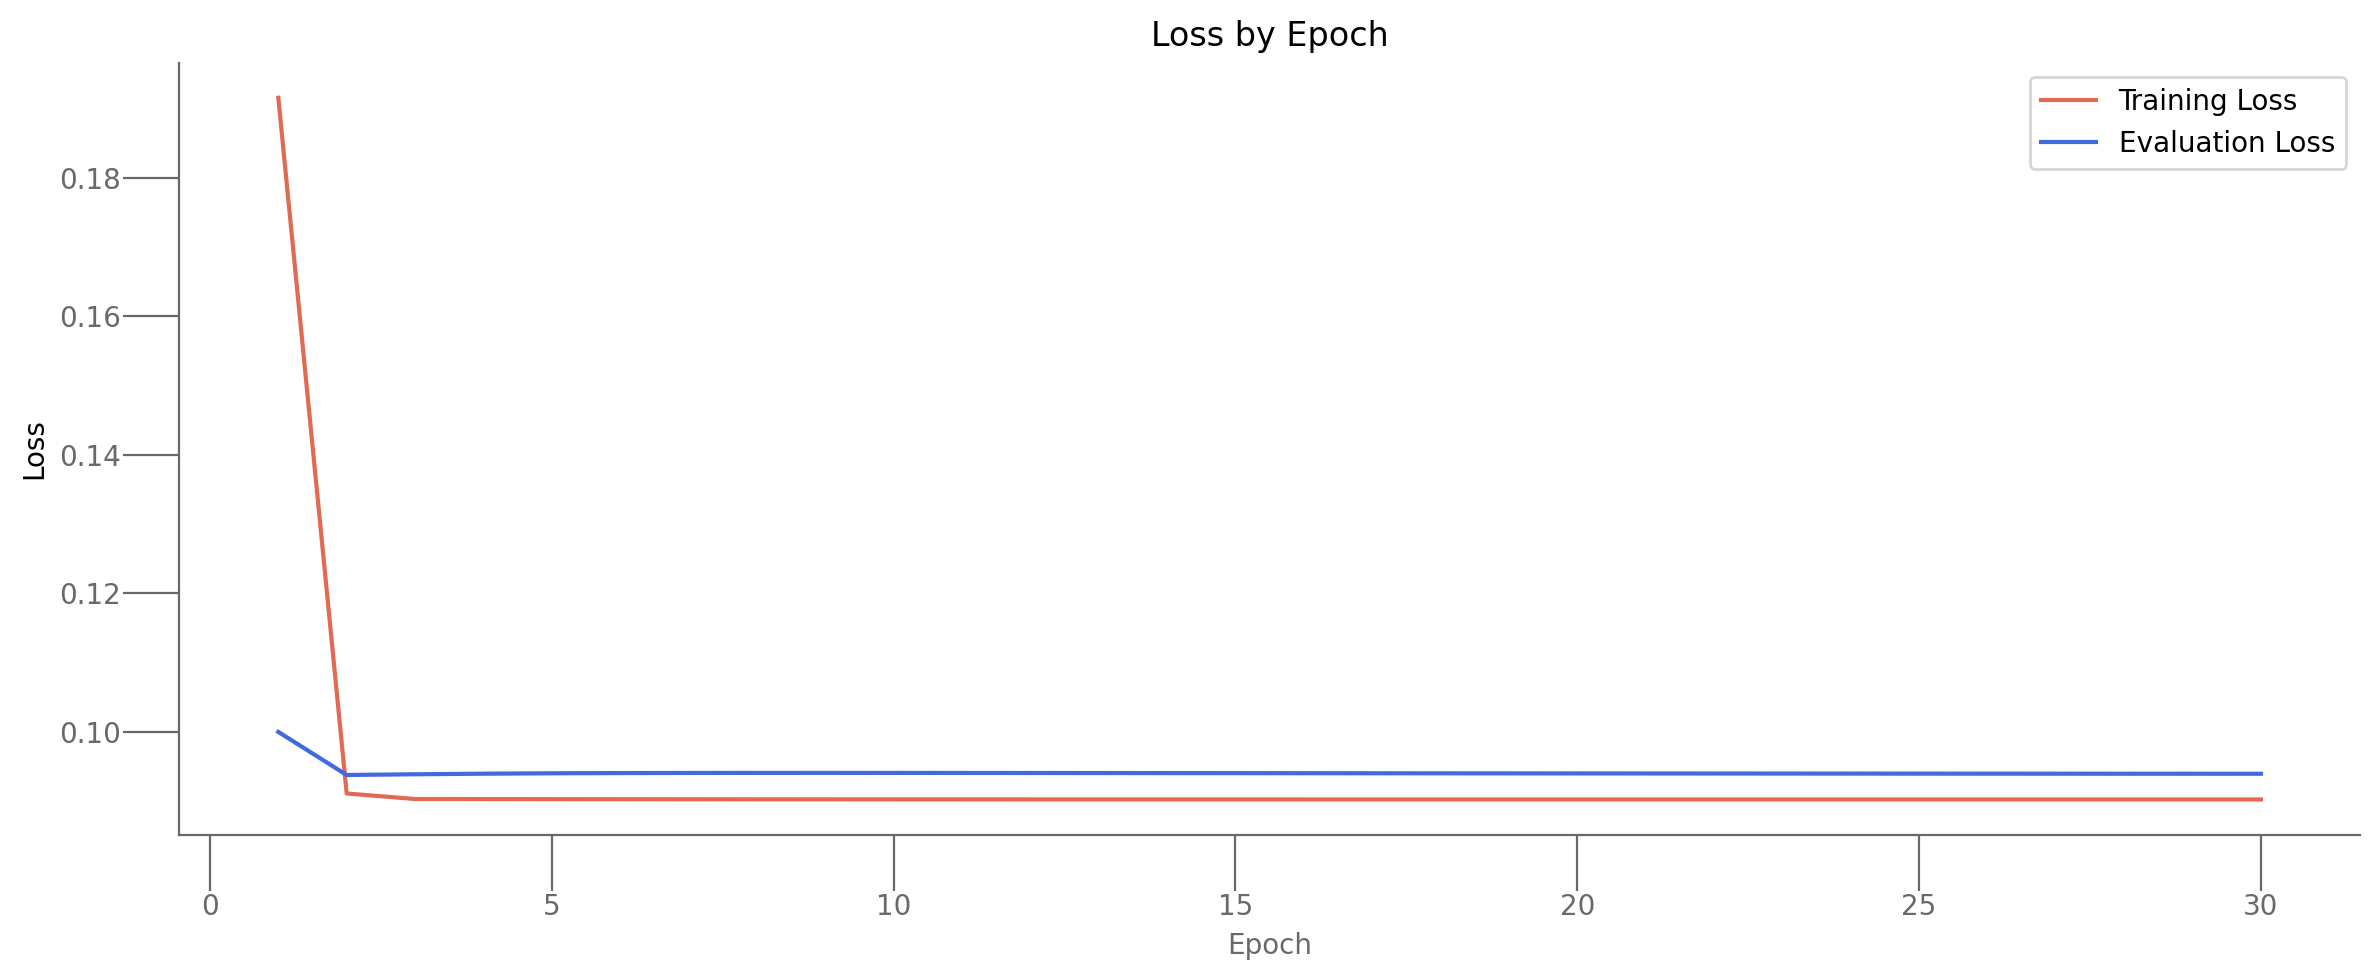


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.103355, test r2score -70.255618


In [42]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brt, real_brt = trainer_brt.test()

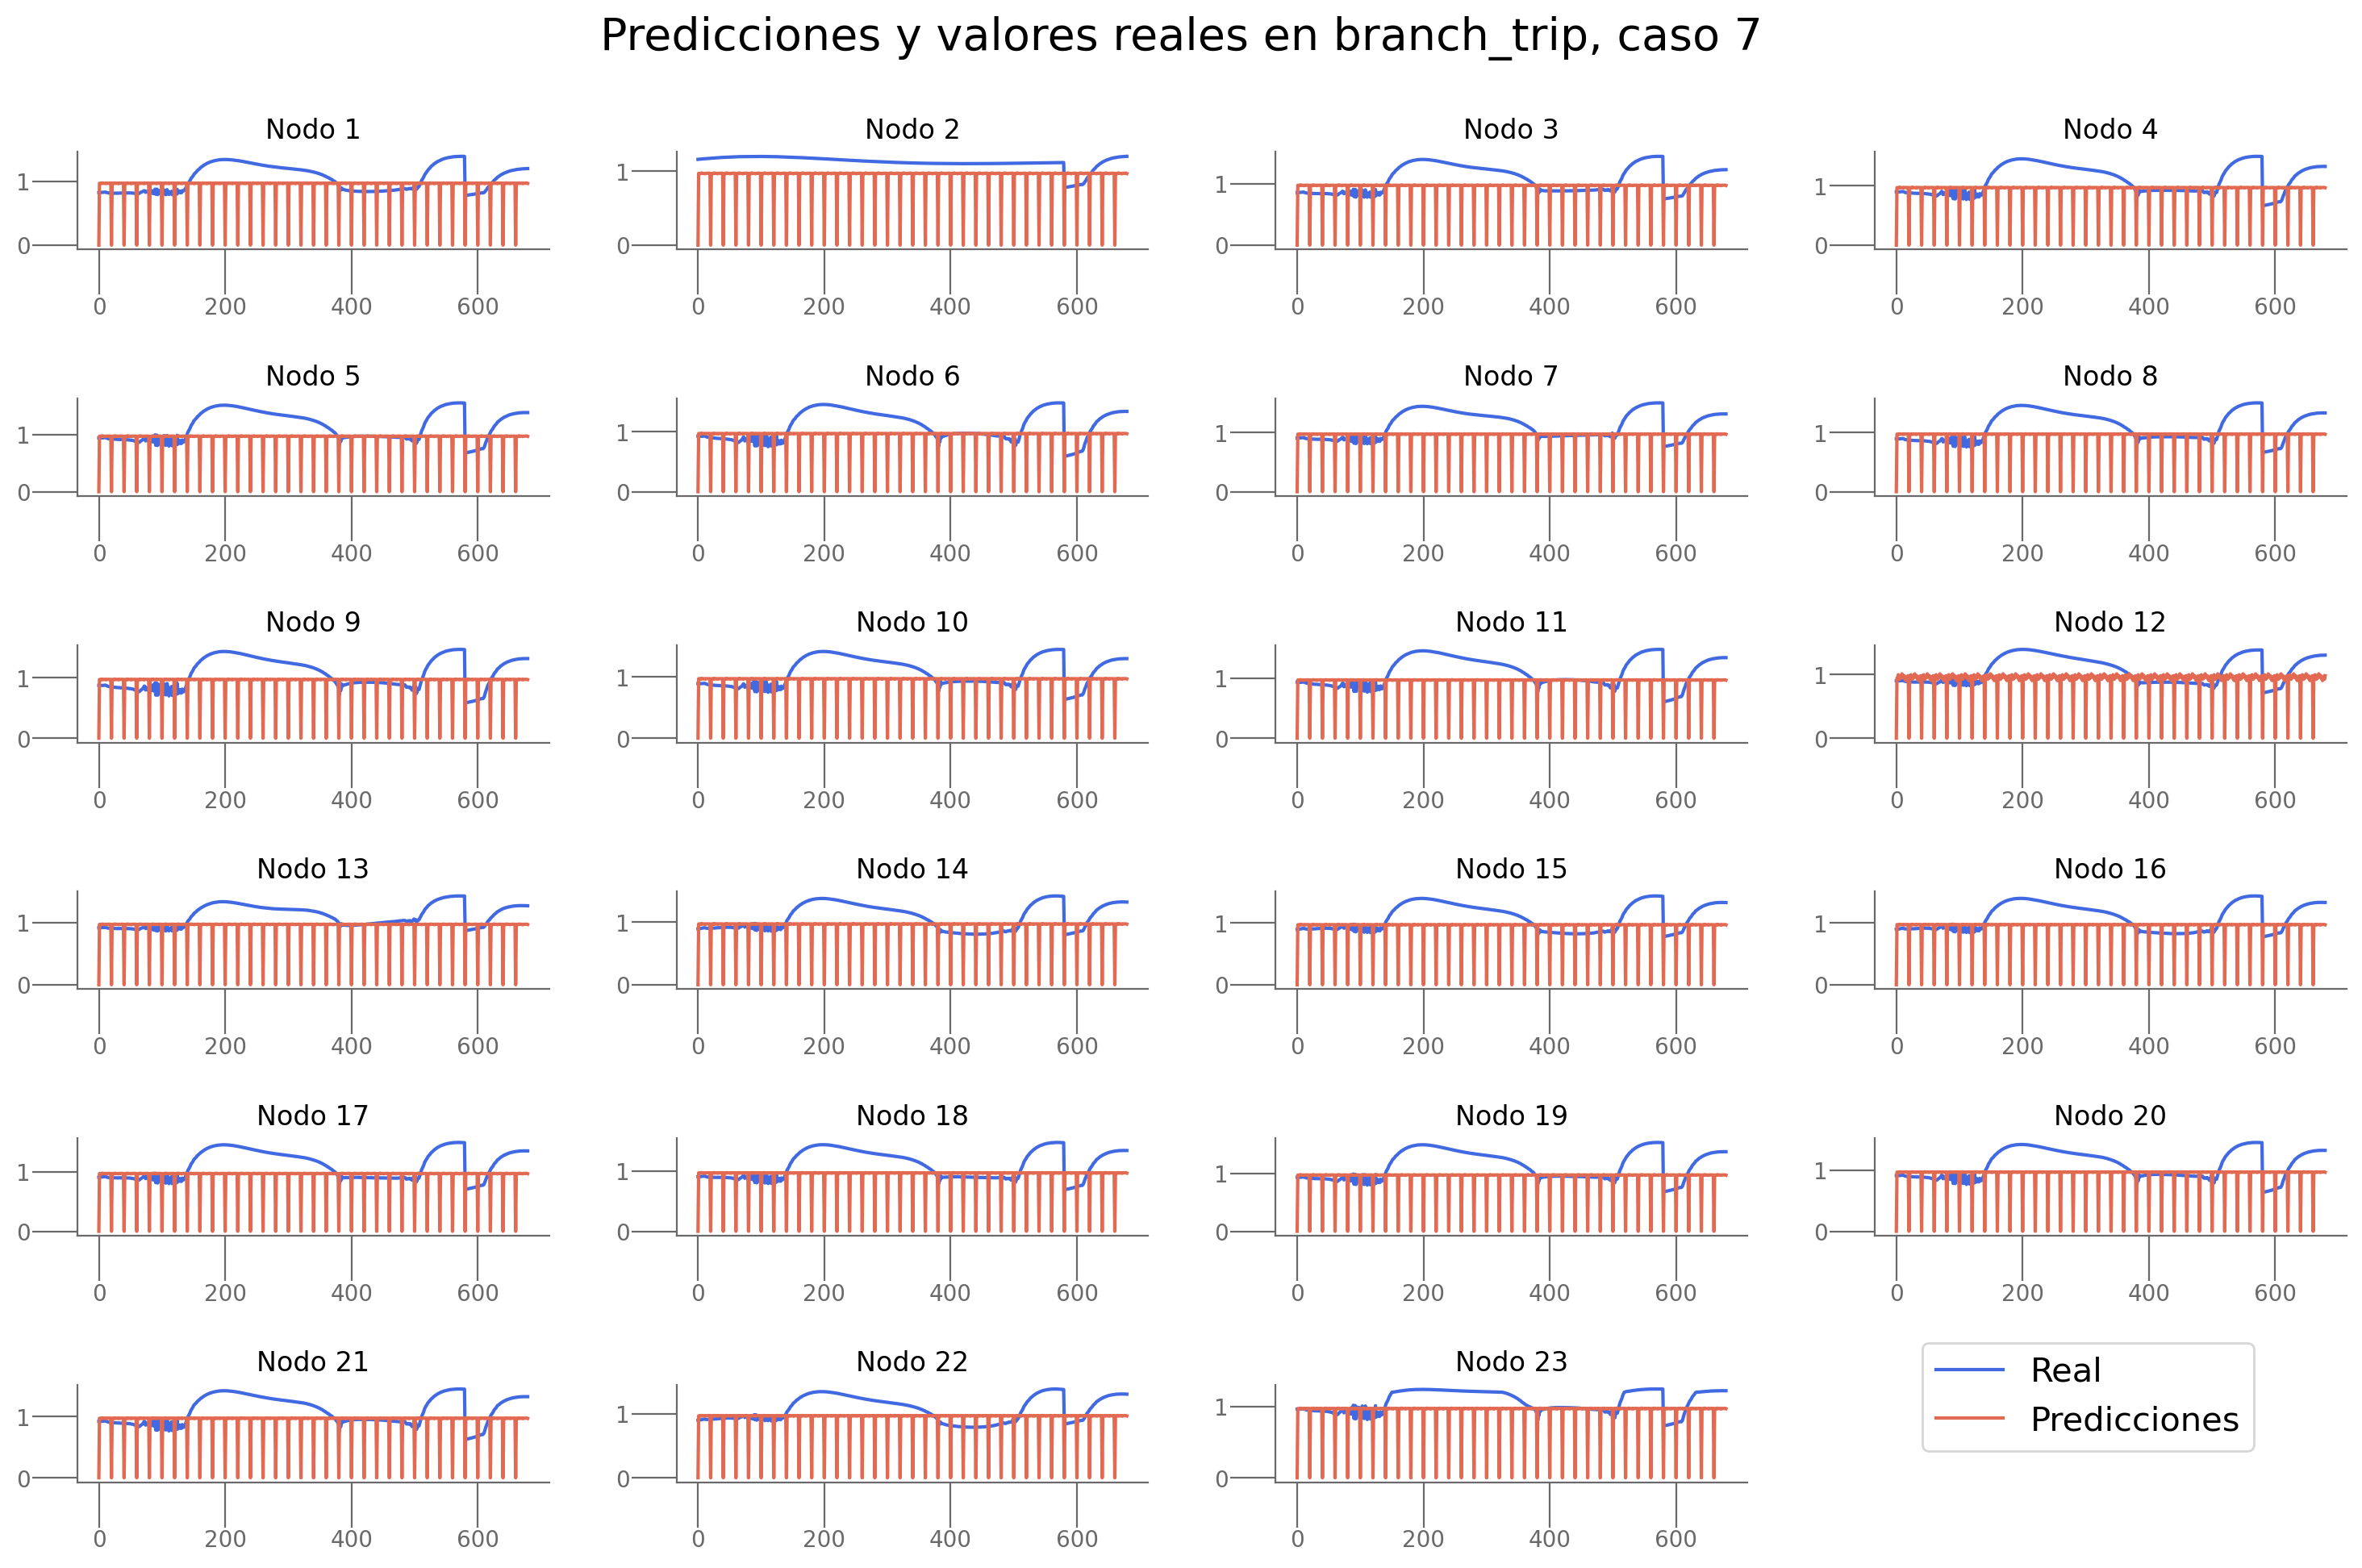

In [43]:
plot_predictions(predictions_brt, real_brt, n_target, 7, n_div_brt, problem_brt)

#### Ajuste de parámetros 

In [44]:

param_grid = {
    "nb_block": [1, 2, 3],
    "filter": [2,4,8],
    "time_strides": [1, 2, 4]
}

num_epochs = 100
num_early_stop = 10

trainer_brt,params_brt,resultados_final_brt, resultados_brt = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_brt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brt)

  0%|          | 0/27 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQuissss

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.4402 | Eval Loss: 0.3178 | Eval R2: -242.1073 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.2951 | Eval Loss: 0.2815 | Eval R2: -219.6801 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.2461 | Eval Loss: 0.2297 | Eval R2: -171.7557 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.1865 | Eval Loss: 0.1507 | Eval R2: -105.8432 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.1486 | Eval Loss: 0.1444 | Eval R2: -103.7694 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.1398 | Eval Loss: 0.1400 | Eval R2: -100.4276 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.1314 | Eval Loss: 0.1112 | Eval R2: -74.4656 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.1010 | Eval Loss: 0.0954 | Eval R2: -62.5699 | LR: 0.0010 | 
Epoch 9/100 | Tr

  4%|▎         | 1/27 [03:44<1:37:22, 224.72s/it]

preds:  (1, 23, 20)
test loss: 0.036259, test r2score -15.788092
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.0335204117000103, 'r2_eval_final': -14.300846099853516, 'loss_eval_final': 0.03285679966211319, 'r2_test': -15.788091732441774, 'loss_test': 0.03625885024666786, 'loss_nodes': [[0.0352349579334259, 0.038864657282829285, 0.03384075313806534, 0.034355975687503815, 0.039211906492710114, 0.03429955244064331, 0.038025956600904465, 0.045258983969688416, 0.03378855437040329, 0.035536810755729675, 0.036408450454473495, 0.03584543988108635, 0.03883425146341324, 0.03281264007091522, 0.03423226997256279, 0.032044120132923126, 0.03651228919625282, 0.033641356974840164, 0.04089593514800072, 0.03553213179111481]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQuiss

  7%|▋         | 2/27 [07:05<1:27:52, 210.91s/it]

preds:  (1, 23, 20)
test loss: 0.046774, test r2score -19.156651
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.03954644128680229, 'r2_eval_final': -17.592458724975586, 'loss_eval_final': 0.041558779776096344, 'r2_test': -19.156651113781678, 'loss_test': 0.04677412286400795, 'loss_nodes': [[0.046787019819021225, 0.05103837698698044, 0.0452817939221859, 0.048361632972955704, 0.05007918179035187, 0.04766514524817467, 0.04849919304251671, 0.04431096464395523, 0.049193356186151505, 0.04378337413072586, 0.05169033259153366, 0.04346034303307533, 0.045905500650405884, 0.04342958703637123, 0.04676855355501175, 0.04366271570324898, 0.045111462473869324, 0.04833362251520157, 0.047799378633499146, 0.04432081803679466]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQuisss

 11%|█         | 3/27 [10:22<1:21:42, 204.29s/it]

preds:  (1, 23, 20)
test loss: 0.048175, test r2score -19.725577
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.04034457355737686, 'r2_eval_final': -18.254575729370117, 'loss_eval_final': 0.042986348271369934, 'r2_test': -19.725577105238937, 'loss_test': 0.048174504190683365, 'loss_nodes': [[0.04794597253203392, 0.04824548214673996, 0.04796489700675011, 0.04834454134106636, 0.04787110164761543, 0.04862573370337486, 0.04898038133978844, 0.04839497432112694, 0.04843932017683983, 0.04784431681036949, 0.048054493963718414, 0.04783486947417259, 0.04871717467904091, 0.04768035188317299, 0.047700461000204086, 0.04761281982064247, 0.047708529978990555, 0.04849784076213837, 0.04852183163166046, 0.04850514978170395]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQuissss

 15%|█▍        | 4/27 [14:07<1:21:25, 212.41s/it]

preds:  (1, 23, 20)
test loss: 0.115708, test r2score -99.085406
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.10812491923570633, 'r2_eval_final': -89.80985260009766, 'loss_eval_final': 0.10898352414369583, 'r2_test': -99.08540593278029, 'loss_test': 0.11570785939693451, 'loss_nodes': [[0.00222762580960989, 0.0019329169299453497, 0.0024289186112582684, 0.003514329669997096, 0.004777736030519009, 1.1023434400558472, 0.0034075197763741016, 0.005573038011789322, 0.004294109530746937, 0.004782731179147959, 1.1062639951705933, 0.005000405013561249, 0.007308624219149351, 0.0068425871431827545, 0.007770898751914501, 0.00937276054173708, 0.009602858684957027, 0.008717404678463936, 0.008025139570236206, 0.009970547631382942]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 5

 19%|█▊        | 5/27 [17:32<1:16:58, 209.95s/it]

preds:  (1, 23, 20)
test loss: 0.228614, test r2score -196.859471
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.21253840625286102, 'r2_eval_final': -177.83653259277344, 'loss_eval_final': 0.21519386768341064, 'r2_test': -196.85947063709136, 'loss_test': 0.22861433029174805, 'loss_nodes': [[1.1002461910247803, 0.002889525145292282, 0.005032949149608612, 0.004597348161041737, 0.01324163656681776, 0.007786969654262066, 0.004788607824593782, 0.0066320630721747875, 0.004565304145216942, 0.01106045488268137, 0.006663705222308636, 0.009841788560152054, 0.019152482971549034, 0.010780093260109425, 1.1079872846603394, 0.015130633488297462, 0.010578400455415249, 1.109832525253296, 1.1102263927459717, 0.01125274132937193]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQu

 22%|██▏       | 6/27 [20:42<1:11:01, 202.93s/it]

preds:  (1, 23, 20)
test loss: 0.117394, test r2score -99.993278
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.10903703421354294, 'r2_eval_final': -90.69417572021484, 'loss_eval_final': 0.11011774092912674, 'r2_test': -99.99327781823207, 'loss_test': 0.11739372462034225, 'loss_nodes': [[0.004226468503475189, 0.004007307346910238, 0.004212601110339165, 0.00401740288361907, 0.005058798938989639, 0.006491301115602255, 0.005990343634039164, 0.0052140746265649796, 0.008872675709426403, 0.005854146555066109, 1.1062639951705933, 0.008101647719740868, 1.1068673133850098, 0.007702855858951807, 0.00936821848154068, 0.009622174315154552, 0.010034487582743168, 0.012218642048537731, 0.01183492224663496, 0.011915610171854496]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
A

 26%|██▌       | 7/27 [24:46<1:12:12, 216.62s/it]

preds:  (1, 23, 20)
test loss: 0.225286, test r2score -195.773271
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.21066373586654663, 'r2_eval_final': -177.61607360839844, 'loss_eval_final': 0.2127142995595932, 'r2_test': -195.77327120577718, 'loss_test': 0.22528551518917084, 'loss_nodes': [[0.0013243404682725668, 0.002730055246502161, 1.1014405488967896, 0.0026088538579642773, 0.003484237939119339, 0.0026682799216359854, 0.004515739623457193, 0.005442214664071798, 1.1048777103424072, 0.0032197029795497656, 1.1062639951705933, 0.005428341217339039, 0.006915186066180468, 0.005249373149126768, 1.1079872846603394, 0.008546045050024986, 0.008495052345097065, 0.006755528971552849, 0.007346730213612318, 0.01041165180504322]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 50

 30%|██▉       | 8/27 [28:30<1:09:20, 218.95s/it]

preds:  (1, 23, 20)
test loss: 0.170640, test r2score -147.255089
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.15918782353401184, 'r2_eval_final': -133.2609100341797, 'loss_eval_final': 0.16071464121341705, 'r2_test': -147.25508912139023, 'loss_test': 0.1706395000219345, 'loss_nodes': [[0.002406393177807331, 0.0037059050519019365, 0.002927684923633933, 0.002801104448735714, 0.0032885775435715914, 0.0038085216656327248, 1.103119969367981, 0.003880484728142619, 0.003872938919812441, 0.004188490565866232, 0.00603264756500721, 0.005491937510669231, 0.00535177206620574, 1.1077286005020142, 0.006206311285495758, 1.1091620922088623, 0.007341594435274601, 0.008044585585594177, 0.013694753870368004, 0.009737313725054264]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505


 33%|███▎      | 9/27 [31:51<1:04:00, 213.34s/it]

preds:  (1, 23, 20)
test loss: 0.006563, test r2score -2.801232
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.005543755833059549, 'r2_eval_final': -2.3757052421569824, 'loss_eval_final': 0.005475376732647419, 'r2_test': -2.8012319923338116, 'loss_test': 0.006563109345734119, 'loss_nodes': [[0.004176648333668709, 0.003581558121368289, 0.005990992765873671, 0.004413128364831209, 0.003493966069072485, 0.003204718930646777, 0.0056317956186831, 0.0036603552289307117, 0.005372273735702038, 0.005720062647014856, 0.00834055058658123, 0.006941809318959713, 0.007587790954858065, 0.0075628445483744144, 0.008201678283512592, 0.00739687355235219, 0.010860162787139416, 0.009644855745136738, 0.00898356456309557, 0.010496553964912891]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset

 37%|███▋      | 10/27 [39:06<1:19:47, 281.62s/it]

preds:  (1, 23, 20)
test loss: 0.100621, test r2score -66.826892
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.09028596431016922, 'r2_eval_final': -61.1788444519043, 'loss_eval_final': 0.0930304005742073, 'r2_test': -66.82689227625994, 'loss_test': 0.10062127560377121, 'loss_nodes': [[0.04790008068084717, 1.100142240524292, 0.04760764539241791, 0.04789271950721741, 0.04808592051267624, 0.04853152856230736, 0.04887684807181358, 0.04829046502709389, 0.04845228046178818, 0.048078786581754684, 0.04785730689764023, 0.04778304323554039, 0.048313263803720474, 0.047553665935993195, 0.04751565307378769, 0.047759298235177994, 0.04722117260098457, 0.04832816496491432, 0.04815997928380966, 0.04807601496577263]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQuissss

=====

 41%|████      | 11/27 [45:19<1:22:33, 309.60s/it]

preds:  (1, 23, 20)
test loss: 0.100907, test r2score -67.257811
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.08991604298353195, 'r2_eval_final': -61.509559631347656, 'loss_eval_final': 0.09307637810707092, 'r2_test': -67.25781114007748, 'loss_test': 0.10090678185224533, 'loss_nodes': [[1.1002461910247803, 0.048418451100587845, 0.04802379384636879, 0.04829205200076103, 0.04835986718535423, 0.04852137714624405, 0.04926235228776932, 0.04850521683692932, 0.04853527992963791, 0.04841290041804314, 0.047848619520664215, 0.04832039400935173, 0.04882202669978142, 0.04766283184289932, 0.047872189432382584, 0.04801478981971741, 0.04754744842648506, 0.04838775098323822, 0.04845690727233887, 0.04862513020634651]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQuissss

==

 44%|████▍     | 12/27 [51:15<1:20:57, 323.87s/it]

preds:  (1, 23, 20)
test loss: 0.365863, test r2score -304.740777
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.3382430374622345, 'r2_eval_final': -276.3807678222656, 'loss_eval_final': 0.343760222196579, 'r2_test': -304.7407771371382, 'loss_test': 0.3658626079559326, 'loss_nodes': [[0.048138026148080826, 0.048532549291849136, 0.04786733537912369, 1.1008520126342773, 0.04829377308487892, 0.048521507531404495, 0.04941026493906975, 0.04862416908144951, 1.1048777103424072, 0.048093199729919434, 0.04810626432299614, 1.1064702272415161, 0.0485820546746254, 0.047515515238046646, 1.1079872846603394, 0.04787848889827728, 1.1098638772964478, 0.048586491495370865, 0.048355914652347565, 1.1106971502304077]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQuissss

========

 48%|████▊     | 13/27 [58:26<1:23:07, 356.24s/it]

preds:  (1, 23, 20)
test loss: 0.171984, test r2score -148.123236
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.16046379506587982, 'r2_eval_final': -134.30917358398438, 'loss_eval_final': 0.16229084134101868, 'r2_test': -148.12323561121406, 'loss_test': 0.1719842553138733, 'loss_nodes': [[0.00487334793433547, 0.0053833285346627235, 0.0033168932422995567, 1.1008520126342773, 1.1019717454910278, 0.0037700850516557693, 0.005569118075072765, 0.006659833248704672, 0.005286119412630796, 0.006911355070769787, 0.008619481697678566, 0.007257514167577028, 0.009955442510545254, 0.007936009205877781, 0.007672840729355812, 0.008838043548166752, 0.011291280388832092, 1.109832525253296, 0.012887237593531609, 0.010801320895552635]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 50

 52%|█████▏    | 14/27 [1:04:49<1:18:55, 364.25s/it]

preds:  (1, 23, 20)
test loss: 0.008573, test r2score -4.096304
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.0069365608505904675, 'r2_eval_final': -3.475008249282837, 'loss_eval_final': 0.00704938406124711, 'r2_test': -4.096303898838178, 'loss_test': 0.008572876453399658, 'loss_nodes': [[0.0035191213246434927, 0.006232247222214937, 0.004595235455781221, 0.005524325650185347, 0.007149579469114542, 0.005999809596687555, 0.006379764527082443, 0.009438302367925644, 0.0075463708490133286, 0.007946505211293697, 0.007572067901492119, 0.00851612351834774, 0.01125705149024725, 0.009531778283417225, 0.009103773161768913, 0.011687103658914566, 0.012418635189533234, 0.012697050347924232, 0.012816987931728363, 0.011525685898959637]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test datase

 56%|█████▌    | 15/27 [1:10:37<1:11:51, 359.31s/it]

preds:  (1, 23, 20)
test loss: 0.010457, test r2score -4.810038
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.008966672234237194, 'r2_eval_final': -4.165241718292236, 'loss_eval_final': 0.008649704046547413, 'r2_test': -4.810037884986444, 'loss_test': 0.01045718789100647, 'loss_nodes': [[0.00781997200101614, 0.0043339356780052185, 0.0058882953599095345, 0.009153428487479687, 0.008300233632326126, 0.009976914152503014, 0.006103230640292168, 0.008006270974874496, 0.012147345580160618, 0.011172926053404808, 0.010419556871056557, 0.014222378842532635, 0.011690007522702217, 0.011149649508297443, 0.011563165113329887, 0.010692543350160122, 0.016940969973802567, 0.01291339099407196, 0.012758543714880943, 0.013890929520130157]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset

 59%|█████▉    | 16/27 [1:19:03<1:13:58, 403.48s/it]

preds:  (1, 23, 20)
test loss: 0.115183, test r2score -98.708864
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.10773169994354248, 'r2_eval_final': -89.7874984741211, 'loss_eval_final': 0.10878986865282059, 'r2_test': -98.70886394003503, 'loss_test': 0.11518293619155884, 'loss_nodes': [[1.1002461910247803, 0.0025043152272701263, 0.005505200941115618, 0.0034418264403939247, 0.004090896341949701, 0.00279695144854486, 0.003660860937088728, 0.003995859995484352, 0.003868072759360075, 0.004689161200076342, 0.004952006042003632, 0.0059065064415335655, 0.005685132462531328, 1.1077286005020142, 0.007231016643345356, 0.006305973511189222, 0.007900170981884003, 0.006982290185987949, 0.007938637398183346, 0.008228492923080921]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 50

 63%|██████▎   | 17/27 [1:26:10<1:08:26, 410.65s/it]

preds:  (1, 23, 20)
test loss: 0.004046, test r2score -1.404433
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.0036406926810741425, 'r2_eval_final': -1.1720095872879028, 'loss_eval_final': 0.003605610691010952, 'r2_test': -1.4044328116222906, 'loss_test': 0.004046416841447353, 'loss_nodes': [[0.0014760084450244904, 0.0018567832885310054, 0.0018360244575887918, 0.002223170828074217, 0.0021408740431070328, 0.0024697785265743732, 0.0028655885253101587, 0.003072400577366352, 0.0030679688788950443, 0.0033255356829613447, 0.0034876910503953695, 0.00462654884904623, 0.004377938807010651, 0.005212489049881697, 0.005504698492586613, 0.005897722207009792, 0.006677804049104452, 0.0063531119376420975, 0.006776501890271902, 0.007679704576730728]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510

 67%|██████▋   | 18/27 [1:32:29<1:00:09, 401.11s/it]

preds:  (1, 23, 20)
test loss: 0.170681, test r2score -147.656325
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.1596667468547821, 'r2_eval_final': -134.02293395996094, 'loss_eval_final': 0.16101296246051788, 'r2_test': -147.656324956287, 'loss_test': 0.17068056762218475, 'loss_nodes': [[1.1002461910247803, 0.003527785651385784, 0.0034806695766747, 0.0035638026893138885, 1.1019717454910278, 0.003807640401646495, 0.003995590377599001, 0.005025582853704691, 1.1048777103424072, 0.0048846774734556675, 0.005103532690554857, 0.00655494024977088, 0.0051168762147426605, 0.007017737720161676, 0.007706816773861647, 0.010185102932155132, 0.008168451488018036, 0.00987000297755003, 0.008787513710558414, 0.00971890240907669]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQu

 70%|███████   | 19/27 [1:43:25<1:03:40, 477.62s/it]

preds:  (1, 23, 20)
test loss: 0.206687, test r2score -162.142311
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.18954379856586456, 'r2_eval_final': -147.0338592529297, 'loss_eval_final': 0.1932707577943802, 'r2_test': -162.1423113604719, 'loss_test': 0.2066871076822281, 'loss_nodes': [[1.1002461910247803, 0.047985732555389404, 0.04758232459425926, 0.04786526411771774, 0.0484955795109272, 0.048234015703201294, 0.04900337755680084, 0.049354542046785355, 0.04830189049243927, 1.105556845664978, 0.04799201712012291, 0.0477805994451046, 0.04893515631556511, 0.04727303609251976, 0.04748298227787018, 0.047461263835430145, 0.04743529111146927, 0.04823804646730423, 1.1102263927459717, 0.048291221261024475]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQuissss

=======

 74%|███████▍  | 20/27 [1:52:41<58:28, 501.17s/it]  

preds:  (1, 23, 20)
test loss: 0.312052, test r2score -256.909531
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.28883096575737, 'r2_eval_final': -234.0556182861328, 'loss_eval_final': 0.29343825578689575, 'r2_test': -256.9095312263013, 'loss_test': 0.3120521008968353, 'loss_nodes': [[1.1002461910247803, 0.04824655130505562, 0.047873567789793015, 1.1008520126342773, 0.047797366976737976, 0.04837701842188835, 0.048986729234457016, 0.04852845519781113, 0.04824686050415039, 0.047963645309209824, 1.1062639951705933, 1.1064702272415161, 1.1068673133850098, 0.0475408211350441, 0.04767203330993652, 0.0474967285990715, 0.047247372567653656, 0.048135027289390564, 0.04818134754896164, 0.04804939404129982]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQuissss

=========

 78%|███████▊  | 21/27 [2:01:00<50:02, 500.39s/it]

preds:  (1, 23, 20)
test loss: 0.101085, test r2score -67.601100
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.08974596858024597, 'r2_eval_final': -61.53793716430664, 'loss_eval_final': 0.09301968663930893, 'r2_test': -67.60109986972788, 'loss_test': 0.10108505934476852, 'loss_nodes': [[0.04817425087094307, 0.04885035753250122, 0.04801448807120323, 0.04840540513396263, 0.04819200932979584, 0.048464901745319366, 1.103119969367981, 0.048617567867040634, 0.048486895859241486, 0.048648733645677567, 0.048043280839920044, 0.048197418451309204, 0.0490230955183506, 0.04757235199213028, 0.04795248433947563, 0.04788915440440178, 0.04785129427909851, 0.04869896546006203, 0.04868968576192856, 0.04880917817354202]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQuissss

==

 81%|████████▏ | 22/27 [2:11:51<45:28, 545.64s/it]

preds:  (1, 23, 20)
test loss: 0.012712, test r2score -5.709195
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.01182690542191267, 'r2_eval_final': -4.999608039855957, 'loss_eval_final': 0.010938668623566628, 'r2_test': -5.709195291717032, 'loss_test': 0.012712276540696621, 'loss_nodes': [[0.00925199780613184, 0.00837839487940073, 0.011185788549482822, 0.01068901177495718, 0.009593662805855274, 0.010141292586922646, 0.010878246277570724, 0.011053028516471386, 0.010545065626502037, 0.013490509241819382, 0.01216116826981306, 0.012558488175272942, 0.014140048064291477, 0.012800853699445724, 0.015436537563800812, 0.01612263359129429, 0.01630009338259697, 0.014535723254084587, 0.015840280801057816, 0.019142724573612213]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505


 85%|████████▌ | 23/27 [2:21:12<36:40, 550.20s/it]

preds:  (1, 23, 20)
test loss: 0.064482, test r2score -52.543627
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.05981719493865967, 'r2_eval_final': -47.59717559814453, 'loss_eval_final': 0.0601298026740551, 'r2_test': -52.543627062211684, 'loss_test': 0.06448215991258621, 'loss_nodes': [[0.006511124316602945, 0.003980980720371008, 0.008646382950246334, 0.007364457938820124, 0.0068232230842113495, 1.1023434400558472, 0.009477658197283745, 0.01089336909353733, 0.007472113706171513, 0.011666007339954376, 0.00987416785210371, 0.008337915875017643, 0.009898465126752853, 0.009769412688910961, 0.011337081901729107, 0.014538392424583435, 0.011039691045880318, 0.013178916648030281, 0.013197704218327999, 0.013293446972966194]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 50

 89%|████████▉ | 24/27 [2:29:52<27:03, 541.29s/it]

preds:  (1, 23, 20)
test loss: 0.011969, test r2score -5.697592
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.010498672723770142, 'r2_eval_final': -4.98458194732666, 'loss_eval_final': 0.009848999790847301, 'r2_test': -5.6975920817579375, 'loss_test': 0.011969207786023617, 'loss_nodes': [[0.008952423930168152, 0.007714930456131697, 0.008388449437916279, 0.008783802390098572, 0.008958650752902031, 0.010478570125997066, 0.012017720378935337, 0.010942241176962852, 0.010019717738032341, 0.010620743036270142, 0.011756733991205692, 0.014911108650267124, 0.011954016052186489, 0.012378949671983719, 0.014958647079765797, 0.014495013281702995, 0.015145591460168362, 0.01617058552801609, 0.014776899479329586, 0.015959331765770912]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset

 93%|█████████▎| 25/27 [2:42:33<20:14, 607.16s/it]

preds:  (1, 23, 20)
test loss: 0.116802, test r2score -99.612547
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.10918185114860535, 'r2_eval_final': -90.44522094726562, 'loss_eval_final': 0.10988466441631317, 'r2_test': -99.61254705672707, 'loss_test': 0.11680196970701218, 'loss_nodes': [[0.003745255060493946, 0.003680015215650201, 0.004757366608828306, 0.005021204706281424, 0.004578391555696726, 0.006028501316905022, 0.005470968782901764, 0.006662920583039522, 0.005387819372117519, 0.006288089789450169, 1.1062639951705933, 0.0075118630193173885, 0.007928633131086826, 1.1077286005020142, 0.009387711063027382, 0.007350744679570198, 0.009553680196404457, 0.008704716339707375, 0.009933375753462315, 0.010055259801447392]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 50

 96%|█████████▋| 26/27 [2:53:07<10:15, 615.20s/it]

preds:  (1, 23, 20)
test loss: 0.115749, test r2score -99.059125
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.10780235379934311, 'r2_eval_final': -89.007568359375, 'loss_eval_final': 0.10916493833065033, 'r2_test': -99.05912516857866, 'loss_test': 0.11574886739253998, 'loss_nodes': [[0.0024509781505912542, 0.0037365767639130354, 0.0033784573897719383, 0.004516695626080036, 0.0033897135872393847, 0.003601479809731245, 0.005263027269393206, 0.005739854648709297, 0.0047200508415699005, 0.004593477118760347, 0.004368047695606947, 0.006312414072453976, 0.005890324711799622, 0.005691049620509148, 0.006511508021503687, 0.007640687748789787, 0.008694980293512344, 1.109832525253296, 1.1102263927459717, 0.008419404737651348]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 5

100%|██████████| 27/27 [3:02:03<00:00, 404.58s/it]

preds:  (1, 23, 20)
test loss: 0.227574, test r2score -196.876887
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 3, 'time_strides': 2, 'loss_final': 0.21281631290912628, 'r2_eval_final': -178.86630249023438, 'loss_eval_final': 0.21487991511821747, 'r2_test': -196.8768867942636, 'loss_test': 0.22757354378700256, 'loss_nodes': [[0.004299637395888567, 1.100142240524292, 1.1014405488967896, 0.004933647811412811, 0.005447232164442539, 0.005166258197277784, 1.103119969367981, 0.00940258614718914, 0.0071499040350317955, 0.00804708618670702, 0.007772412616759539, 0.007868032902479172, 0.009580343030393124, 0.008881794288754463, 1.1079872846603394, 0.010647783987224102, 0.01207441370934248, 0.010870624333620071, 0.012260640040040016, 0.014379438012838364]]}


In [45]:
_, _, _, predictions_brt_ajuste, real_brt_ajuste = trainer_brt.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.004046, test r2score -1.404392


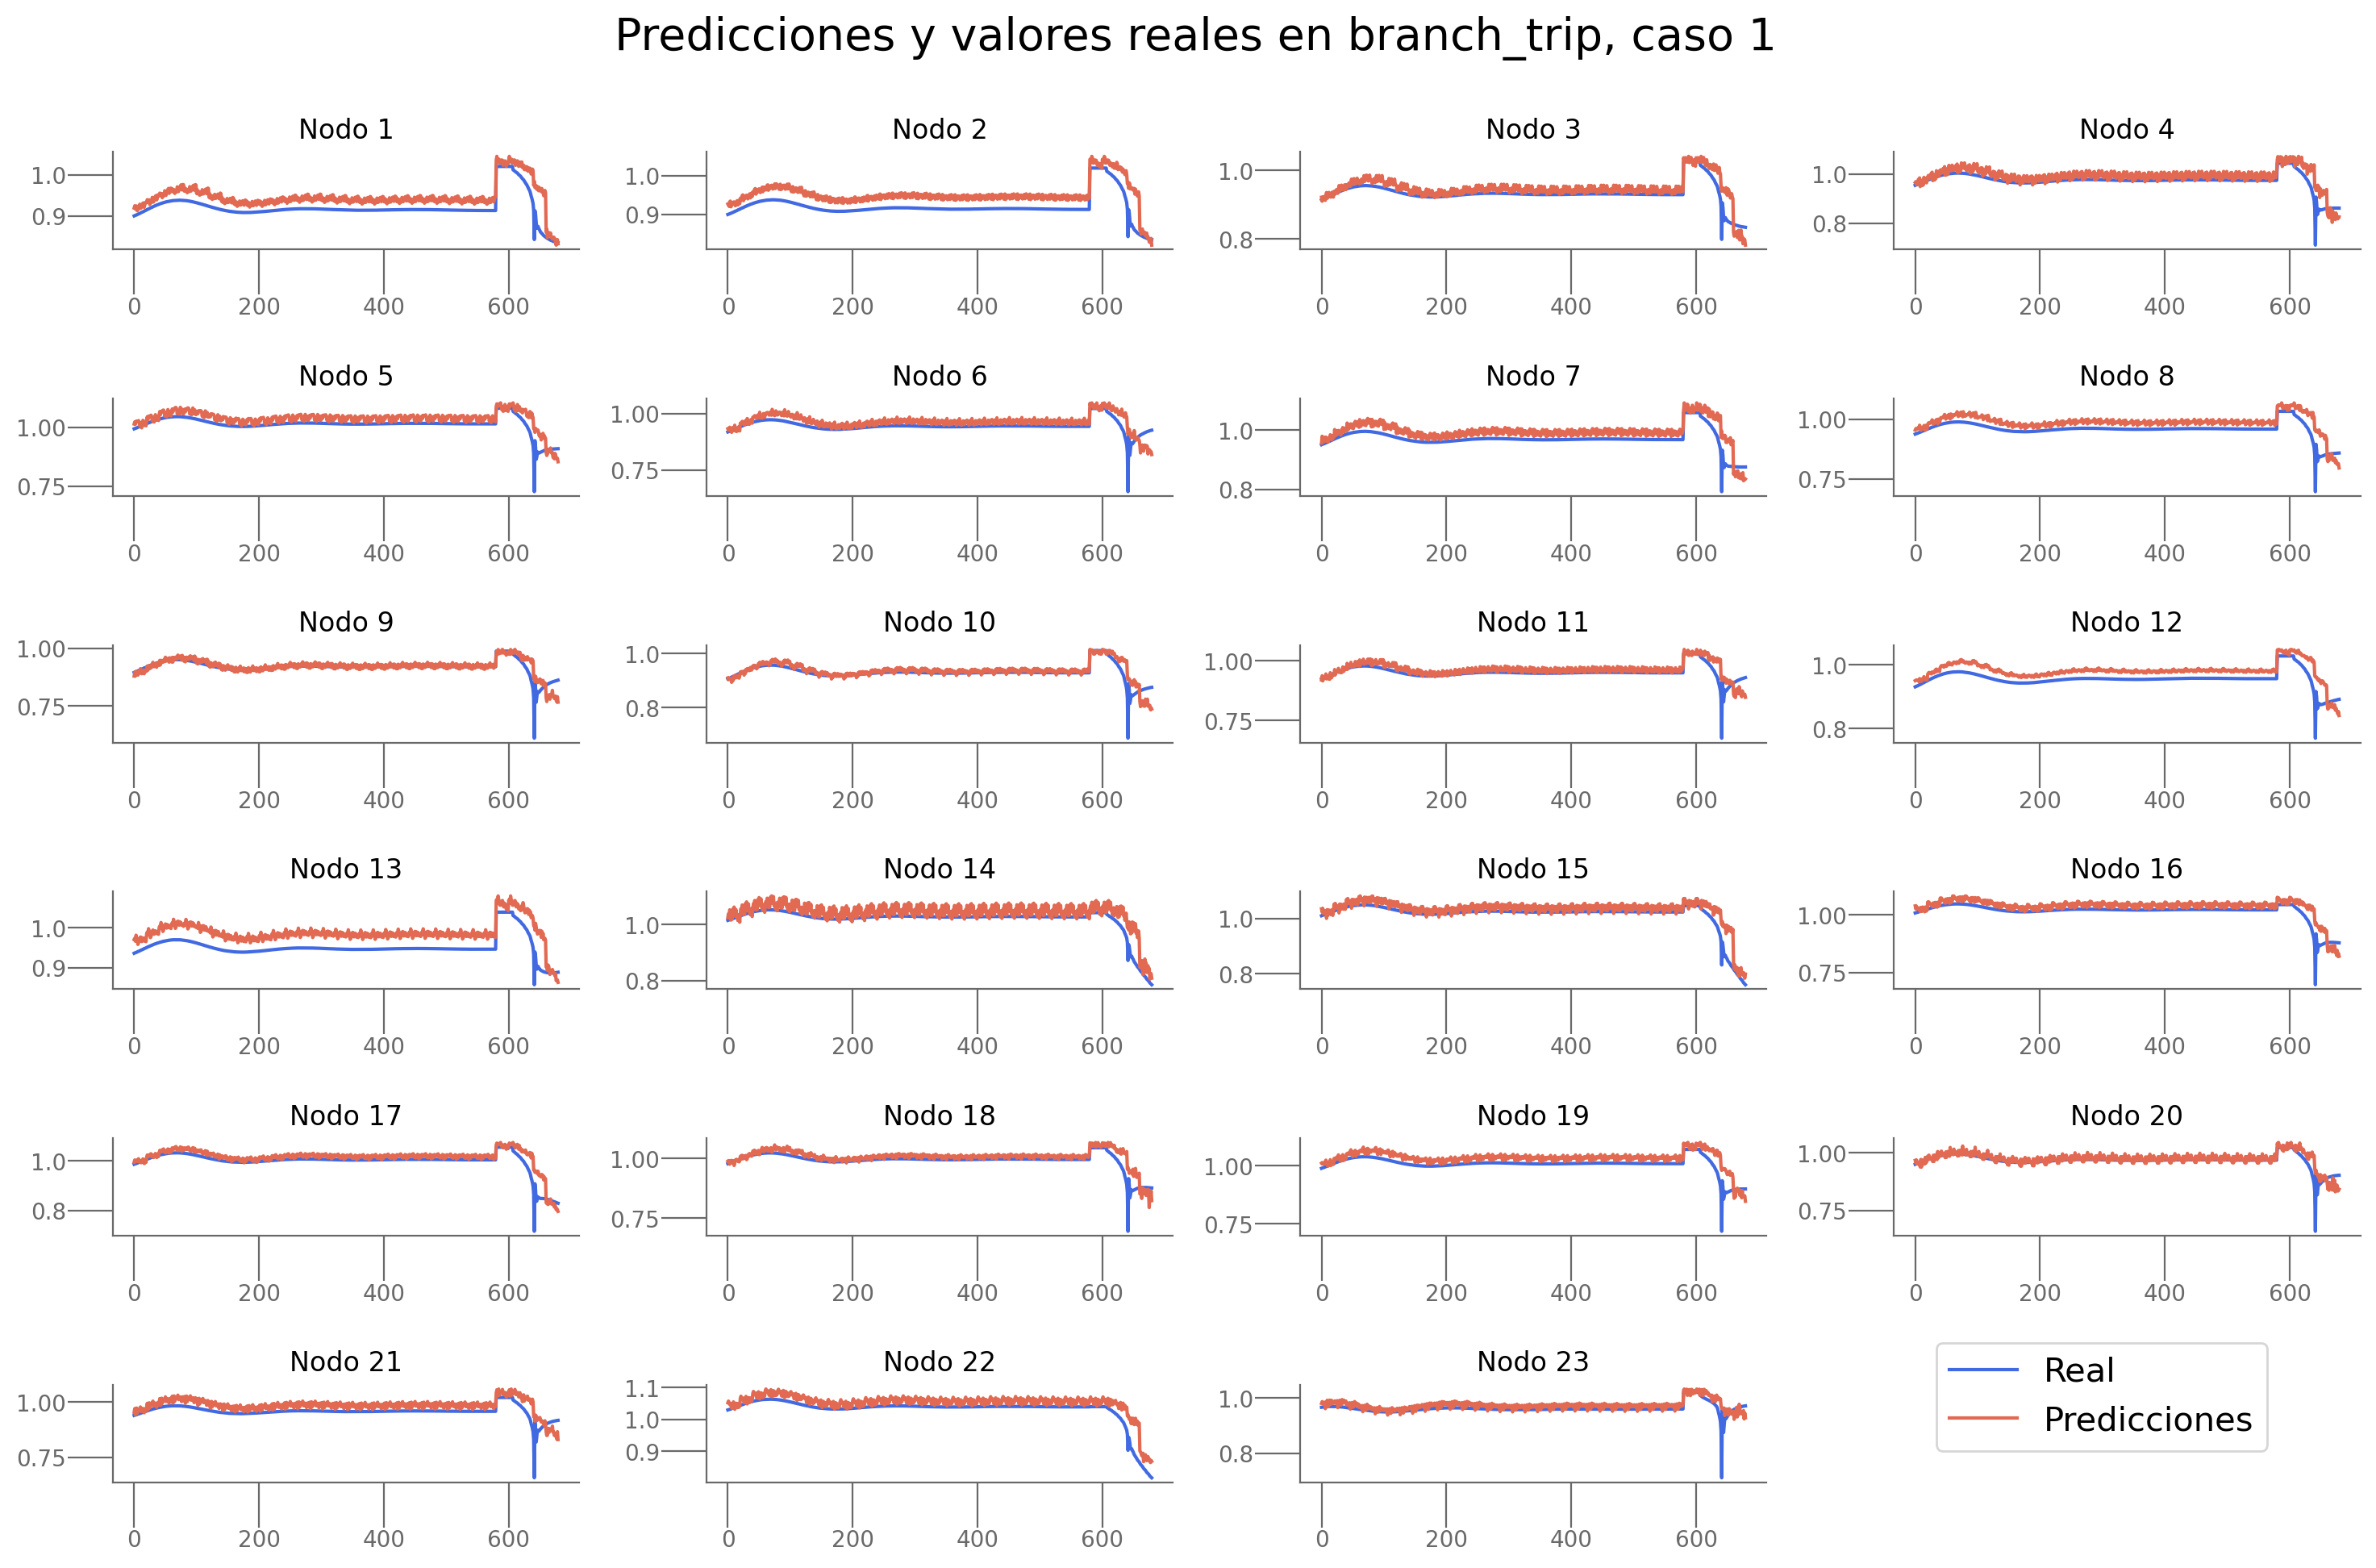

In [46]:
plot_predictions(predictions_brt_ajuste, real_brt_ajuste, n_target, 1, n_div_brt, problem_brt)

In [47]:
path_save_experiment_brt = results_save_path+f"/{problem_brt}"+ f"/ajustes/{name_model}_results.csv"
resultados_brt.to_csv(path_save_experiment_brt, index=False)

In [48]:
trainer_brt.save_model(path_save_experiment=path_save_experiment_brt, params=params_brt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 2}   
3     MPNN_LSTM                {'hidden_size': 32, 'dropout': 0.8}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.003700  0.398922   
1                                                NaN  0.004787 -1.839737   
2  ./results/branch_trip/ajustes/DryGrEncoder_res...  0.002719 -0.549398   
3  ./results/branch_trip/ajustes/MPNNLSTM_results...  0.004205 -1.453302   
4    ./results/branch_trip/ajustes/AGCRN_results.csv  0.005193 -0